In [ ]:
# Import essential libraries for data manipulation, modeling, and optimization

from pathlib import Path            # folder paths for datasets and outputs
import re                           # regex (e.g., cleaning column names)
import difflib                      # fuzzy matching (e.g., harmonize column labels)


import numpy as np                  # numerical arrays, vectorized ops
import pandas as pd                 # tabular data


import requests                     # download NASA POWER data via HTTP


import math, random, os, time


import matplotlib.pyplot as plt     # plots
import seaborn as sns               # EDA plots (heatmaps/boxplots)


from statsmodels.stats.outliers_influence import variance_inflation_factor      #VIF calculation-to detect multicollinearity
# =========================
# Train/validation strategy & model selection
# =========================
from sklearn.model_selection import TimeSeriesSplit   # time-aware CV
from sklearn.model_selection import train_test_split  # chronological split helper
from sklearn.model_selection import GridSearchCV      # hyperparameter search (LR/SVR/XGB etc.)

# =========================
# Preprocessing / feature scaling
# =========================
from sklearn.preprocessing import StandardScaler      # z-score scaling (good for LR/SVR)
from sklearn.preprocessing import MinMaxScaler        # [0,1] scaling (good for LSTM/Transformer)
from sklearn.preprocessing import PowerTransformer    # optional: Gaussianize skewed features

# =========================
# Classical baseline models
# =========================
from sklearn.linear_model import LinearRegression     # baseline regression
from sklearn.linear_model import RidgeCV              # optional: ridge with built-in CV

# =========================
# Metrics for evaluation
# =========================
from sklearn.metrics import (
    mean_absolute_error,    # MAE
    mean_squared_error,     # MSE/RMSE
    r2_score                # R2 goodness-of-fit
)

# =========================
# Deep learning (Keras/TensorFlow)
# =========================
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model          # model containers
from tensorflow.keras.layers import (                          # layers used in LSTM/Transformer
    Input, Dense, Dropout, LSTM,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam                   # optimizer
from tensorflow.keras.callbacks import (                        # training utilities
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras import regularizers                       # optional L2/L1 weight decay

import joblib                           # save/load scalers and classical models



#import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# **Data Importing**

In [ ]:
# === CONFIGURATION ===
latitude = -21.3333
longitude = 55.4833
years = range(2015, 2020)  # 2015–2019 inclusive
out_dir = Path("./saint_pierre_daily_data")
out_dir.mkdir(exist_ok=True)

# === VARIABLES TO DOWNLOAD ===
# Including solar, temperature, wind, cloud, and clear-sky irradiance
parameters = (
    "ALLSKY_SFC_SW_DWN,"      # Global Horizontal Irradiance (GHI)
    "ALLSKY_SFC_SW_DIFF,"     # Diffuse Horizontal Irradiance (DHI)
    "ALLSKY_KT,"              # Clearness Index
    "ALLSKY_SFC_SW_DNI,"      # Direct Normal Irradiance (BNI)
    "T2M,"                    # Air Temperature at 2m
    "T2M_MIN,"                # Air Temperature at 2m
    "T2M_MAX,"                # Air Temperature at 2m
    "WS2M,"                   # Wind Speed at 2m
    "WD2M,"                   # Wind Direction at 2m
    "CLOUD_AMT,"              # Total Cloud Fraction
    "PRECTOTCORR,"            # Precipitation
    "PS"                      # Surface Pressure
)

# === BASE URL ===
base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"

# === DOWNLOAD LOOP FOR EACH YEAR ===
for year in years:
    start = f"{year}0101"
    end = f"{year}1231"

    url = (
        f"{base_url}?start={start}&end={end}"
        f"&latitude={latitude}&longitude={longitude}"
        f"&parameters={parameters}"
        f"&community=RE&format=CSV"
    )

    print(f"Downloading {year} data ...")
    r = requests.get(url)
    r.raise_for_status()  # stop if download fails

    # Save raw CSV for the year
    out_file = out_dir / f"SaintPierre_{year}.csv"
    out_file.write_bytes(r.content)
    print(f"Saved {out_file}")




Saved saint_pierre_daily_data/SaintPierre_2015.csv
Saved saint_pierre_daily_data/SaintPierre_2016.csv
Saved saint_pierre_daily_data/SaintPierre_2017.csv
Saved saint_pierre_daily_data/SaintPierre_2018.csv
Saved saint_pierre_daily_data/SaintPierre_2019.csv


In [ ]:
def read_power_csv_daily(path: str | Path) -> pd.DataFrame:

    path = Path(path)
    with path.open("r", encoding="utf-8") as f:
        lines = f.readlines()

    header_idx = None
    for i, line in enumerate(lines):
        if line.strip().startswith("YEAR,"):
            header_idx = i
            break

    if header_idx is None:
        raise ValueError(f"[PARSE] Could not find 'YEAR,' header in: {path.name}")

    df = pd.read_csv(path, skiprows=header_idx)
    df.columns = [c.strip() for c in df.columns]

    needed = {"YEAR", "MO", "DY"}
    if not needed.issubset(df.columns):
        raise ValueError(f"[PARSE] Missing date columns in: {path.name} -> {df.columns.tolist()}")

    df["date"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MO"], day=df["DY"]))
    df.drop(columns=["YEAR", "MO", "DY"], inplace=True)
    df = df[["date"] + [c for c in df.columns if c != "date"]]
    return df

# --------- CONFIG ---------
folder = Path("./saint_pierre_daily_data")
pattern = "SaintPierre_*.csv"
# --------------------------

files = sorted(folder.glob(pattern))
print(f"[Found {len(files)} files in {folder.resolve()} matching '{pattern}'")
for f in files:
    print(" -", f.name)

parsed = []
for f in files:
    try:
        df = read_power_csv_daily(f)
        parsed.append(df)
        print(f"Parsed: {f.name} -> {len(df)} rows, {len(df.columns)} cols")
    except Exception as e:
        print(f"[SKIP] {f.name}: {e}")

if not parsed:
    raise RuntimeError("No objects to concatenate. Check folder path/pattern or inspect a file's header.")

merged = pd.concat(parsed, ignore_index=True).sort_values("date").reset_index(drop=True)
out_path = folder / "SaintPierre_2015_2019_Daily_Merged.csv"
merged.to_csv(out_path, index=False, date_format="%Y-%m-%d")

print(f"Merged {len(parsed)} files -> {len(merged)} rows, saved: {out_path}")


[INFO] Found 5 files in /content/saint_pierre_daily_data matching 'SaintPierre_*.csv'
 - SaintPierre_2015.csv
 - SaintPierre_2016.csv
 - SaintPierre_2017.csv
 - SaintPierre_2018.csv
 - SaintPierre_2019.csv
[OK] Parsed: SaintPierre_2015.csv -> 365 rows, 13 cols
[OK] Parsed: SaintPierre_2016.csv -> 366 rows, 13 cols
[OK] Parsed: SaintPierre_2017.csv -> 365 rows, 13 cols
[OK] Parsed: SaintPierre_2018.csv -> 365 rows, 13 cols
[OK] Parsed: SaintPierre_2019.csv -> 365 rows, 13 cols
[DONE] Merged 5 files -> 1826 rows, saved: saint_pierre_daily_data/SaintPierre_2015_2019_Daily_Merged.csv


# **Read merged weather data 2015-2019**

In [ ]:
weath=pd.read_csv('/content/saint_pierre_daily_data/SaintPierre_2015_2019_Daily_Merged.csv')
weath.head()

date  ALLSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DIFF  ALLSKY_KT  \
0  2015-01-01             7.0598              2.5039       0.60   
1  2015-01-02             6.1032              3.0595       0.52   
2  2015-01-03             6.1198              3.5405       0.52   
3  2015-01-04             6.9089              3.5950       0.59   
4  2015-01-05             6.2345              4.3742       0.53   

   ALLSKY_SFC_SW_DNI    T2M  T2M_MIN  T2M_MAX  WS2M  WD2M  CLOUD_AMT  \
0             6.4490  27.68    26.75    28.46  1.75  11.7      64.87   
1             3.8815  27.64    26.54    28.84  2.40  55.3      84.73   
2             3.9139  28.10    27.08    29.30  3.91  50.2      88.30   
3             6.3065  28.41    27.58    29.38  4.29  29.9      74.22   
4             3.0552  28.61    27.94    29.48  3.90  20.9      94.43   

   PRECTOTCORR      PS  
0         2.02   99.97  
1         1.47  100.06  
2         0.49  100.03  
3         2.65   99.92  
4         7.15   99.82

In [ ]:
weath.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1826 non-null   object 
 1   ALLSKY_SFC_SW_DWN   1826 non-null   float64
 2   ALLSKY_SFC_SW_DIFF  1826 non-null   float64
 3   ALLSKY_KT           1826 non-null   float64
 4   ALLSKY_SFC_SW_DNI   1826 non-null   float64
 5   T2M                 1826 non-null   float64
 6   T2M_MIN             1826 non-null   float64
 7   T2M_MAX             1826 non-null   float64
 8   WS2M                1826 non-null   float64
 9   WD2M                1826 non-null   float64
 10  CLOUD_AMT           1826 non-null   float64
 11  PRECTOTCORR         1826 non-null   float64
 12  PS                  1826 non-null   float64
dtypes: float64(12), object(1)
memory usage: 185.6+ KB


In [ ]:
#changing datatype of date from oblejct to datetime
weath['date'] = pd.to_datetime(weath['date'])

print(weath.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1826 non-null   datetime64[ns]
 1   ALLSKY_SFC_SW_DWN   1826 non-null   float64       
 2   ALLSKY_SFC_SW_DIFF  1826 non-null   float64       
 3   ALLSKY_KT           1826 non-null   float64       
 4   ALLSKY_SFC_SW_DNI   1826 non-null   float64       
 5   T2M                 1826 non-null   float64       
 6   T2M_MIN             1826 non-null   float64       
 7   T2M_MAX             1826 non-null   float64       
 8   WS2M                1826 non-null   float64       
 9   WD2M                1826 non-null   float64       
 10  CLOUD_AMT           1826 non-null   float64       
 11  PRECTOTCORR         1826 non-null   float64       
 12  PS                  1826 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 

In [ ]:
# Load dataset
pv_data = pd.read_excel('/content/sample_data/Prod_PV_Enerpos_2015-2019_final.xlsx')

# Display the first few rows to understand the dataset
print(pv_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1821 non-null   datetime64[ns]
 1   Ieap    1818 non-null   float64       
 2   Ieac    1758 non-null   float64       
 3   Ierp    1758 non-null   float64       
 4   Ierc    1758 non-null   float64       
 5   Hi1     1820 non-null   float64       
 6   Hi2     1820 non-null   float64       
 7   Eg1     1820 non-null   float64       
 8   Eg2     1820 non-null   float64       
 9   Eg3     1820 non-null   float64       
 10  Eg4     1820 non-null   float64       
 11  Eg5     1820 non-null   float64       
 12  Eg6     1820 non-null   float64       
 13  Eg7     1820 non-null   float64       
 14  Eg8     1820 non-null   float64       
 15  Eg9     1820 non-null   float64       
 16  Eg10    1820 non-null   float64       
 17  Eg11    1820 non-null   float64       
 18  Eg12    

In [ ]:
pv_data.head()

Date      Ieap   Ieac     Ierp   Ierc     Hi1     Hi2      Eg1  \
0 2014-12-31  352519.0  889.0  64546.0  868.0     NaN     NaN      NaN   
1 2015-01-01  352787.0  890.0  64574.0  870.0  7542.0  7671.0  22604.0   
2 2015-01-02  352936.0  890.0  64618.0  871.0  4058.0  4054.0  12471.0   
3 2015-01-03  353113.0  890.0  64656.0  871.0  4773.0  4931.0  14781.0   
4 2015-01-04  353360.0  891.0  64687.0  872.0  6879.0  7036.0  20789.0   

       Eg2      Eg3  ...    Tg4    Tg5    Tg6    Tg7    Tg8    Tg9  Tg10  \
0      NaN      NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   NaN   
1  22843.0  22767.0  ...  778.0  778.0  780.0  783.0  782.0  781.0   0.0   
2  12456.0  12376.0  ...  786.0  787.0  787.0  790.0  791.0  792.0   0.0   
3  14873.0  14824.0  ...  751.0  752.0  752.0  760.0  759.0  758.0   0.0   
4  20872.0  20783.0  ...  784.0  784.0  783.0  783.0  786.0  785.0   0.0   

    Tg11   Tg12   Tg13  
0    NaN    NaN    NaN  
1  778.0  781.0  781.0  
2  788.0  788.0  790.0  
3  751.0  748.0  757.0  
4  783.0  784.0  786.0  

[5 rows x 33 columns]

# **Data Preprocessing**

**1. Merge weather and PV production datasets**

In [ ]:
#Change PV_prod datetime variable to datetime format
pv_data['datetime'] = pd.to_datetime(pv_data['Date'])
weath['datetime'] = pd.to_datetime(weath['date'])

# Merge on datetime
df = pd.merge(weath, pv_data, on='datetime', how='inner')  # 'inner' keeps only matching timestamps

# Sort by datetime
df = df.sort_values('datetime').reset_index(drop=True)
#df.info()
# Save merged file
merged.to_csv("merged_weather_data.csv", index=False)

In [ ]:
df.info()
#47 total columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1820 non-null   datetime64[ns]
 1   ALLSKY_SFC_SW_DWN   1820 non-null   float64       
 2   ALLSKY_SFC_SW_DIFF  1820 non-null   float64       
 3   ALLSKY_KT           1820 non-null   float64       
 4   ALLSKY_SFC_SW_DNI   1820 non-null   float64       
 5   T2M                 1820 non-null   float64       
 6   T2M_MIN             1820 non-null   float64       
 7   T2M_MAX             1820 non-null   float64       
 8   WS2M                1820 non-null   float64       
 9   WD2M                1820 non-null   float64       
 10  CLOUD_AMT           1820 non-null   float64       
 11  PRECTOTCORR         1820 non-null   float64       
 12  PS                  1820 non-null   float64       
 13  datetime            1820 non-null   datetime64[n

**2. Feature Selection**

In [ ]:
#Drop duplicate rows and unnecessery rows
df= df.drop(df.filter(regex='^(Eg|Tg)').columns, axis=1)
df = df.drop(columns=['datetime','Ieac','Ierp',	'Ierc','Hi1','Hi2','Date'], errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1820 non-null   datetime64[ns]
 1   ALLSKY_SFC_SW_DWN   1820 non-null   float64       
 2   ALLSKY_SFC_SW_DIFF  1820 non-null   float64       
 3   ALLSKY_KT           1820 non-null   float64       
 4   ALLSKY_SFC_SW_DNI   1820 non-null   float64       
 5   T2M                 1820 non-null   float64       
 6   T2M_MIN             1820 non-null   float64       
 7   T2M_MAX             1820 non-null   float64       
 8   WS2M                1820 non-null   float64       
 9   WD2M                1820 non-null   float64       
 10  CLOUD_AMT           1820 non-null   float64       
 11  PRECTOTCORR         1820 non-null   float64       
 12  PS                  1820 non-null   float64       
 13  Ieap                1817 non-null   float64     

In [ ]:
df.describe()

date  ALLSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DIFF  \
count                           1820        1820.000000         1820.000000   
mean   2017-06-30 20:08:58.021978112           5.528126            1.815878   
min              2015-01-01 00:00:00           1.025500            0.683800   
25%              2016-03-30 18:00:00           4.320375            1.366525   
50%              2017-06-30 12:00:00           5.544000            1.699450   
75%              2018-10-02 06:00:00           6.762425            2.123900   
max              2019-12-31 00:00:00           8.383000            4.374200   
std                              NaN           1.459570            0.627722   

         ALLSKY_KT  ALLSKY_SFC_SW_DNI          T2M      T2M_MIN      T2M_MAX  \
count  1820.000000        1820.000000  1820.000000  1820.000000  1820.000000   
mean      0.590951           5.619366    24.773637    24.042819    25.586445   
min       0.100000           0.035300    20.460000    19.920000    20.920000   
25%       0.560000           4.676525    22.920000    22.190000    23.730000   
50%       0.620000           5.946850    24.810000    24.030000    25.670000   
75%       0.650000           6.948500    26.602500    25.882500    27.390000   
max       0.730000           9.941500    28.820000    28.230000    29.910000   
std       0.092990           1.884417     2.054463     2.042716     2.128730   

              WS2M        WD2M    CLOUD_AMT  PRECTOTCORR           PS  \
count  1820.000000  1820.00000  1820.000000  1820.000000  1820.000000   
mean      5.013709   111.04967    48.796214     1.817489   100.623154   
min       1.040000     0.20000    10.390000     0.000000    98.710000   
25%       3.710000    82.30000    32.055000     0.180000   100.310000   
50%       4.945000   101.90000    44.340000     0.470000   100.630000   
75%       6.282500   122.87500    63.305000     1.420000   100.960000   
max      12.650000   358.60000    99.960000    86.730000   101.710000   
std       1.787977    53.52887    21.219309     4.801926     0.440923   

                Ieap  
count    1817.000000  
mean   536377.145294  
min    352787.000000  
25%    446221.000000  
50%    537279.000000  
75%    624705.000000  
max    722508.000000  
std    106837.734210

In [ ]:
print(df.columns.to_list())

['date', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_SW_DIFF', 'ALLSKY_KT', 'ALLSKY_SFC_SW_DNI', 'T2M', 'T2M_MIN', 'T2M_MAX', 'WS2M', 'WD2M', 'CLOUD_AMT', 'PRECTOTCORR', 'PS', 'Ieap']


**3. Renaming variables for easier understing**

In [ ]:
def parse_date_column(df: pd.DataFrame,
                      src_col: str = "date",
                      out_col: str = "date",
                      make_utc: bool = False) -> pd.DataFrame:
    """
    Parse a date-like column and store as `out_col`.
    - If `make_utc=True`, returns timezone-aware UTC.
    - If False (default), returns timezone-naive (recommended for daily data).
    """
    if src_col not in df.columns:
        raise KeyError(f"Expected date column '{src_col}' not found. Available: {list(df.columns)}")

    ts = pd.to_datetime(df[src_col], errors="coerce", utc=make_utc)
    if ts.isna().any():
        bad = df.loc[ts.isna(), src_col].head(5).tolist()
        raise ValueError(f"Non-parsable timestamps in '{src_col}'. Examples: {bad}")

    df = df.copy()
    df[out_col] = ts
    if out_col != src_col:
        df.drop(columns=[src_col], inplace=True)
    return df


def rename_weather_columns(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Map NASA/POWER (and your PV) variable names to concise aliases.
    Only renames columns that actually exist; leaves others unchanged.
    """
    colmap = {
        "ALLSKY_SFC_SW_DWN":  "GHI",        # Global Horizontal Irradiance
        "ALLSKY_SFC_SW_DIFF": "DIF",        # Diffuse irradiance
        "ALLSKY_SFC_SW_DNI":  "DNI",        # Direct normal irradiance
        "ALLSKY_KT":          "KT",         # Clearness index (0–1)
        "T2M":                "TEMP",       # Mean 2m air temperature [°C]
        "T2M_MIN":            "TEMP_MIN",
        "T2M_MAX":            "TEMP_MAX",
        "WS2M":               "WIND",       # Wind speed [m/s]
        "WD2M":               "WIND_DIR",   # Wind direction [deg]
        "CLOUD_AMT":          "CLOUD",      # Total cloud amount [%]
        "PRECTOTCORR":        "RAIN",       # Precipitation [mm/day]
        "PS":                 "PRES_KPA",   # Surface pressure [kPa]
        "Ieap":               "PV_PROD",    # PV production (your target), unit as per source
        # If you later add RH2M, include it here:
        # "RH2M":            "RH",
    }

    df = df.copy()
    performed = {}
    for src, dst in colmap.items():
        if src in df.columns:
            if dst in df.columns and dst != src:
                dst = f"{dst}_src"
            df.rename(columns={src: dst}, inplace=True)
            performed[src] = dst

    if verbose:
        if performed:
            print("Renamed columns:", performed)
        else:
            print("No columns renamed (none of the expected keys were present).")
    return df


# 1) Parse/standardize the date column
df = parse_date_column(df, src_col="date", out_col="date", make_utc=False)

# 2) Rename variables to concise aliases
df = rename_weather_columns(df, verbose=True)

# 3) Reorder with date first
cols = ["date"] + [c for c in df.columns if c != "date"]
df = df[cols]

# 4) Check for NaNs
print(df.isna().sum().sort_values(ascending=False).head(10))



Renamed columns: {'ALLSKY_SFC_SW_DWN': 'GHI', 'ALLSKY_SFC_SW_DIFF': 'DIF', 'ALLSKY_SFC_SW_DNI': 'DNI', 'ALLSKY_KT': 'KT', 'T2M': 'TEMP', 'T2M_MIN': 'TEMP_MIN', 'T2M_MAX': 'TEMP_MAX', 'WS2M': 'WIND', 'WD2M': 'WIND_DIR', 'CLOUD_AMT': 'CLOUD', 'PRECTOTCORR': 'RAIN', 'PS': 'PRES_KPA', 'Ieap': 'PV_PROD'}
PV_PROD     3
date        0
DIF         0
KT          0
DNI         0
GHI         0
TEMP        0
TEMP_MIN    0
WIND        0
TEMP_MAX    0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1820 non-null   datetime64[ns]
 1   GHI       1820 non-null   float64       
 2   DIF       1820 non-null   float64       
 3   KT        1820 non-null   float64       
 4   DNI       1820 non-null   float64       
 5   TEMP      1820 non-null   float64       
 6   TEMP_MIN  1820 non-null   float64       
 7   TEMP_MAX  1820 non-null   float64       
 8   WIND      1820 non-null   float64       
 9   WIND_DIR  1820 non-null   float64       
 10  CLOUD     1820 non-null   float64       
 11  RAIN      1820 non-null   float64       
 12  PRES_KPA  1820 non-null   float64       
 13  PV_PROD   1817 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 199.2 KB


**4. Missing Values Visualization (Missing Data Heatmap)**

Purpose: To identify and visualize any missing values in the dataset.

Graph Type: Heatmap or Bar Plot for missing values.



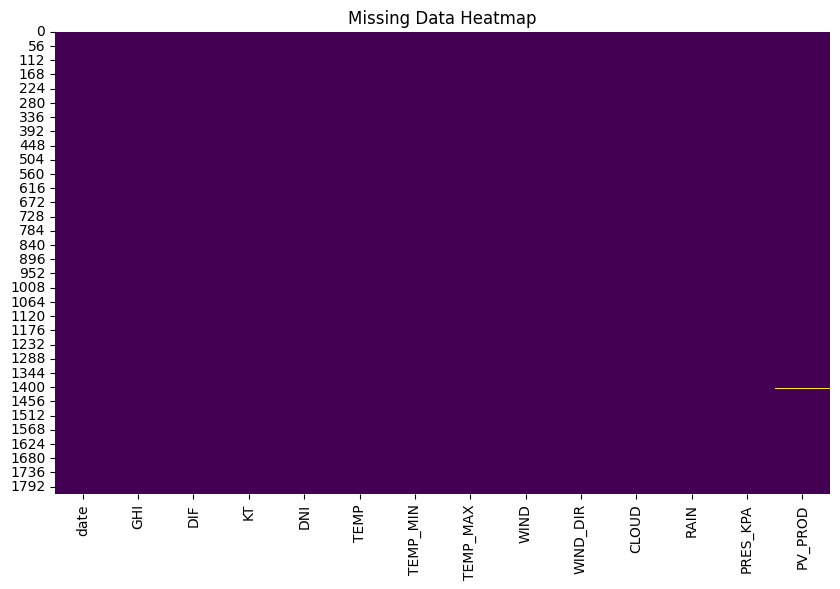

In [ ]:
# Visualize missing data with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


In [ ]:
df.isna().sum()

date        0
GHI         0
DIF         0
KT          0
DNI         0
TEMP        0
TEMP_MIN    0
TEMP_MAX    0
WIND        0
WIND_DIR    0
CLOUD       0
RAIN        0
PRES_KPA    0
PV_PROD     3
dtype: int64

In [ ]:
#Handling missing values
#Since this is an energy production index, it changes over time.
#Because our data has a time sequence (Date), we interpolate it linearly:

df = df.sort_values('date')
df['PV_PROD'] = df['PV_PROD'].interpolate(method='linear')
df.isna().sum()

date        0
GHI         0
DIF         0
KT          0
DNI         0
TEMP        0
TEMP_MIN    0
TEMP_MAX    0
WIND        0
WIND_DIR    0
CLOUD       0
RAIN        0
PRES_KPA    0
PV_PROD     0
dtype: int64

In [ ]:
print(df.columns.to_list())

['date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'TEMP_MIN', 'TEMP_MAX', 'WIND', 'WIND_DIR', 'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD']


In [ ]:
df.describe()

date          GHI          DIF           KT  \
count                           1820  1820.000000  1820.000000  1820.000000   
mean   2017-06-30 20:08:58.021978112     5.528126     1.815878     0.590951   
min              2015-01-01 00:00:00     1.025500     0.683800     0.100000   
25%              2016-03-30 18:00:00     4.320375     1.366525     0.560000   
50%              2017-06-30 12:00:00     5.544000     1.699450     0.620000   
75%              2018-10-02 06:00:00     6.762425     2.123900     0.650000   
max              2019-12-31 00:00:00     8.383000     4.374200     0.730000   
std                              NaN     1.459570     0.627722     0.092990   

               DNI         TEMP     TEMP_MIN     TEMP_MAX         WIND  \
count  1820.000000  1820.000000  1820.000000  1820.000000  1820.000000   
mean      5.619366    24.773637    24.042819    25.586445     5.013709   
min       0.035300    20.460000    19.920000    20.920000     1.040000   
25%       4.676525    22.920000    22.190000    23.730000     3.710000   
50%       5.946850    24.810000    24.030000    25.670000     4.945000   
75%       6.948500    26.602500    25.882500    27.390000     6.282500   
max       9.941500    28.820000    28.230000    29.910000    12.650000   
std       1.884417     2.054463     2.042716     2.128730     1.787977   

         WIND_DIR        CLOUD         RAIN     PRES_KPA        PV_PROD  
count  1820.00000  1820.000000  1820.000000  1820.000000    1820.000000  
mean    111.04967    48.796214     1.817489   100.623154  536539.234890  
min       0.20000    10.390000     0.000000    98.710000  352787.000000  
25%      82.30000    32.055000     0.180000   100.310000  446371.750000  
50%     101.90000    44.340000     0.470000   100.630000  537499.000000  
75%     122.87500    63.305000     1.420000   100.960000  625145.000000  
max     358.60000    99.960000    86.730000   101.710000  722508.000000  
std      53.52887    21.219309     4.801926     0.440923  106824.144418

In [ ]:
#Remove extra spaces and invisible characters
df.columns = df.columns.str.strip()

In [ ]:
SAVE_FIGS = True
OUTDIR = "eda_figures"
FIG_DPI = 300
os.makedirs(OUTDIR, exist_ok=True)

# Helper function for saving / showing figures
def save_or_show(fig, name):
    """Save figure to file if SAVE_FIGS=True, otherwise just show."""
    if SAVE_FIGS:
        fig.savefig(os.path.join(OUTDIR, f"{name}.png"),
                    dpi=FIG_DPI, bbox_inches='tight')
    plt.show()


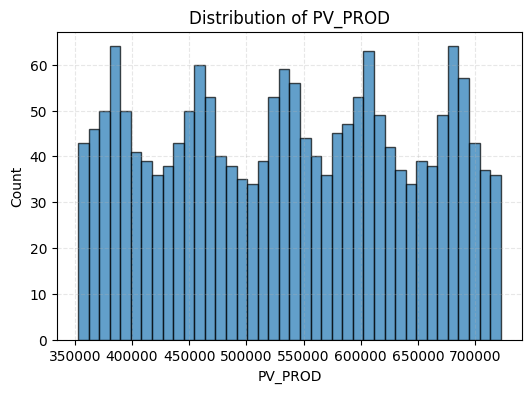

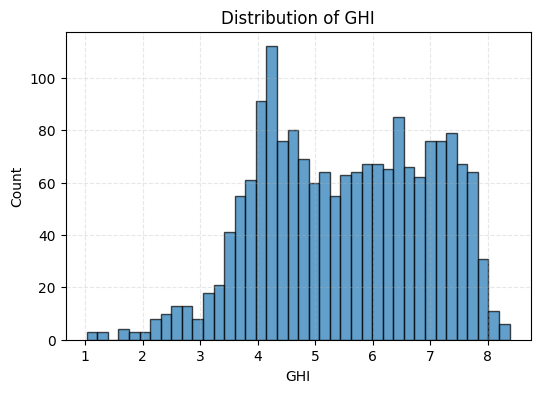

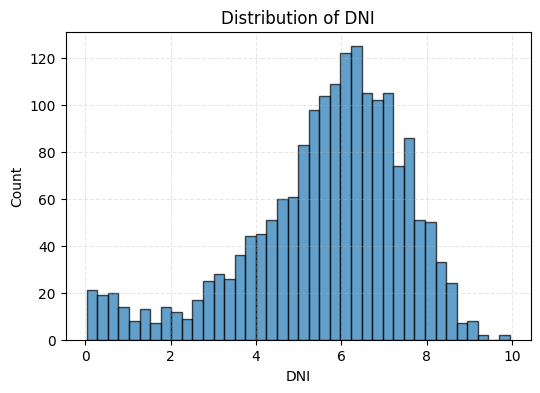

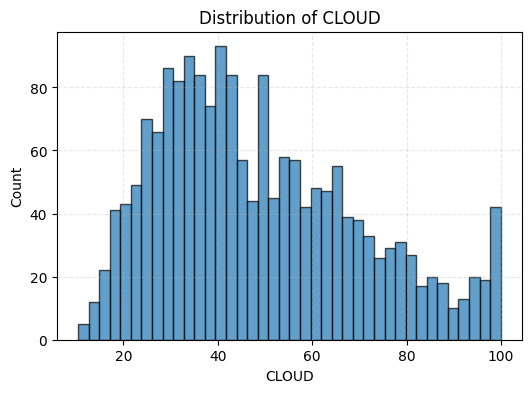

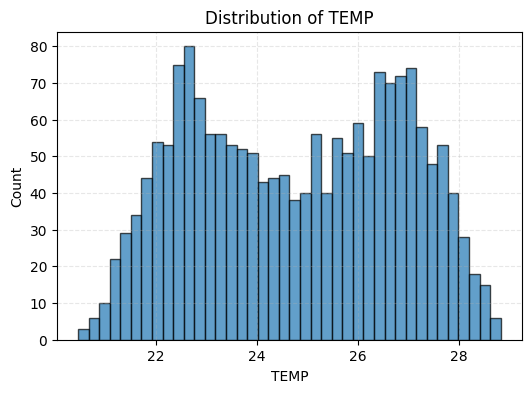

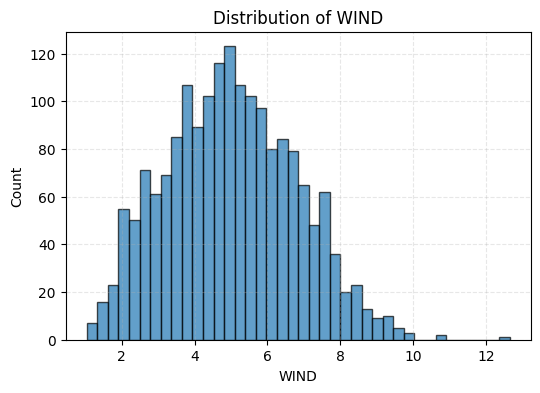

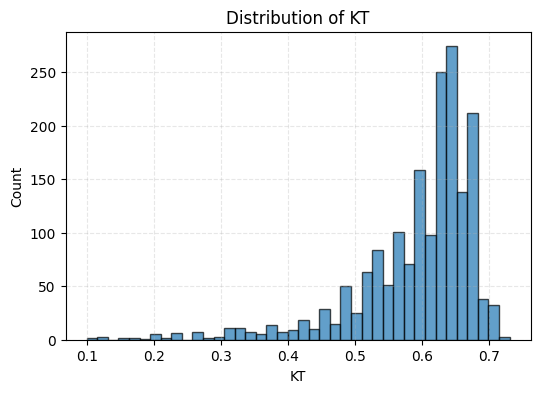

In [ ]:
TARGET = 'PV_PROD'
def hist_one(series, title, fname, bins=40):
    """Simple histogram with grid + title."""
    s = pd.to_numeric(series, errors='coerce').dropna()
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(s.values, bins=bins, edgecolor='black', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(series.name)
    ax.set_ylabel("Count")
    ax.grid(True, linestyle='--', alpha=0.3)
    save_or_show(fig, fname)

# Histogram of target
hist_one(df[TARGET], f"Distribution of {TARGET}", "hist_target")

# Key predictors
for col in ['GHI','DNI','CLOUD','TEMP','WIND','KT']:
    if col in df.columns:
        hist_one(df[col], f"Distribution of {col}", f"hist_{col}")



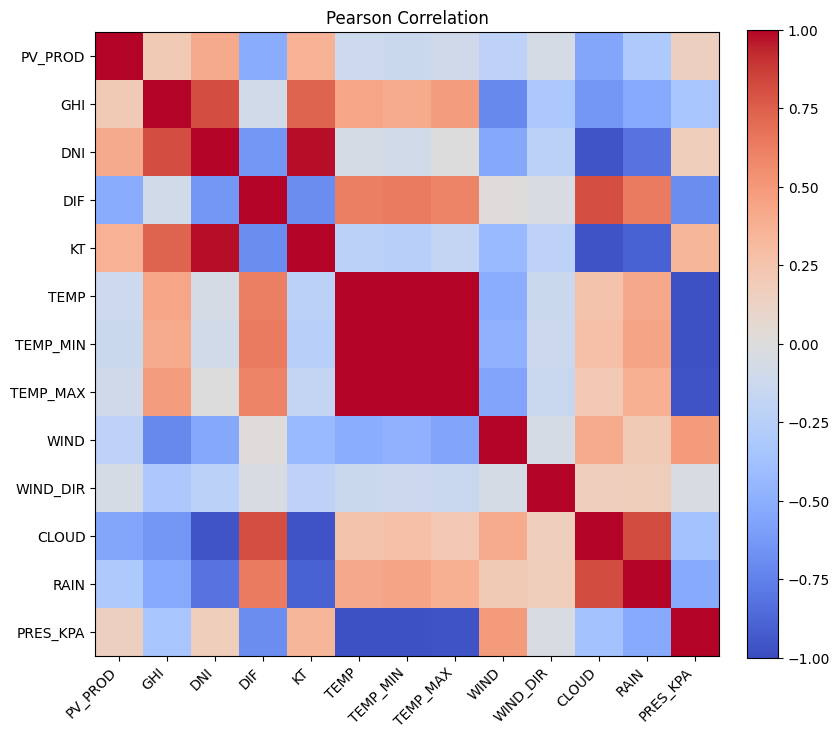

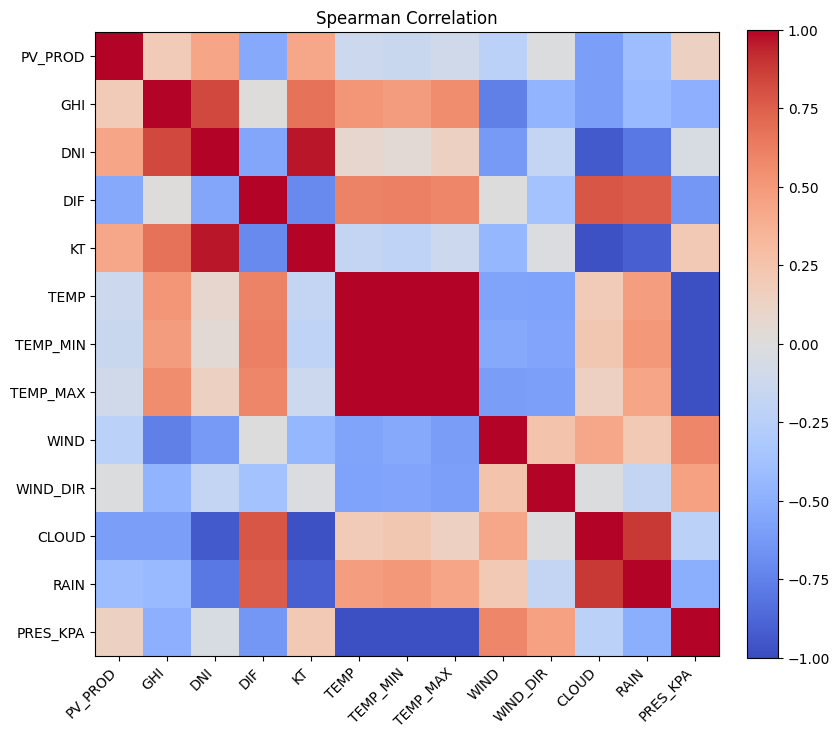

In [ ]:
# SECTION 6 — CORRELATION HEATMAPS (PEARSON & SPEARMAN)
# ------------------------------------------------------------
BASE_FEATURES = [
    'GHI','DNI','DIF','KT','TEMP','TEMP_MIN','TEMP_MAX',
    'WIND','WIND_DIR','CLOUD','RAIN','PRES_KPA'
]
def heatmap(frame, title, fname):
    """Matplotlib imshow heatmap of correlation matrix."""
    C = frame.corr()
    labels = C.columns
    fig, ax = plt.subplots(figsize=(0.5*len(labels)+2, 0.5*len(labels)+2))
    im = ax.imshow(C.values, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    save_or_show(fig, fname)

NUM_COLS = [TARGET] + [c for c in BASE_FEATURES if c in df.columns]

heatmap(df[NUM_COLS].corr(method='pearson'), "Pearson Correlation", "corr_pearson")
heatmap(df[NUM_COLS].corr(method='spearman'), "Spearman Correlation", "corr_spearman")


# **Outliers**

📊 Outlier summary (IQR method):
variable  n_outliers  %_outliers  lower_bound  upper_bound
    RAIN         219       12.03      -1.6800       3.2800
WIND_DIR         144        7.91      21.4375     183.7375
      KT         108        5.93       0.4250       0.7850
     DNI          82        4.51       1.2686      10.3565
     DIF          68        3.74       0.2305       3.2600
PRES_KPA           6        0.33      99.3350     101.9350
    WIND           3        0.16      -0.1488      10.1413
     GHI           0        0.00       0.6573      10.4255
    TEMP           0        0.00      17.3963      32.1262
   CLOUD           0        0.00     -14.8200     110.1800
 PV_PROD           0        0.00  178211.8750  893304.8750


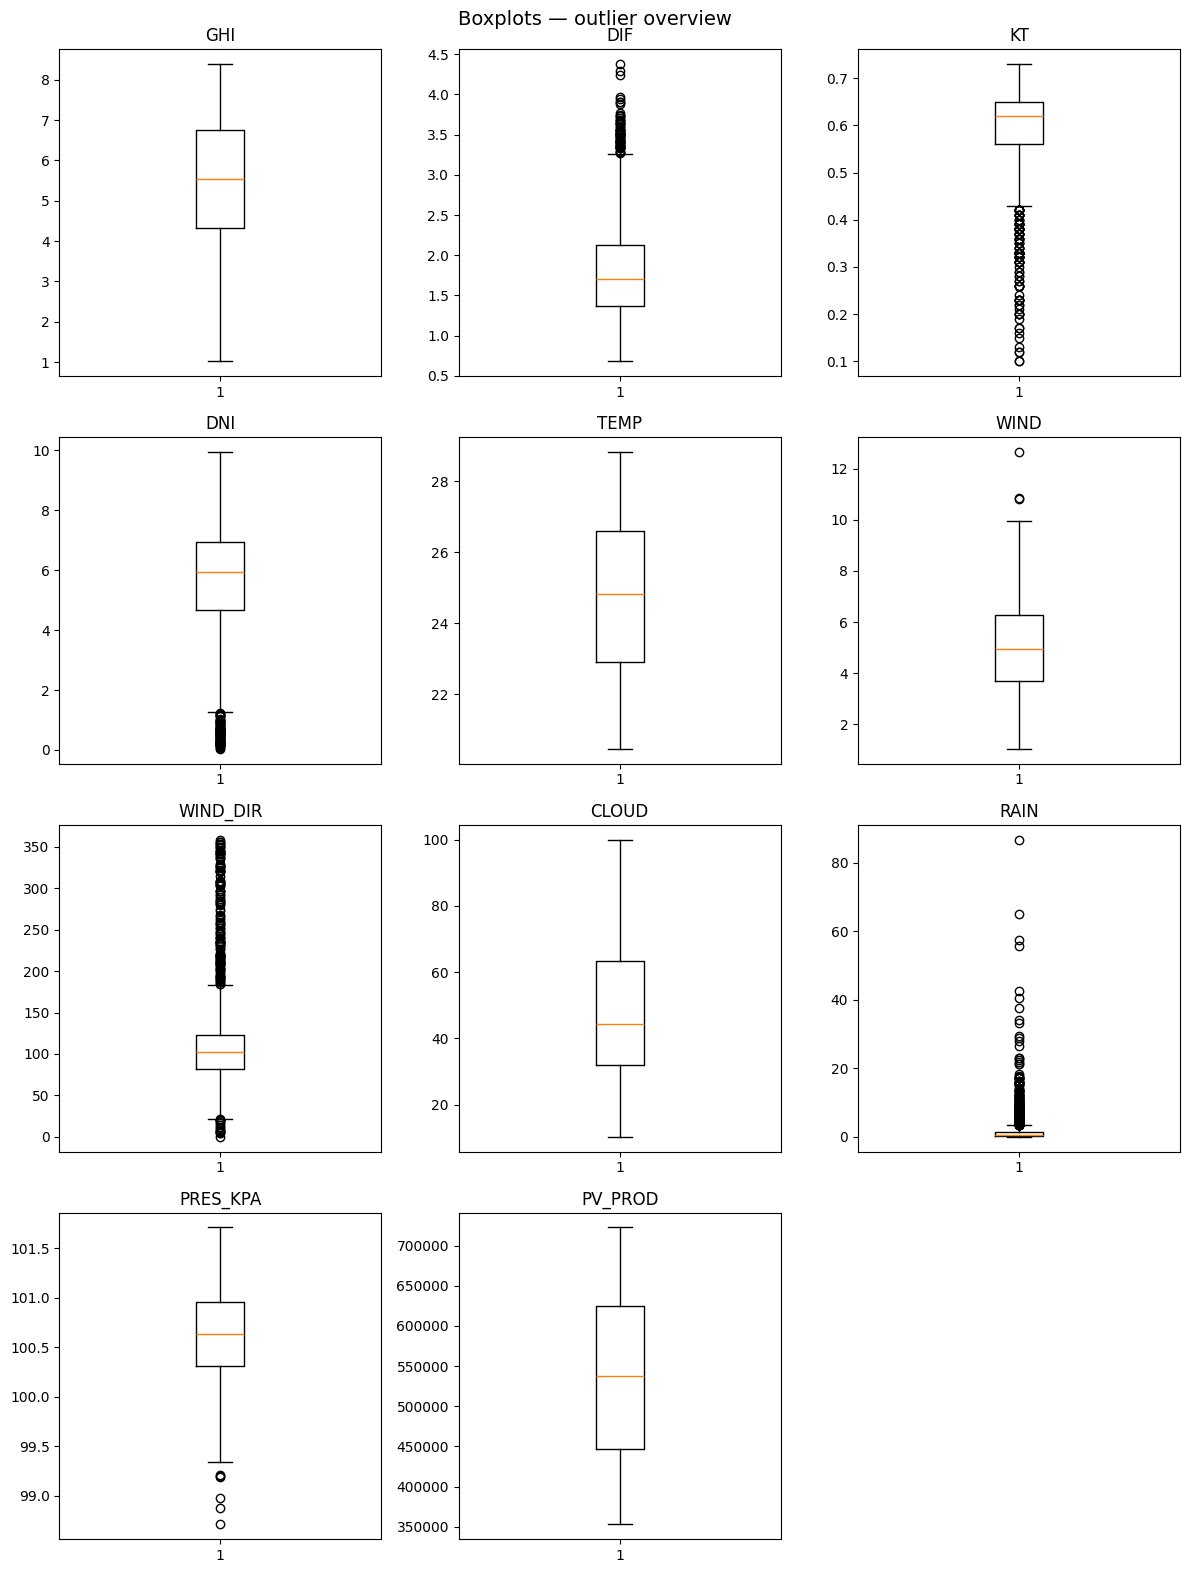


Top 5 highest values for GHI:
           date     GHI
1429 2018-12-06  8.3830
726  2016-12-27  8.3561
727  2016-12-28  8.3306
728  2016-12-29  8.3268
1793 2019-12-05  8.2404

Top 5 lowest values for GHI:
           date     GHI
1156 2018-03-04  1.0255
67   2015-03-09  1.0622
839  2017-04-19  1.0946
1157 2018-03-05  1.2847
215  2015-08-04  1.3728

Top 5 highest values for PV_PROD:
           date   PV_PROD
1819 2019-12-31  722508.0
1818 2019-12-30  722273.0
1817 2019-12-29  722179.0
1816 2019-12-28  722009.0
1815 2019-12-27  721700.0

Top 5 lowest values for PV_PROD:
        date   PV_PROD
0 2015-01-01  352787.0
1 2015-01-02  352936.0
2 2015-01-03  353113.0
3 2015-01-04  353360.0
4 2015-01-05  353563.0


In [ ]:


# -----------------------------
# Variables of interest
# -----------------------------
VARS = ['GHI','DIF','KT','DNI','TEMP',
        'WIND','WIND_DIR','CLOUD','RAIN','PRES_KPA','PV_PROD']

# Ensure numeric
df_num = df.copy()
df_num[VARS] = df[VARS].apply(pd.to_numeric, errors='coerce')

# -----------------------------
# 1) Compute IQR thresholds
# -----------------------------
def iqr_bounds(s: pd.Series, k=1.5):
    """Return lower and upper bounds using Tukey's rule."""
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

outlier_report = []
for col in VARS:
    s = df_num[col].dropna()
    if s.empty: continue
    lo, hi = iqr_bounds(s)
    outliers = ((s < lo) | (s > hi)).sum()
    outlier_report.append({
        "variable": col,
        "n_outliers": int(outliers),
        "%_outliers": round(100 * outliers / len(s), 2),
        "lower_bound": round(lo, 4),
        "upper_bound": round(hi, 4)
    })

outlier_df = pd.DataFrame(outlier_report).sort_values("%_outliers", ascending=False)
print("📊 Outlier summary (IQR method):")
print(outlier_df.to_string(index=False))

# -----------------------------
# 2) Boxplot grid for quick visual check
# -----------------------------
n = len(VARS)
rows = int(np.ceil(n/3))
fig, axes = plt.subplots(rows, 3, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, col in zip(axes, VARS):
    if col in df_num:
        ax.boxplot(df_num[col].dropna(), vert=True)
        ax.set_title(col)

for ax in axes[len(VARS):]:
    ax.axis("off")

plt.suptitle("Boxplots — outlier overview", fontsize=14)
plt.tight_layout()
plt.show()

# -----------------------------
# 3) Optional: show worst outliers for a variable
# -----------------------------
def show_extremes(df, col, n=5):
    """Prints top/bottom n rows based on column value."""
    print(f"\nTop {n} highest values for {col}:")
    print(df.sort_values(col, ascending=False).head(n)[['date',col]])
    print(f"\nTop {n} lowest values for {col}:")
    print(df.sort_values(col, ascending=True).head(n)[['date',col]])

# Inspect extremes of GHI and PV_PROD
show_extremes(df_num, "GHI", n=5)
show_extremes(df_num, "PV_PROD", n=5)


# **Outlier capping function (1st–99th percentile)**

In [ ]:
#Caping outliers by replacing values outside the percentile range (default 1%–99%).
#Return: capped dataframe + report dataframe + bounds dictionary.
def cap_outliers_with_report(df, cols=None, lower_q=0.01, upper_q=0.99):

    df_cap = df.copy()

    # If cols not provided, use all numeric columns
    if cols is None:
        cols = df_cap.select_dtypes(include="number").columns.tolist()

    report_rows = []
    bounds = {}

    for col in cols:
        s = pd.to_numeric(df_cap[col], errors="coerce")
        if s.dropna().empty:
            continue

        lo, hi = s.quantile(lower_q), s.quantile(upper_q)
        bounds[col] = (lo, hi)

        before_min, before_max = s.min(), s.max()

        # Count values below/above bounds
        n_low  = (s < lo).sum()
        n_high = (s > hi).sum()
        n_cap  = n_low + n_high

        # Apply capping
        df_cap[col] = s.clip(lower=lo, upper=hi)

        after_min, after_max = df_cap[col].min(), df_cap[col].max()

        report_rows.append({
            "variable": col,
            "lower_bound": round(lo, 4),
            "upper_bound": round(hi, 4),
            "n_capped": int(n_cap),
            "%_capped": round(100 * n_cap / len(s.dropna()), 2),
            "min_before": round(before_min, 4),
            "max_before": round(before_max, 4),
            "min_after": round(after_min, 4),
            "max_after": round(after_max, 4)
        })

    report_df = pd.DataFrame(report_rows).sort_values("%_capped", ascending=False)
    return df_cap, report_df, bounds


In [ ]:
VARS = ['GHI','DIF','KT','DNI','TEMP',
        'WIND','WIND_DIR','CLOUD','RAIN','PRES_KPA','PV_PROD']

df_capped, outlier_report, cap_bounds = cap_outliers_with_report(df, cols=VARS)

print(" Outlier Capping Report (1st–99th percentile):")
print(outlier_report.to_string(index=False))


 Outlier Capping Report (1st–99th percentile):
variable  lower_bound  upper_bound  n_capped  %_capped  min_before  max_before   min_after   max_after
     GHI       2.2214       7.9878        38      2.09      1.0255      8.3830      2.2214      7.9878
     DIF       0.8542       3.6296        38      2.09      0.6838      4.3742      0.8542      3.6296
     DNI       0.2752       8.7171        38      2.09      0.0353      9.9415      0.2752      8.7171
   CLOUD      15.4757      99.1162        38      2.09     10.3900     99.9600     15.4757     99.1162
    TEMP      21.0738      28.4181        38      2.09     20.4600     28.8200     21.0738     28.4181
    WIND       1.5314       9.2224        38      2.09      1.0400     12.6500      1.5314      9.2224
WIND_DIR      22.7330     337.0670        38      2.09      0.2000    358.6000     22.7330    337.0670
 PV_PROD  356432.5300  717770.5400        38      2.09 352787.0000 722508.0000 356432.5300 717770.5400
PRES_KPA      99.5100     

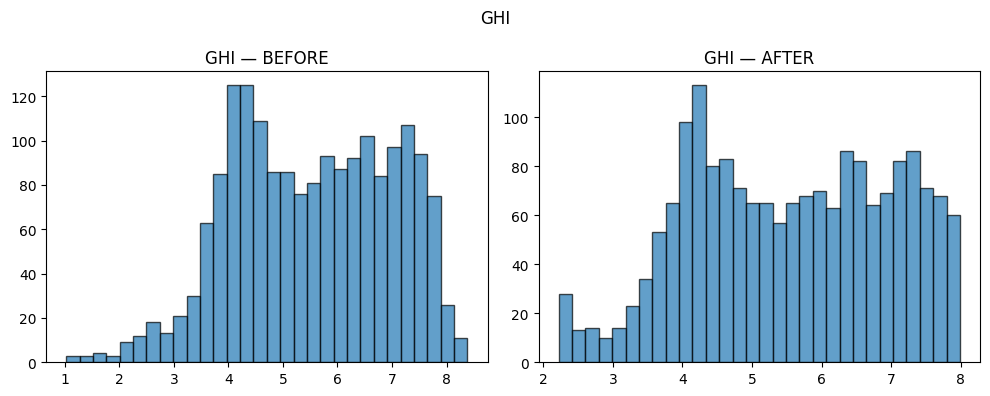

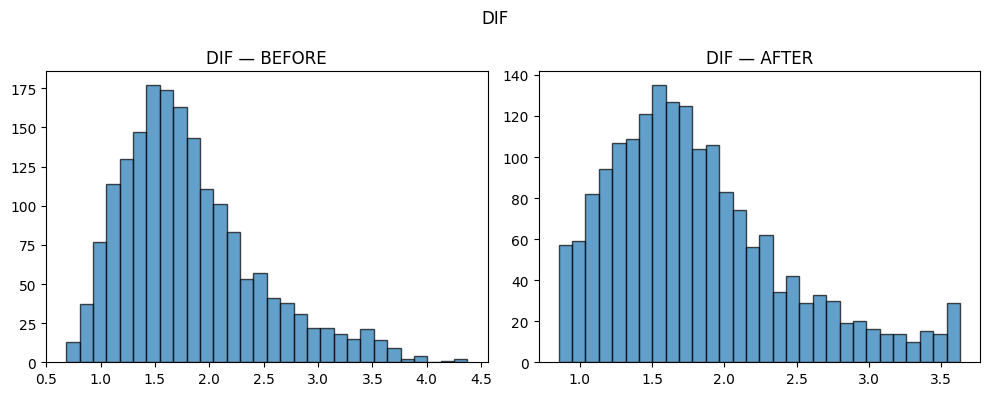

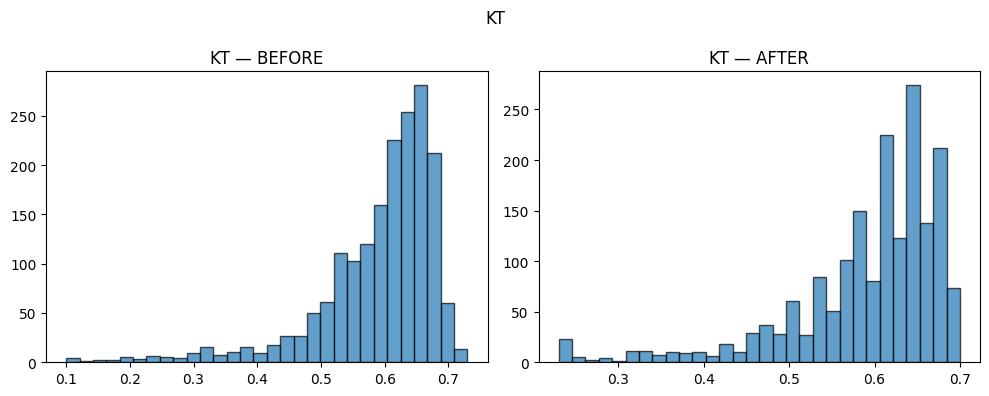

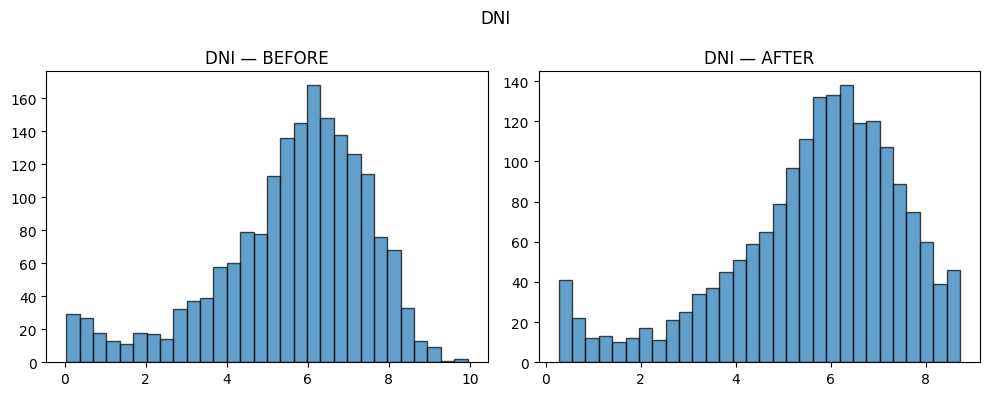

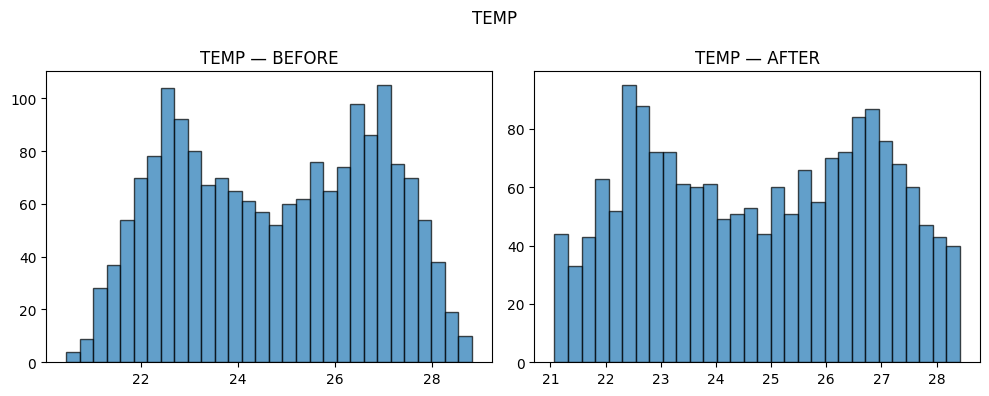

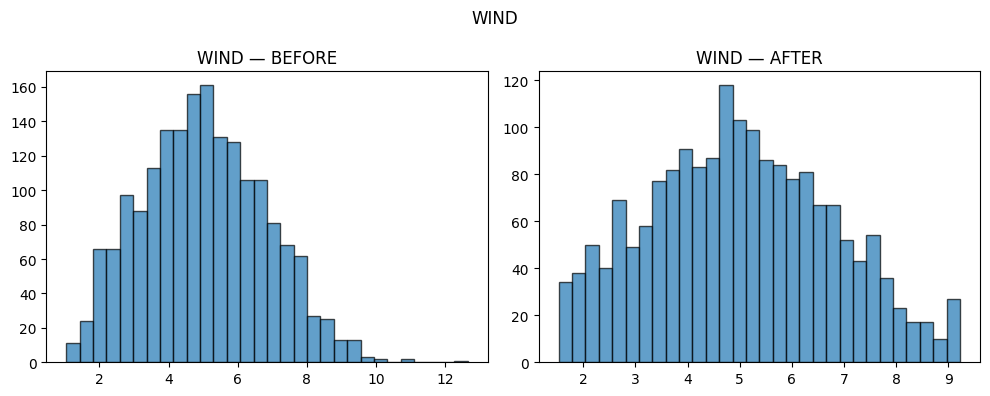

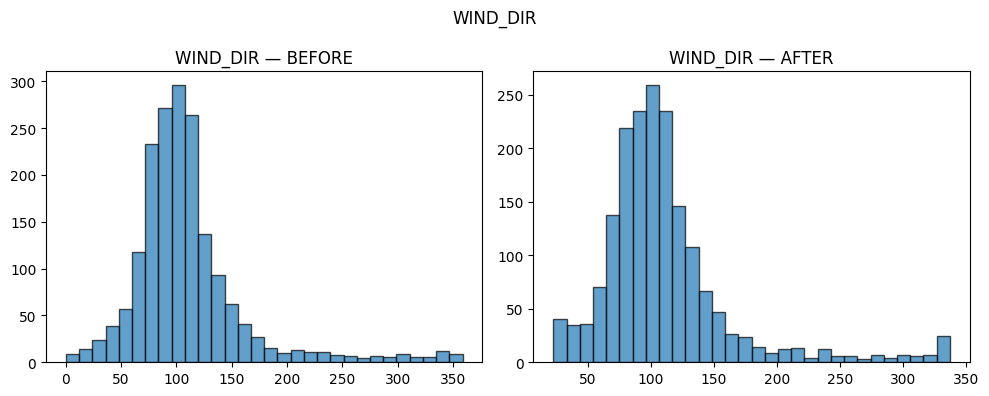

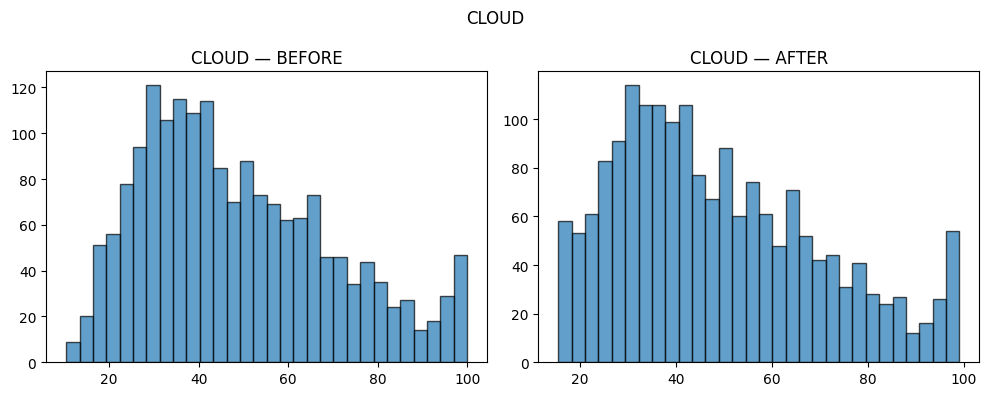

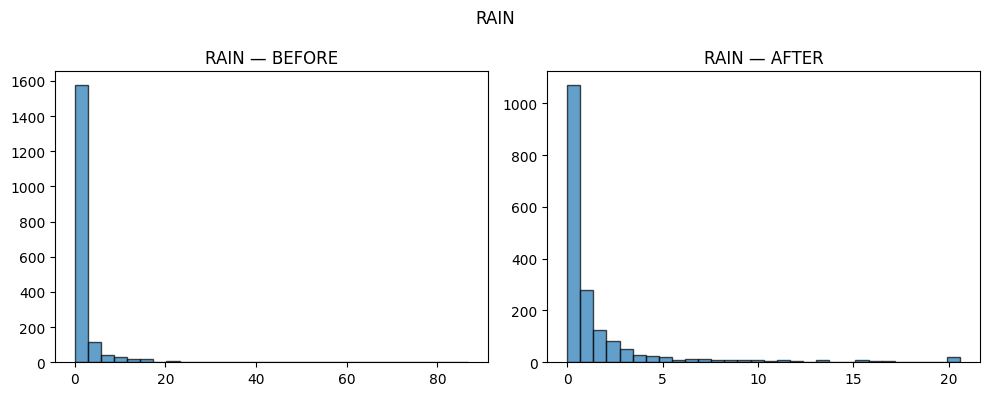

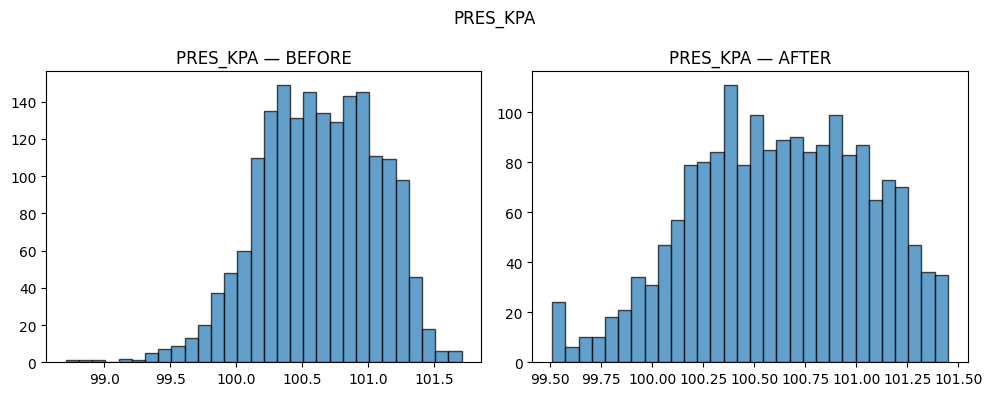

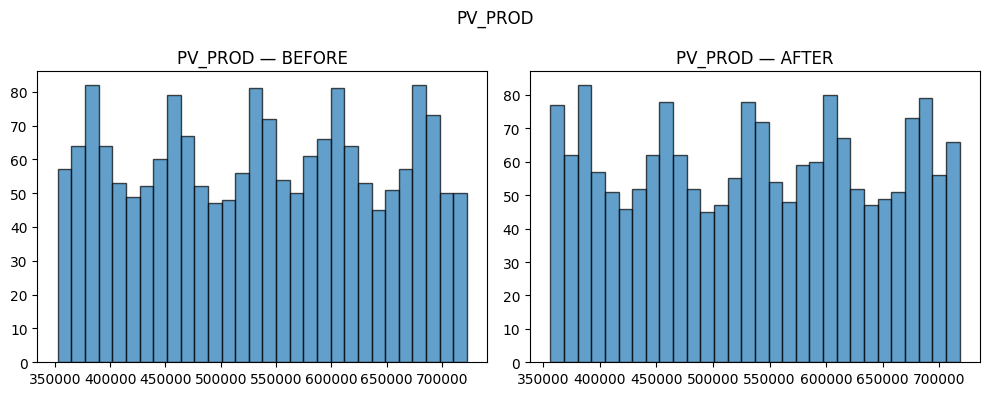

In [ ]:
#VISUALIZATION BEFORE AND AFTER CAPPING

def compare_histograms(df_before, df_after, cols, bins=30):
    for col in cols:
        fig, ax = plt.subplots(1, 2, figsize=(10,4))
        ax[0].hist(df_before[col].dropna(), bins=bins, alpha=0.7, edgecolor="black")
        ax[0].set_title(f"{col} - BEFORE")
        ax[1].hist(df_after[col].dropna(), bins=bins, alpha=0.7, edgecolor="black")
        ax[1].set_title(f"{col} - AFTER")
        fig.suptitle(col, fontsize=12)
        plt.tight_layout()
        plt.show()

compare_histograms(df, df_capped, VARS)


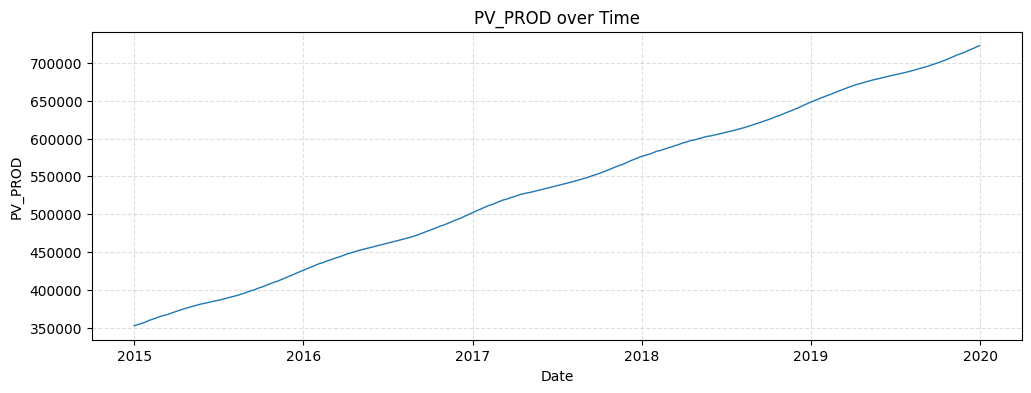

In [ ]:
# PV production over full time range
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df['date'], df[TARGET], linewidth=1.0)
ax.set_title(f"{TARGET} over Time")
ax.set_xlabel("Date")
ax.set_ylabel(TARGET)
ax.grid(True, linestyle='--', alpha=0.4)
save_or_show(fig, "ts_target")


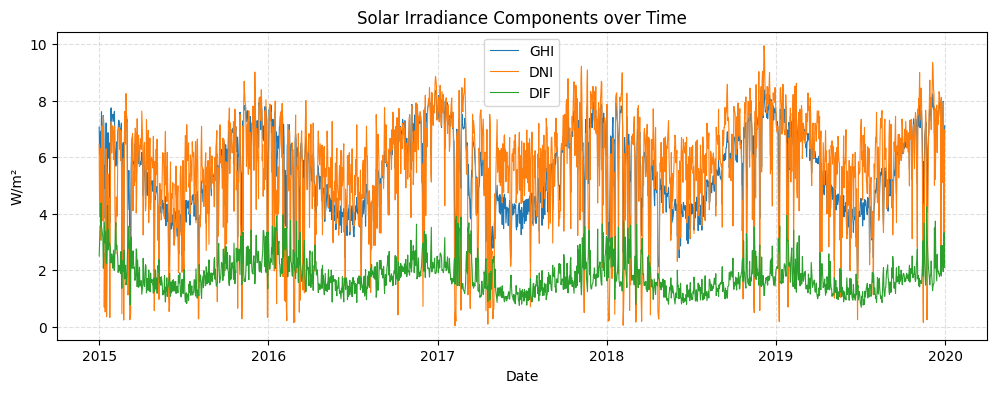

In [ ]:
# (2) Irradiance variables over time
fig, ax = plt.subplots(figsize=(12, 4))
for col in ['GHI','DNI','DIF']:
    if col in df.columns:
        ax.plot(df['date'], df[col], label=col, linewidth=0.8)
ax.set_title("Solar Irradiance Components over Time")
ax.set_xlabel("Date")
ax.set_ylabel("W/m²")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.4)
save_or_show(fig, "ts_irradiance")

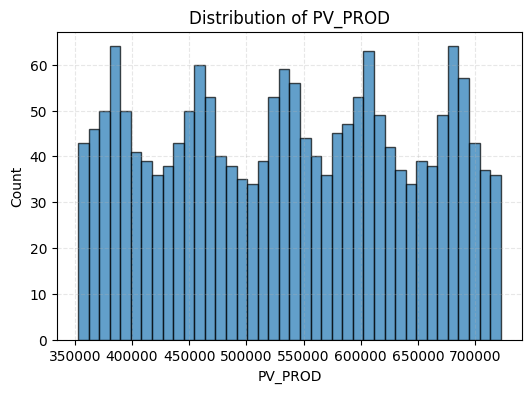

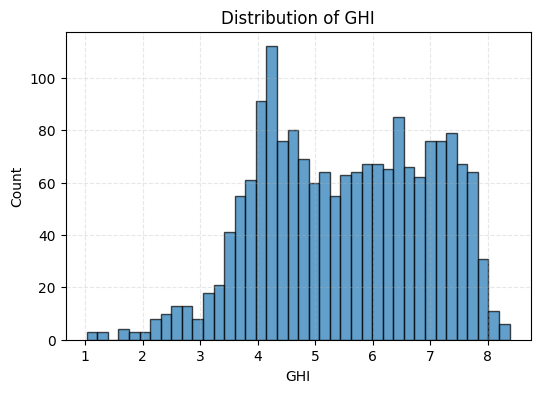

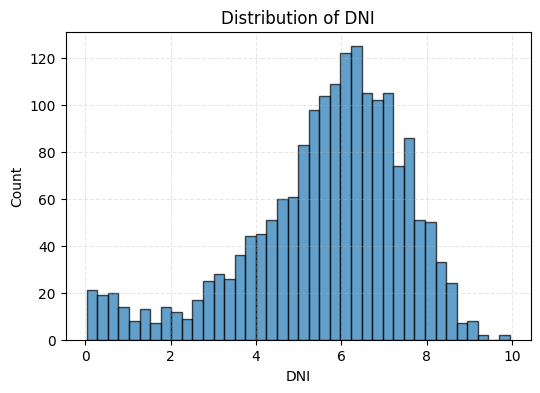

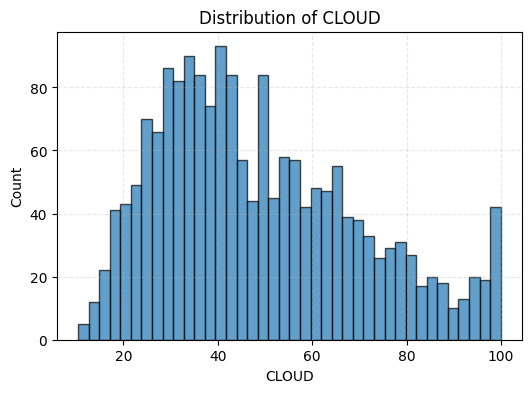

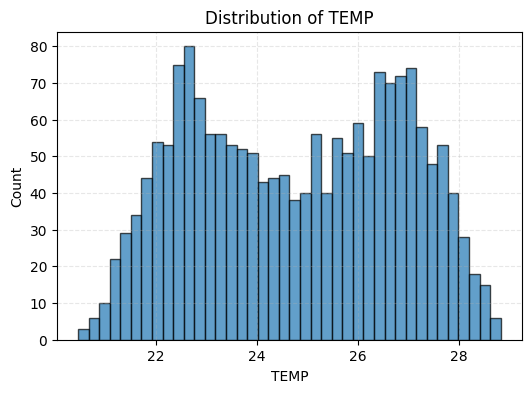

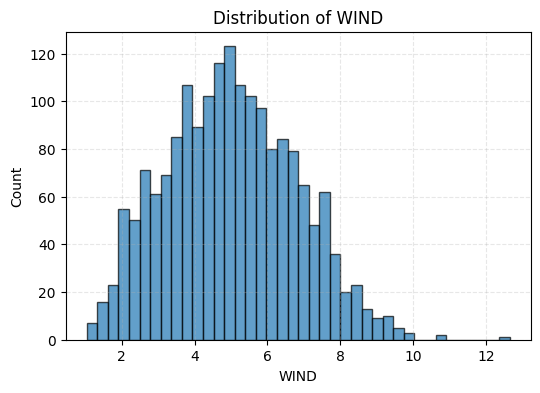

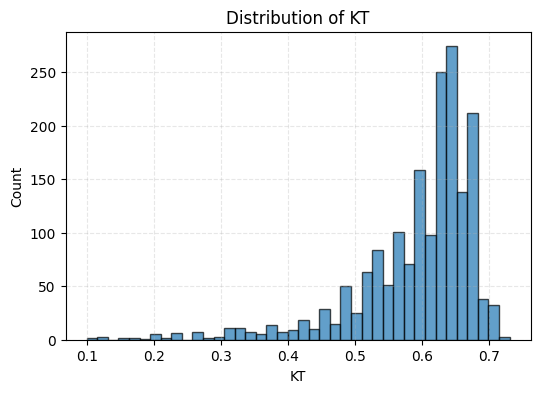

In [ ]:
# Histogram of target
hist_one(df[TARGET], f"Distribution of {TARGET}", "hist_target")

# Key predictors
for col in ['GHI','DNI','CLOUD','TEMP','WIND','KT']:
    if col in df.columns:
        hist_one(df[col], f"Distribution of {col}", f"hist_{col}")



# **Correlation-based feature selection**

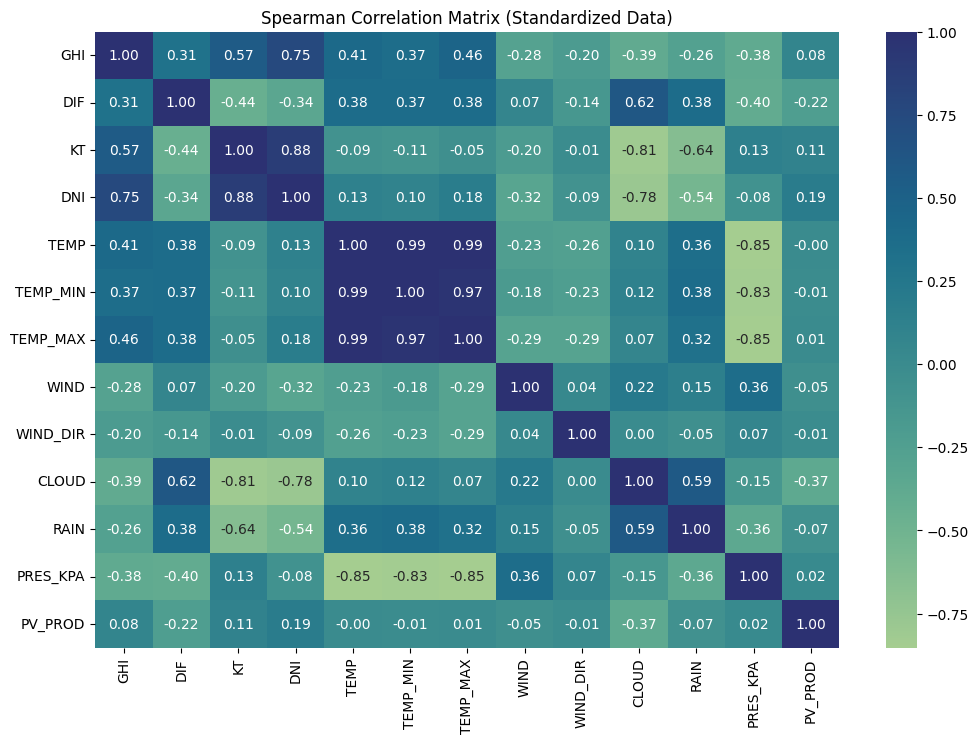

✅ Correlation matrices saved and plots generated successfully.


In [ ]:

# Parse and set datetime index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Spearman correlation after normalization
corr_spearman = df_scaled.corr(method='spearman')

# Plot scaled correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_spearman, annot=True, cmap='crest', fmt=".2f")
plt.title("Spearman Correlation Matrix (Standardized Data)")
plt.show()

#  Save correlation results

corr_pearson = df.corr(method='pearson')
corr_pearson.to_csv("Correlation_Pearson.csv")
corr_spearman.to_csv("Correlation_Spearman.csv")



In [ ]:
#Remove extra spaces and invisible characters
df.columns = df.columns.str.strip()


In [ ]:
print(df.columns.tolist())


['date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'TEMP_MIN', 'TEMP_MAX', 'WIND', 'WIND_DIR', 'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD']


In [ ]:
df=df_capped

# **Identifying Skewness**

Raw columns: ['date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'TEMP_MIN', 'TEMP_MAX', 'WIND', 'WIND_DIR', 'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD']

Name mapping (expected -> actual):
date                   -> date
GHI                    -> GHI
DIF                    -> DIF
KT                     -> KT
DNI                    -> DNI
TEMP                   -> TEMP
WIND                   -> WIND
WIND_DIR               -> WIND_DIR
CLOUD                  -> CLOUD
RAIN                   -> RAIN
PRES_KPA               -> PRES_KPA
PV_PROD                -> PV_PROD

Numeric features to plot: ['GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'WIND', 'WIND_DIR', 'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD']


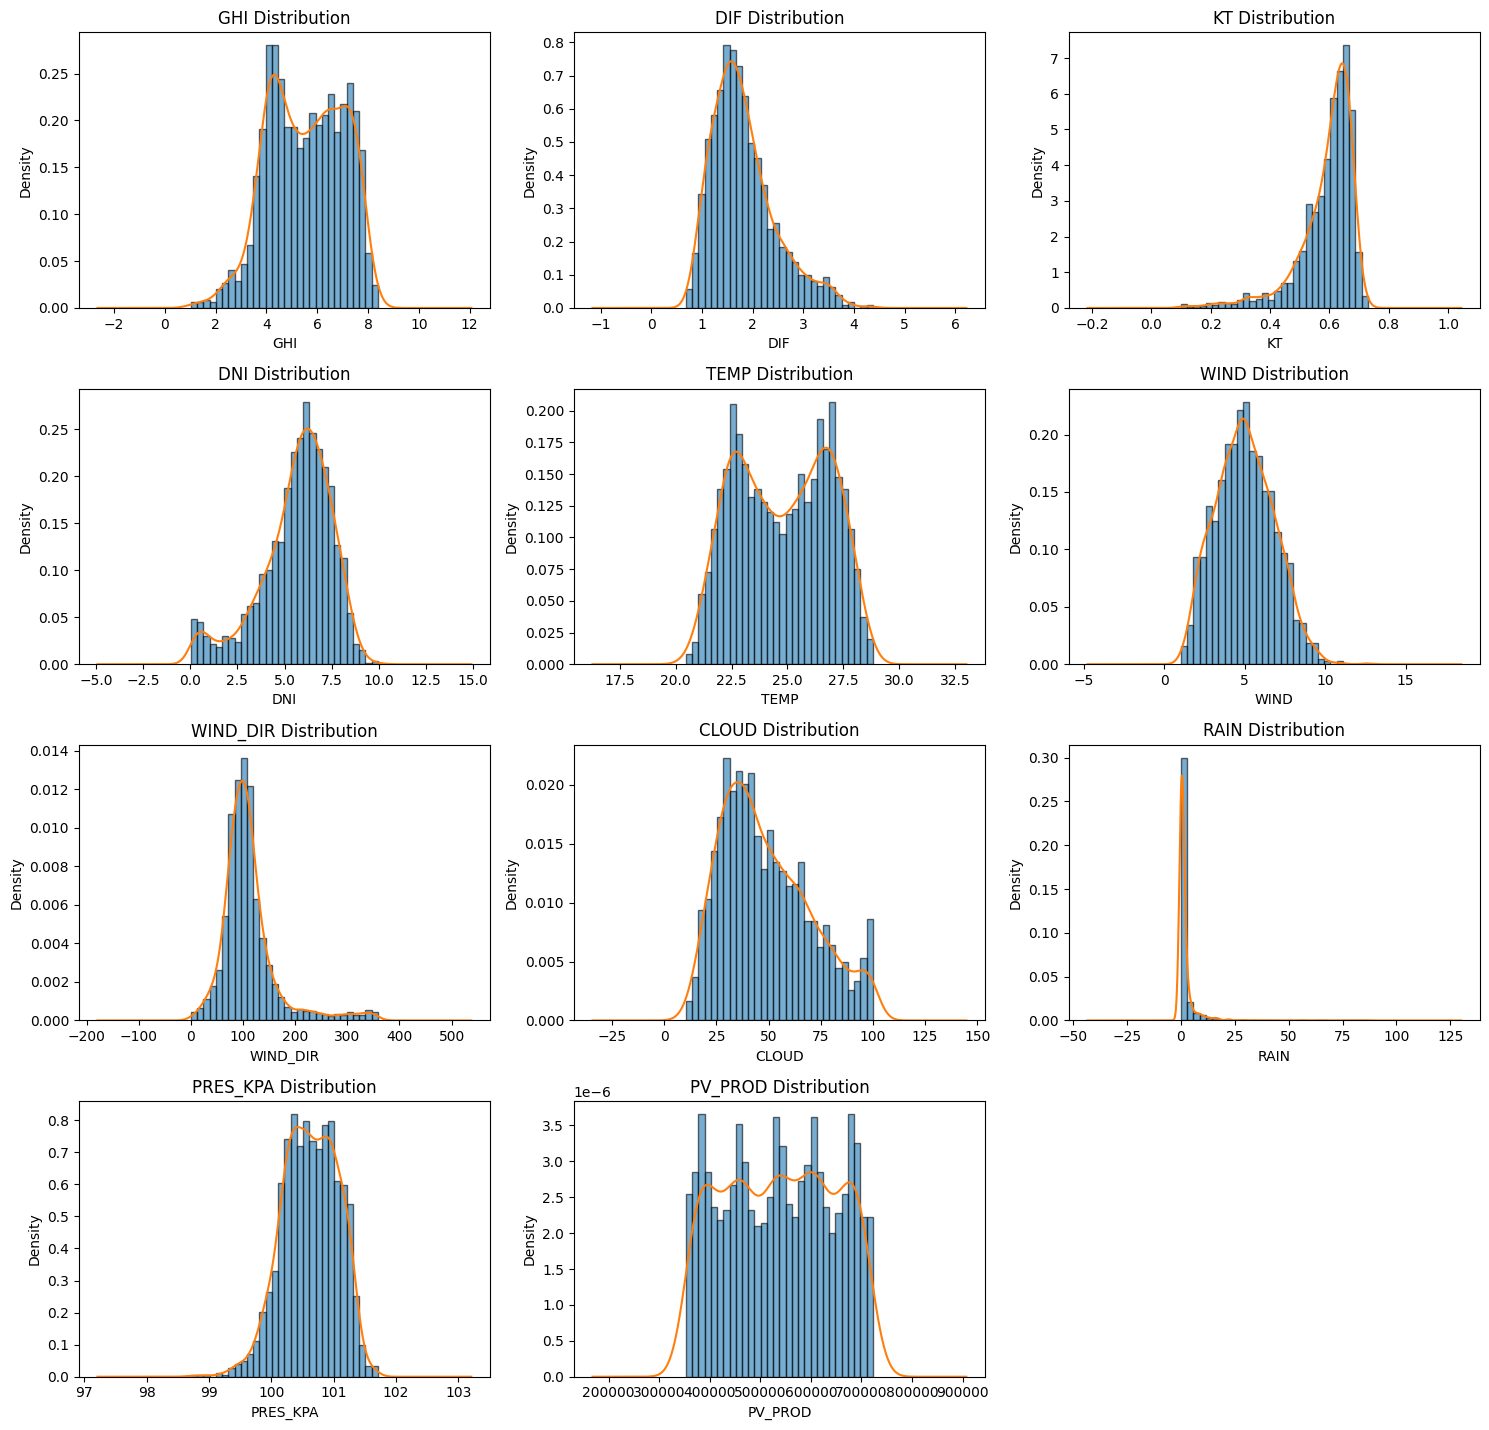


Skewness (>|1| ≈ heavy skew):
 RAIN        8.231803
WIND_DIR    2.102664
DIF         0.978771
CLOUD       0.593375
WIND        0.218882
PV_PROD    -0.010785
TEMP       -0.024781
GHI        -0.181199
PRES_KPA   -0.312879
DNI        -0.911250
KT         -1.957705
dtype: float64


In [ ]:
# Creates histograms with KDE overlays for each variable
# Helps detect skewness, spread, and outliers visually
# Inspect actual columns
print("Raw columns:", list(df.columns))

# Normalization helper (trim, lowercase, collapse spaces/underscores, drop non-alnum)
def normalize(name: str) -> str:
    s = str(name)
    s = s.strip().lower()
    s = re.sub(r'[\s\u00A0]+', '_', s)           # spaces (incl. non-breaking) - underscore
    s = re.sub(r'[_]+', '_', s)                  # collapse multiple underscores
    s = re.sub(r'[^a-z0-9_]', '', s)             # remove other punctuation
    return s

actual_cols = list(df.columns)
actual_norm = {normalize(c): c for c in actual_cols}  # normalized -> original

# Strip columns in-place (safe)
df.rename(columns={c: actual_norm.get(normalize(c), c) for c in actual_cols}, inplace=True)

# Expected feature names
expected = [
       'date','GHI', 'DIF','KT','DNI','TEMP','WIND', 'WIND_DIR','CLOUD','RAIN', 'PRES_KPA', 'PV_PROD'

      # Date is non-numeric and will be ignored in plotting
]

# Build a fuzzy mapping from expected - best actual
expected_norm = {e: normalize(e) for e in expected}
actual_norm_keys = list(actual_norm.keys())

mapped = {}
unmatched = []
for e, en in expected_norm.items():
    # exact normalized match first
    if en in actual_norm:
        mapped[e] = actual_norm[en]
        continue
    # fuzzy match
    candidates = difflib.get_close_matches(en, actual_norm_keys, n=1, cutoff=0.6)
    if candidates:
        mapped[e] = actual_norm[candidates[0]]
    else:
        unmatched.append(e)

print("\nName mapping (expected -> actual):")
for k, v in mapped.items():
    print(f"{k:22s} -> {v}")

if unmatched:
    print("\n Unmatched (not found even fuzzily):", unmatched)

# Rename df
rename_to_expected = {v: k for k, v in mapped.items()}
df.rename(columns=rename_to_expected, inplace=True)

# Select numeric columns among the expected set for plotting
numeric_features = [c for c in expected if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
print("\nNumeric features to plot:", numeric_features)

#Plot: histogram with KDE
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

n = len(numeric_features)
cols = 3
rows = int(np.ceil(n / cols)) if n else 1
plt.figure(figsize=(5*cols, 3.6*rows))

idx = 1
for col in numeric_features:
    plt.subplot(rows, cols, idx)
    s = pd.to_numeric(df[col], errors='coerce').dropna()
    if s.empty:
        plt.text(0.5, 0.5, f"No numeric data\nin {col}", ha='center', va='center')
        plt.axis('off')
    else:

        s.plot(kind='hist', bins=30, alpha=0.6, edgecolor='black', density=True)

        if s.nunique() > 1:
            s.plot(kind='kde')
        plt.title(f"{col} Distribution")
        plt.xlabel(col)
        plt.ylabel("Density")
    idx += 1

plt.tight_layout()
plt.show()

# 7. skewness report to check heavy skew
skew_report = pd.Series({c: pd.to_numeric(df[c], errors='coerce').dropna().skew()
                         for c in numeric_features}).sort_values(ascending=False)
print("\nSkewness (>|1| ≈ heavy skew):\n", skew_report)


 **5. Transformation**

Helps to understand if any features are heavily skewed or need **Transformation for continues variables** (log transformation - to remove noise, it drops outliers)

In [ ]:

# Helpers

EPS = 1e-6  # for clipping in logit

def logit01(x, eps=EPS):
    x = np.clip(x, eps, 1 - eps)
    return np.log(x / (1 - x))

def asinh(x):
    return np.arcsinh(x)

def best_skew_transform(series: pd.Series, candidates=("identity","log1p","sqrt","asinh","yeojohnson")):


    #Returns -name, transformed_series_aligned, skew_before, skew_after

    s = pd.to_numeric(series, errors='coerce').dropna()
    if s.empty:
        out = pd.Series(index=series.index, dtype=float)
        return "identity", out, float("nan"), float("nan")

    skew_before = float(s.skew())
    best = ("identity", s, abs(skew_before))

    yj = PowerTransformer(method="yeo-johnson", standardize=False)

    for name in candidates:
        if name == "identity":
            t = s
        elif name == "log1p":
            if (s < 0).any():  # log1p requires non-negative
                continue
            t = np.log1p(s)
        elif name == "sqrt":
            if (s < 0).any():
                continue
            t = np.sqrt(s)
        elif name == "asinh":
            t = asinh(s)
        elif name == "yeojohnson":
            t = pd.Series(yj.fit_transform(s.values.reshape(-1,1)).ravel(), index=s.index)
        else:
            continue
        skew_after = float(t.skew())
        if abs(skew_after) < best[2]:
            best = (name, t, abs(skew_after))

    name, t, _ = best
    out = pd.Series(index=series.index, dtype=float)
    out.loc[t.index] = t.values
    return name, out, skew_before, float(out.skew())

def choose_candidates(skew_value):

    #Pick a candidate set based on skew sign/magnitude.

    if np.isnan(skew_value):
        return ("identity","yeojohnson","asinh")
    if skew_value > 1.0:               # heavy right
        return ("log1p","sqrt","asinh","yeojohnson")
    if 0.5 < skew_value <= 1.0:        # moderate right
        return ("identity","sqrt","asinh","yeojohnson")
    if skew_value < -1.0:              # heavy left
        return ("identity","asinh","yeojohnson")
    if -1.0 <= skew_value < -0.5:      # moderate left
        return ("identity","asinh","yeojohnson")
    # mild or near-zero
    return ("identity","asinh","yeojohnson")


# Main transform function

def fix_transforms_with_skew(df: pd.DataFrame, skewness: pd.Series):

    dfm = df.copy()
    report = []
    FEATURES = []

    # 1. WIND_DIR: circular → sin/cos
    if "WIND_DIR" in dfm.columns:
        theta = np.deg2rad(pd.to_numeric(dfm["WIND_DIR"], errors="coerce"))
        dfm["WIND_DIR__sin"] = np.sin(theta)
        dfm["WIND_DIR__cos"] = np.cos(theta)
        FEATURES += ["WIND_DIR__sin","WIND_DIR__cos"]
        report.append(("WIND_DIR","→ sin/cos", float(pd.to_numeric(dfm["WIND_DIR"], errors="coerce").skew()), float(pd.concat([dfm["WIND_DIR__sin"], dfm["WIND_DIR__cos"]], axis=1).skew().mean())))

    # 2. KT ∈ (0,1): heavy left - logit
    if "KT" in dfm.columns:
        dfm["KT__logit"] = logit01(pd.to_numeric(dfm["KT"], errors="coerce"))
        FEATURES.append("KT__logit")
        report.append(("KT","→ logit", float(pd.to_numeric(dfm["KT"], errors="coerce").skew()), float(pd.to_numeric(dfm["KT__logit"], errors="coerce").skew())))

    # 3. Zero-inflated / irradiance & wind & rain → pick best transform if skew suggests benefit
    candidate_cols = [c for c in ["RAIN","DNI","DIF","GHI","WIND"] if c in dfm.columns]
    suffix_map = {"identity":"__id","log1p":"__log1p","sqrt":"__sqrt","asinh":"__asinh","yeojohnson":"__yj"}

    for col in candidate_cols:
        sk = float(skewness.get(col, np.nan))
        cands = choose_candidates(sk)
        name, t, sb, sa = best_skew_transform(dfm[col], candidates=cands)
        new_col = f"{col}{suffix_map[name]}"
        dfm[new_col] = t
        FEATURES.append(new_col)
        report.append((col, f"best={name} (by skew {sk:.3f})", sb, sa))

    # 4. Keep normally distributed originals
    for col in ["TEMP_MIN","TEMP","TEMP_MAX","PRES_KPA","CLOUD"]:
        if col in dfm.columns:
            FEATURES.append(col)

            if f"{col}__log" in dfm.columns:
                report.append((col, "drop log (kept original)", float(pd.to_numeric(dfm[col], errors="coerce").skew()), float(pd.to_numeric(dfm[col], errors="coerce").skew())))

    # 5. Build report
    rep = pd.DataFrame(report, columns=["feature","action","skew_before","skew_after"])
    if not rep.empty:
        rep["|skew_before|"] = rep["skew_before"].abs().round(4)
        rep["|skew_after|"]  = rep["skew_after"].abs().round(4)
        rep = rep.sort_values("|skew_after|", ascending=False)

    # 6. Deduplicate FEATURES preserving order
    seen = set()
    FEATURES = [c for c in FEATURES if not (c in seen or seen.add(c))]

    return dfm, rep, FEATURES


In [ ]:
# measured skewness with index column names
sk = pd.Series({
    "RAIN":        8.231803,
    "WIND_DIR":    2.102664,
    "DIF":         0.978771,
    "CLOUD":       0.593375,
    "WIND":        0.218882,
    "PV_PROD":    -0.010785,
    "TEMP":       -0.024781,
    "GHI":        -0.181199,
    "PRES_KPA":   -0.312879,
    "DNI":        -0.911250,
    "KT":         -1.957705
})

df_fixed, transform_report, FEATURES = fix_transforms_with_skew(df, skewness=sk)

print("Recommended FEATURES:")
print(FEATURES)

print("\nTransform decisions & skew improvement:")
if transform_report is not None and not transform_report.empty:
    print(transform_report.to_string(index=False))
else:
    print("No transforms applied.")


📋 Recommended FEATURES:
['WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj', 'TEMP_MIN', 'TEMP', 'TEMP_MAX', 'PRES_KPA', 'CLOUD']

📊 Transform decisions & skew improvement:
 feature                           action  skew_before  skew_after  |skew_before|  |skew_after|
      KT                          → logit    -1.957705   -2.211423         1.9577        2.2114
WIND_DIR                        → sin/cos     2.102664   -1.158860         2.1027        1.1589
    RAIN  best=yeojohnson (by skew 8.232)     8.231803    0.383920         8.2318        0.3839
     DNI best=yeojohnson (by skew -0.911)    -0.911250   -0.204253         0.9113        0.2043
     GHI best=yeojohnson (by skew -0.181)    -0.181199   -0.082254         0.1812        0.0823
    WIND  best=yeojohnson (by skew 0.219)     0.218882   -0.034918         0.2189        0.0349
     DIF  best=yeojohnson (by skew 0.979)     0.978771    0.024253         0.9788        0.0243


In [ ]:
print(df_fixed)


           date     GHI     DIF    KT     DNI   TEMP  TEMP_MIN  TEMP_MAX  \
0    2015-01-01  7.0598  2.5039  0.60  6.4490  27.68     26.75     28.46   
1    2015-01-02  6.1032  3.0595  0.52  3.8815  27.64     26.54     28.84   
2    2015-01-03  6.1198  3.5405  0.52  3.9139  28.10     27.08     29.30   
3    2015-01-04  6.9089  3.5950  0.59  6.3065  28.41     27.58     29.38   
4    2015-01-05  6.2345  4.3742  0.53  3.0552  28.61     27.94     29.48   
...         ...     ...     ...   ...     ...    ...       ...       ...   
1815 2019-12-27  6.9310  2.2522  0.59  6.0410  27.17     26.48     27.99   
1816 2019-12-28  7.9733  1.9486  0.68  7.9289  27.12     26.49     27.76   
1817 2019-12-29  5.8663  3.1951  0.50  3.2525  26.71     26.15     27.23   
1818 2019-12-30  5.5754  3.3276  0.47  3.1426  26.76     26.17     27.43   
1819 2019-12-31  7.1107  2.0964  0.60  6.9703  26.87     26.47     27.27   

      WIND  WIND_DIR  ...  PRES_KPA   PV_PROD  WIND_DIR__sin  WIND_DIR__cos  \
0     1.

In [ ]:
df=df_fixed

Found 8 before–after pairs:
  GHI → GHI__yj
  WIND → WIND__yj
  KT → KT__logit
  WIND_DIR → WIND_DIR__sin
  RAIN → RAIN__yj
  WIND_DIR → WIND_DIR__cos
  DIF → DIF__yj
  DNI → DNI__yj


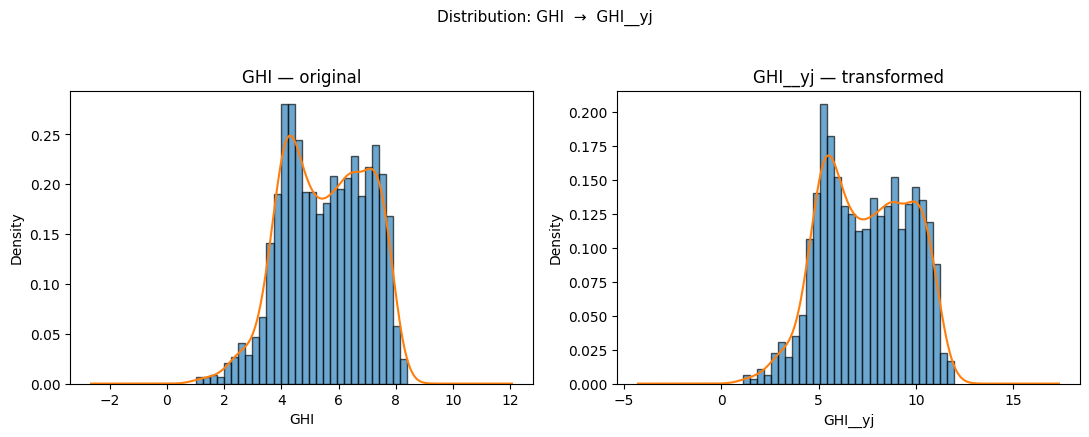

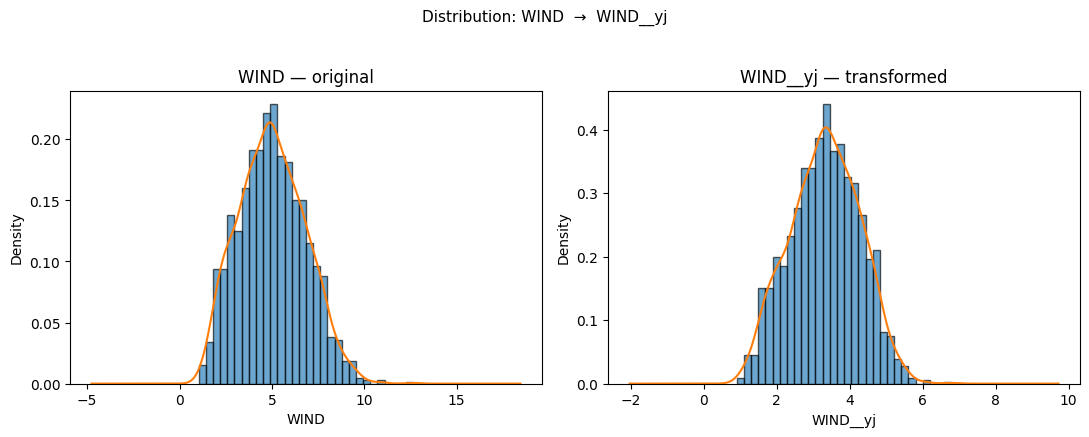

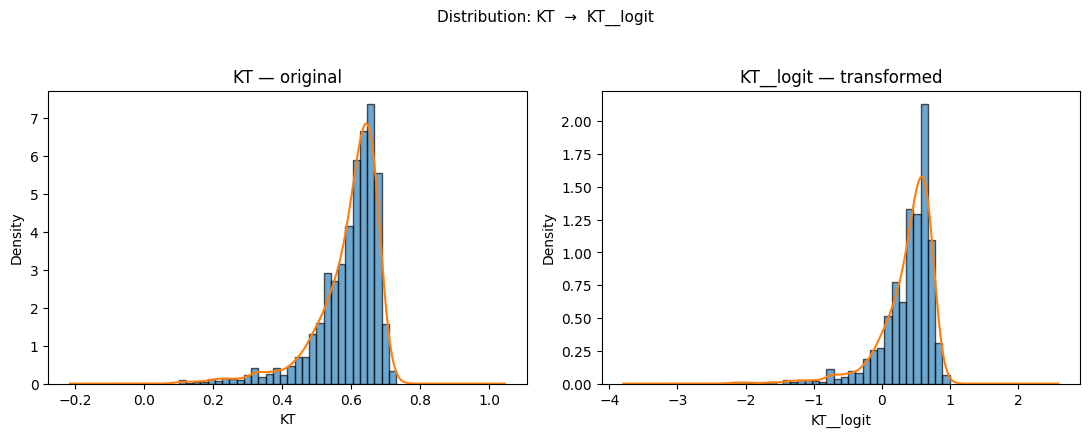

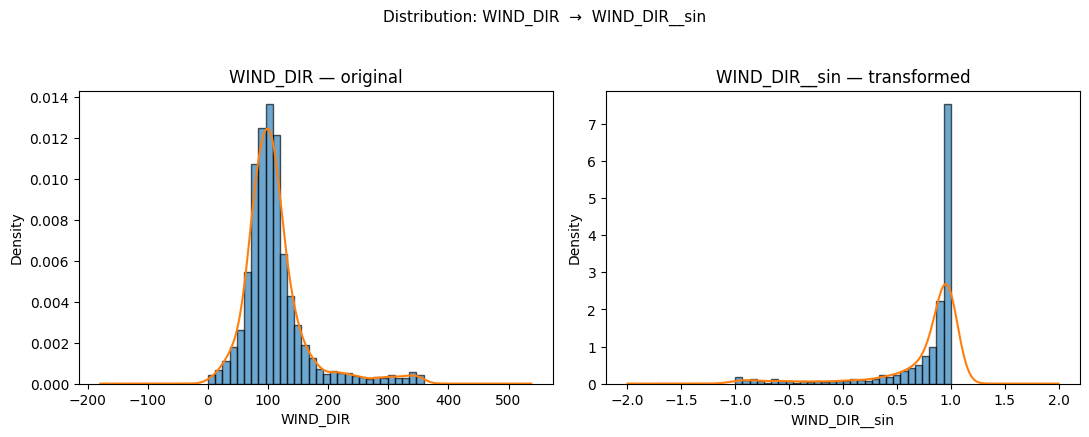

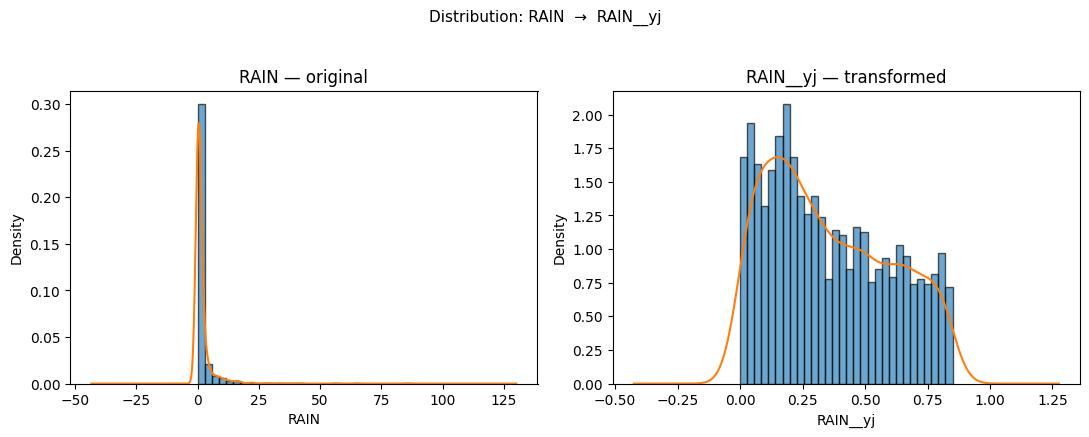

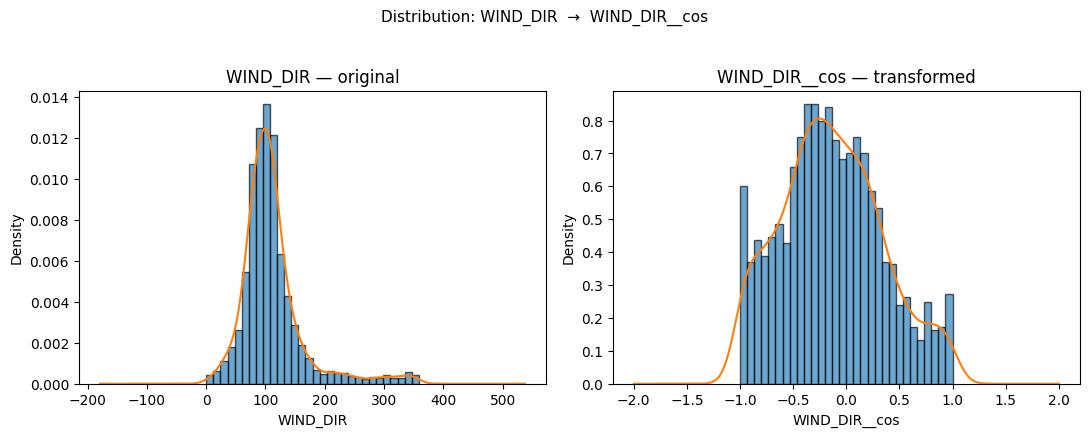

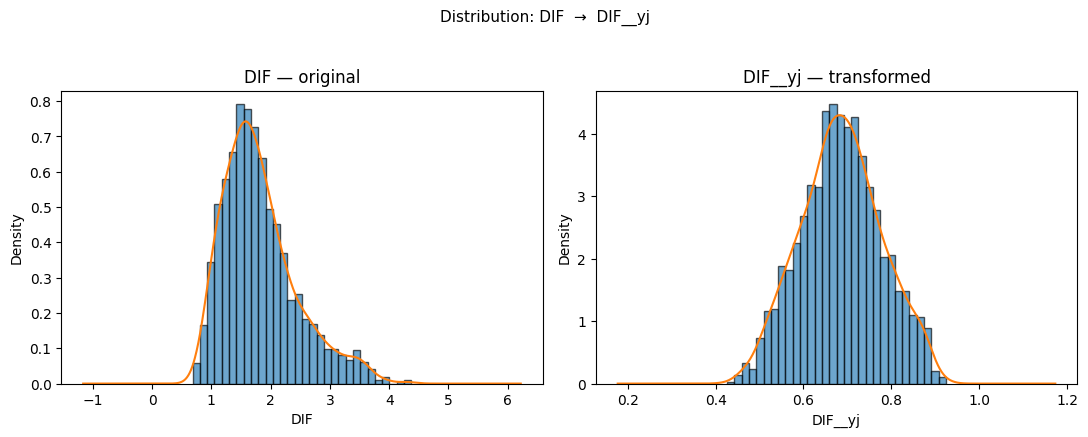

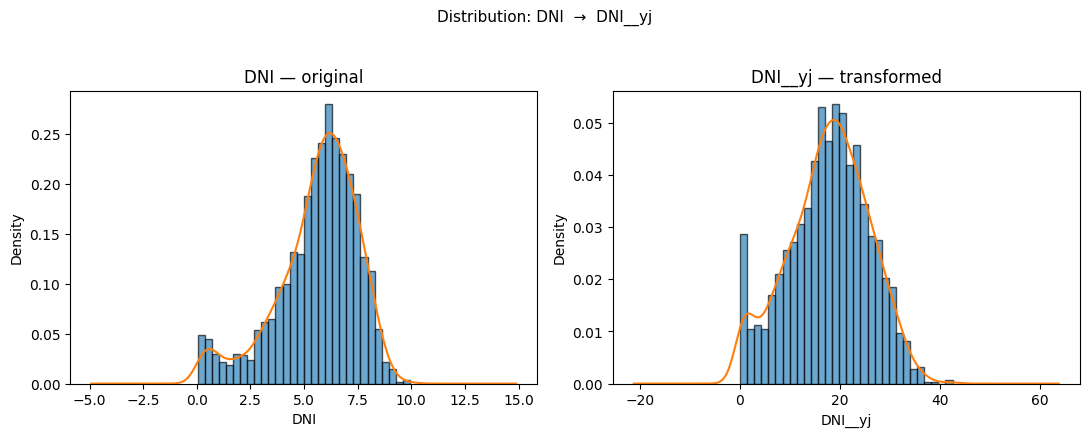

Skewness (before vs after):
 feature   transformed  skew_before  skew_after
WIND_DIR WIND_DIR__sin     2.102664   -2.580940
      KT     KT__logit    -1.957705   -2.211423
    RAIN      RAIN__yj     8.231803    0.383920
WIND_DIR WIND_DIR__cos     2.102664    0.263220
     DNI       DNI__yj    -0.911250   -0.204253
     GHI       GHI__yj    -0.181199   -0.082254
    WIND      WIND__yj     0.218882   -0.034918
     DIF       DIF__yj     0.978771    0.024253


In [ ]:

# 1. Configuration

# Suffixes that indicate transformed columns in the dataset
TRANSFORM_SUFFIXES = ("__yj", "__logit","__sin","__cos")

# Features
FEATURES_ALL = [ 'WIND_DIR__sin', 'WIND_DIR__cos',
                'KT__logit', 'RAIN__yj', 'DNI__yj',
                 'DIF__yj', 'GHI__yj', 'WIND__yj',
                 'TEMP_MIN', 'TEMP', 'TEMP_MAX', 'PRES_KPA', 'CLOUD'


]

# 2. Utility: build original, transformed pairs automatically

def find_before_after_pairs(FEATURES, features_all, suffixes=TRANSFORM_SUFFIXES):
    """
    Return a list of (base, transformed) column name pairs
    discovered from the dataframe using the given suffixes.
    """
    cols = set(FEATURES.columns)
    pairs = []

    # A. If a column ends with any known suffix, try to map back to base
    for c in cols:
        for suf in suffixes:
            if c.endswith(suf):
                base = c[: -len(suf)]
                if base in cols:
                    pairs.append((base, c))
                break

    # B. to ensure any explicitly listed base/transformed pairs from FEATURES_ALL are included
    for name in features_all:
        for suf in suffixes:
            if name.endswith(suf):
                base = name[: -len(suf)]
                if base in cols and name in cols and (base, name) not in pairs:
                    pairs.append((base, name))

    # Duplicate while preserving order
    seen = set()
    unique_pairs = []
    for p in pairs:
        if p not in seen:
            seen.add(p)
            unique_pairs.append(p)

    return unique_pairs

pairs = find_before_after_pairs(df, FEATURES_ALL)
if not pairs:
    print("No (original, transformed) pairs found. Check your column names & suffixes.")

# 3. Plot- before vs after histograms (with KDE)

def plot_before_after_histograms(df, pairs, bins=30):

    #For each (base, transformed) pair, draw side-by-side histograms with KDE.
    #Skips if data is missing or non-numeric.

    for base, transformed in pairs:
        s0 = pd.to_numeric(df[base], errors='coerce').dropna()
        s1 = pd.to_numeric(df[transformed], errors='coerce').dropna()

        if s0.empty or s1.empty:
            print(f"Skipping {base} → {transformed}: insufficient numeric data.")
            continue

        fig, axes = plt.subplots(1, 2, figsize=(11, 4.2))

        # Original
        axes[0].hist(s0, bins=bins, density=True, alpha=0.65, edgecolor='black')
        if s0.nunique() > 1:
            s0.plot(kind='kde', ax=axes[0])
        axes[0].set_title(f"{base} — original")
        axes[0].set_xlabel(base)
        axes[0].set_ylabel("Density")

        # Transformed
        axes[1].hist(s1, bins=bins, density=True, alpha=0.65, edgecolor='black')
        if s1.nunique() > 1:
            s1.plot(kind='kde', ax=axes[1])
        axes[1].set_title(f"{transformed} — transformed")
        axes[1].set_xlabel(transformed)
        axes[1].set_ylabel("Density")

        fig.suptitle(f"Distribution: {base}  →  {transformed}", y=1.03, fontsize=11)
        fig.tight_layout()
        plt.show()

# 4. Boxplots to see outliers

def plot_before_after_boxplots(df, pairs):

    for base, transformed in pairs:
        s0 = pd.to_numeric(df[base], errors='coerce').dropna()
        s1 = pd.to_numeric(df[transformed], errors='coerce').dropna()

        if s0.empty or s1.empty:
            print(f"Skipping {base} → {transformed}: insufficient numeric data.")
            continue

        fig, ax = plt.subplots(figsize=(7, 4.2))
        ax.boxplot([s0.values, s1.values], vert=True, labels=[base, transformed], showfliers=True)
        ax.set_title(f"Boxplots: {base}  →  {transformed}")
        ax.set_ylabel("Value")
        fig.tight_layout()
        plt.show()

# 5. Skewness report before vs after

def skewness_report(df, pairs):
    rows = []
    for base, transformed in pairs:
        s0 = pd.to_numeric(df[base], errors='coerce').dropna()
        s1 = pd.to_numeric(df[transformed], errors='coerce').dropna()
        if s0.empty or s1.empty:
            continue
        rows.append({
            "feature": base,
            "transformed": transformed,
            "skew_before": s0.skew(),
            "skew_after": s1.skew()
        })
    if rows:
        rep = pd.DataFrame(rows).sort_values(by="skew_after", key=lambda x: x.abs(), ascending=False)
        print("Skewness (before vs after):")
        print(rep.to_string(index=False))
    else:
        print("No numeric data to compute skewness.")

# 6. Run the visualizations

print(f"Found {len(pairs)} before–after pairs:")
for b, t in pairs:
    print(f"  {b} → {t}")

# Histograms + KDE
plot_before_after_histograms(df, pairs, bins=30)

# Boxplots
plot_before_after_boxplots(df, pairs)

# skewness table
skewness_report(df, pairs)


In [ ]:
print(df.columns.to_list())

['date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'TEMP_MIN', 'TEMP_MAX', 'WIND', 'WIND_DIR', 'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD', 'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj']


In [ ]:

ALL_VARS = ['date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP',
            'TEMP_MIN', 'TEMP_MAX', 'WIND', 'WIND_DIR',
            'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD',
            'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj',
            'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj']



# Identify transformed variables
transformed_cols = [
    c for c in ALL_VARS
    if "__" in c or c.endswith(("logit", "yj", "sqrt", "asinh"))
]

# Identify originals that should be kept (not transformed, not wind_dir raw)
original_keep = [
    c for c in ALL_VARS
    if c not in transformed_cols and c not in ["WIND_DIR"]  # drop raw wind_dir
]

# Final selected columns in order
FINAL_COLS = ['date'] + original_keep + transformed_cols

# Ensure only columns that exist in df are included
FINAL_COLS = [c for c in FINAL_COLS if c in df.columns]

# Create the final modeling DataFrame
df_model = df[FINAL_COLS].copy()

print("Final dataset columns:", len(df_model.columns))
print(df_model.columns.tolist())
df_model.head()


✅ Final dataset columns: 22
['date', 'date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'TEMP_MIN', 'TEMP_MAX', 'WIND', 'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD', 'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj']


date       date     GHI     DIF    KT     DNI   TEMP  TEMP_MIN  \
0 2015-01-01 2015-01-01  7.0598  2.5039  0.60  6.4490  27.68     26.75   
1 2015-01-02 2015-01-02  6.1032  3.0595  0.52  3.8815  27.64     26.54   
2 2015-01-03 2015-01-03  6.1198  3.5405  0.52  3.9139  28.10     27.08   
3 2015-01-04 2015-01-04  6.9089  3.5950  0.59  6.3065  28.41     27.58   
4 2015-01-05 2015-01-05  6.2345  4.3742  0.53  3.0552  28.61     27.94   

   TEMP_MAX  WIND  ...  PRES_KPA   PV_PROD  WIND_DIR__sin  WIND_DIR__cos  \
0     28.46  1.75  ...     99.97  352787.0       0.202787       0.979223   
1     28.84  2.40  ...    100.06  352936.0       0.822144       0.569280   
2     29.30  3.91  ...    100.03  353113.0       0.768284       0.640110   
3     29.38  4.29  ...     99.92  353360.0       0.498488       0.866897   
4     29.48  3.90  ...     99.82  353563.0       0.356738       0.934204   

   KT__logit  RAIN__yj    DNI__yj   DIF__yj   GHI__yj  WIND__yj  
0   0.405465  0.620116  20.807769  0.791474  9.764848  1.424625  
1   0.080043  0.557933   9.332262  0.842379  8.243245  1.859916  
2   0.080043  0.318663   9.452191  0.877284  8.269268  2.769527  
3   0.363965  0.666737  20.068565  0.880822  9.521928  2.981703  
4   0.120144  0.781193   6.496924  0.924271  8.449458  2.763865  

[5 rows x 22 columns]

In [ ]:
print(df_model.columns.to_list())

['date', 'date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'TEMP_MIN', 'TEMP_MAX', 'WIND', 'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD', 'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj']


In [ ]:
# Remove duplicated columns inside df_model itself
df_model = df_model.loc[:, ~df_model.columns.duplicated()].copy()


In [ ]:

cols = ['date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'TEMP_MIN', 'TEMP_MAX',
    'WIND', 'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD',
    'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj',
    'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj'
]

# Remove duplicates while keeping order
cols = list(dict.fromkeys(cols))

# Subset the DataFrame
df = df_model[cols].copy()

print(df.columns.to_list())



['date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'TEMP_MIN', 'TEMP_MAX', 'WIND', 'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD', 'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj']


# **7. Feature Engineering**
For time-series prediction, to create additional features that help capture temporal dependencies.


**7.1 Create Lag Features**

Extract temporal relationships from the transformed data before normalization.
Lags depend on original numeric scales shouldn’t be scaled first, because scaling changes the absolute magnitude (which affects differences and rolling averages).

In [ ]:
# Orde time
df = df.sort_values(by="date").reset_index(drop=True)

# Columns that exist in  df
features = ['date', 'GHI', 'DIF', 'KT', 'DNI',
            'TEMP', 'TEMP_MIN', 'TEMP_MAX', 'WIND',
            'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD',
            'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit',
            'RAIN__yj', 'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj'
            ]


# Create 1-day lag features
for col in features:
    df[f"{col}_lag1"] = df[col].shift(1)

# Define the 1-day ahead target
df["target_next_day"] = df["GHI"].shift(-1)

# Drop rows made NaN by shifting
df_model = df.dropna().reset_index(drop=True)

# 5) Quick check
print("Prepared DataFrame for 1-day-ahead forecasting")
print("Shape:", df_model.shape)
print("Sample columns:", df_model.columns[:12].tolist(), "...")
print(df_model.head())


✅ Prepared DataFrame for 1-day-ahead forecasting
Shape: (1818, 43)
Sample columns: ['date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'TEMP_MIN', 'TEMP_MAX', 'WIND', 'CLOUD', 'RAIN', 'PRES_KPA'] ...
        date     GHI     DIF    KT     DNI   TEMP  TEMP_MIN  TEMP_MAX  WIND  \
0 2015-01-02  6.1032  3.0595  0.52  3.8815  27.64     26.54     28.84  2.40   
1 2015-01-03  6.1198  3.5405  0.52  3.9139  28.10     27.08     29.30  3.91   
2 2015-01-04  6.9089  3.5950  0.59  6.3065  28.41     27.58     29.38  4.29   
3 2015-01-05  6.2345  4.3742  0.53  3.0552  28.61     27.94     29.48  3.90   
4 2015-01-06  7.6102  3.5537  0.65  5.4535  28.78     27.92     29.67  3.11   

   CLOUD  ...  PV_PROD_lag1  WIND_DIR__sin_lag1  WIND_DIR__cos_lag1  \
0  84.73  ...      352787.0            0.202787            0.979223   
1  88.30  ...      352936.0            0.822144            0.569280   
2  74.22  ...      353113.0            0.768284            0.640110   
3  94.43  ...      353360.0            0.498488  

In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818 entries, 0 to 1817
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1818 non-null   datetime64[ns]
 1   GHI                 1818 non-null   float64       
 2   DIF                 1818 non-null   float64       
 3   KT                  1818 non-null   float64       
 4   DNI                 1818 non-null   float64       
 5   TEMP                1818 non-null   float64       
 6   TEMP_MIN            1818 non-null   float64       
 7   TEMP_MAX            1818 non-null   float64       
 8   WIND                1818 non-null   float64       
 9   CLOUD               1818 non-null   float64       
 10  RAIN                1818 non-null   float64       
 11  PRES_KPA            1818 non-null   float64       
 12  PV_PROD             1818 non-null   float64       
 13  WIND_DIR__sin       1818 non-null   float64     

**7.2. Adding seasonality**

In [ ]:
#adding seasonality terms:
# Add day-of-year as a cyclic feature
df_model["dayofyear"] = df_model["date"].dt.dayofyear
df_model["sin_doy"] = np.sin(2 * np.pi * df_model["dayofyear"] / 365)
df_model["cos_doy"] = np.cos(2 * np.pi * df_model["dayofyear"] / 365)


In [ ]:

df.isna().sum()


date                  0
GHI                   0
DIF                   0
KT                    0
DNI                   0
TEMP                  0
TEMP_MIN              0
TEMP_MAX              0
WIND                  0
CLOUD                 0
RAIN                  0
PRES_KPA              0
PV_PROD               0
WIND_DIR__sin         0
WIND_DIR__cos         0
KT__logit             0
RAIN__yj              0
DNI__yj               0
DIF__yj               0
GHI__yj               0
WIND__yj              0
date_lag1             1
GHI_lag1              1
DIF_lag1              1
KT_lag1               1
DNI_lag1              1
TEMP_lag1             1
TEMP_MIN_lag1         1
TEMP_MAX_lag1         1
WIND_lag1             1
CLOUD_lag1            1
RAIN_lag1             1
PRES_KPA_lag1         1
PV_PROD_lag1          1
WIND_DIR__sin_lag1    1
WIND_DIR__cos_lag1    1
KT__logit_lag1        1
RAIN__yj_lag1         1
DNI__yj_lag1          1
DIF__yj_lag1          1
GHI__yj_lag1          1
WIND__yj_lag1         1
target_next_day       1
dtype: int64

In [ ]:
print(df.columns.to_list())

['date', 'GHI', 'DIF', 'KT', 'DNI', 'TEMP', 'TEMP_MIN', 'TEMP_MAX', 'WIND', 'CLOUD', 'RAIN', 'PRES_KPA', 'PV_PROD', 'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj', 'date_lag1', 'GHI_lag1', 'DIF_lag1', 'KT_lag1', 'DNI_lag1', 'TEMP_lag1', 'TEMP_MIN_lag1', 'TEMP_MAX_lag1', 'WIND_lag1', 'CLOUD_lag1', 'RAIN_lag1', 'PRES_KPA_lag1', 'PV_PROD_lag1', 'WIND_DIR__sin_lag1', 'WIND_DIR__cos_lag1', 'KT__logit_lag1', 'RAIN__yj_lag1', 'DNI__yj_lag1', 'DIF__yj_lag1', 'GHI__yj_lag1', 'WIND__yj_lag1', 'target_next_day']


**8. Dropping NaN values caused by shifting**

In [ ]:
# Drop rows with any NaN values caused by shifting
df = df.dropna().reset_index(drop=True)
df.isna().sum()

date                  0
GHI                   0
DIF                   0
KT                    0
DNI                   0
TEMP                  0
TEMP_MIN              0
TEMP_MAX              0
WIND                  0
CLOUD                 0
RAIN                  0
PRES_KPA              0
PV_PROD               0
WIND_DIR__sin         0
WIND_DIR__cos         0
KT__logit             0
RAIN__yj              0
DNI__yj               0
DIF__yj               0
GHI__yj               0
WIND__yj              0
date_lag1             0
GHI_lag1              0
DIF_lag1              0
KT_lag1               0
DNI_lag1              0
TEMP_lag1             0
TEMP_MIN_lag1         0
TEMP_MAX_lag1         0
WIND_lag1             0
CLOUD_lag1            0
RAIN_lag1             0
PRES_KPA_lag1         0
PV_PROD_lag1          0
WIND_DIR__sin_lag1    0
WIND_DIR__cos_lag1    0
KT__logit_lag1        0
RAIN__yj_lag1         0
DNI__yj_lag1          0
DIF__yj_lag1          0
GHI__yj_lag1          0
WIND__yj_lag1         0
target_next_day       0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818 entries, 0 to 1817
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1818 non-null   datetime64[ns]
 1   GHI                 1818 non-null   float64       
 2   DIF                 1818 non-null   float64       
 3   KT                  1818 non-null   float64       
 4   DNI                 1818 non-null   float64       
 5   TEMP                1818 non-null   float64       
 6   TEMP_MIN            1818 non-null   float64       
 7   TEMP_MAX            1818 non-null   float64       
 8   WIND                1818 non-null   float64       
 9   CLOUD               1818 non-null   float64       
 10  RAIN                1818 non-null   float64       
 11  PRES_KPA            1818 non-null   float64       
 12  PV_PROD             1818 non-null   float64       
 13  WIND_DIR__sin       1818 non-null   float64     

In [ ]:
#Drop Maximum and Minimum Temprature

df = df.drop(columns=['TEMP_MIN_lag1','TEMP_MAX_lag1'], errors='ignore')
df = df.drop(columns=['TEMP_MIN','TEMP_MAX'], errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818 entries, 0 to 1817
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1818 non-null   datetime64[ns]
 1   GHI                 1818 non-null   float64       
 2   DIF                 1818 non-null   float64       
 3   KT                  1818 non-null   float64       
 4   DNI                 1818 non-null   float64       
 5   TEMP                1818 non-null   float64       
 6   WIND                1818 non-null   float64       
 7   CLOUD               1818 non-null   float64       
 8   RAIN                1818 non-null   float64       
 9   PRES_KPA            1818 non-null   float64       
 10  PV_PROD             1818 non-null   float64       
 11  WIND_DIR__sin       1818 non-null   float64       
 12  WIND_DIR__cos       1818 non-null   float64       
 13  KT__logit           1818 non-null   float64     

In [ ]:


dfc = df.copy()

# 1) sort & check time
dfc = dfc.sort_values("date").reset_index(drop=True)
assert dfc["date"].is_monotonic_increasing, "date must be monotonic increasing"

# 2)Quick checks
def has_infs_or_nans(s):
    a = pd.to_numeric(s, errors="coerce")
    return np.isinf(a).any(), a.isna().any()

for c in dfc.columns:
    infs, nans = has_infs_or_nans(dfc[c])
    if infs or nans:
        print(f"{c}: infs={infs}, nans={nans}")

# 3)Drop raw columns when transformed exists
RAW_TO_TX = {
    "KT": ["KT__logit"],
    "WIND_DIR": ["WIND_DIR__sin","WIND_DIR__cos"],
    "RAIN": ["RAIN__yj"],
    "DNI":  ["DNI__yj"],
    "DIF":  ["DIF__yj"],
    "GHI":  ["GHI__yj"],
    "WIND": ["WIND__yj"],
}
drop_raw = []
for raw, txs in RAW_TO_TX.items():
    if all(t in dfc.columns for t in txs) and raw in dfc.columns:
        drop_raw.append(raw)
    # Drop their lags if transformed lags exist
    lag_raw = f"{raw}_lag1"
    lag_txs = [f"{t}_lag1" for t in txs]
    if all(t in dfc.columns for t in lag_txs) and lag_raw in dfc.columns:
        drop_raw.append(lag_raw)

dfc = dfc.drop(columns=drop_raw, errors="ignore")

# 4)Do not use datetime columns as features
NON_FEATURES = ["date","date_lag1","target_next_day"]  # keep date for plotting; keep target separate
feature_candidates = [c for c in dfc.columns if c not in NON_FEATURES]

# 5)Final feature list (numeric only)
FEATURES_X = [c for c in feature_candidates if pd.api.types.is_numeric_dtype(dfc[c])]
TARGET = "target_next_day"
if TARGET not in dfc.columns:
    raise KeyError("Expected 'target_next_day' in df.")

print(" Final feature count:", len(FEATURES_X))
print(" First 20 features:", FEATURES_X[:20])

# 6)Check for NaNs/Infs in X or y
X_all = dfc[FEATURES_X].apply(pd.to_numeric, errors="coerce")
y_all = pd.to_numeric(dfc[TARGET], errors="coerce")

nan_feat = X_all.columns[X_all.isna().any()].tolist()
inf_feat = X_all.columns[np.isinf(X_all).any()].tolist()
if nan_feat: print("Features with NaNs (will be imputed later):", nan_feat)
if inf_feat: print("Features with Infs (clip or fix):", inf_feat)


✅ Final feature count: 24
✅ First 20 features: ['TEMP', 'CLOUD', 'PRES_KPA', 'PV_PROD', 'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj', 'TEMP_lag1', 'CLOUD_lag1', 'PRES_KPA_lag1', 'PV_PROD_lag1', 'WIND_DIR__sin_lag1', 'WIND_DIR__cos_lag1', 'KT__logit_lag1', 'RAIN__yj_lag1']


In [ ]:
dfc.isna().sum()

date                  0
TEMP                  0
CLOUD                 0
PRES_KPA              0
PV_PROD               0
WIND_DIR__sin         0
WIND_DIR__cos         0
KT__logit             0
RAIN__yj              0
DNI__yj               0
DIF__yj               0
GHI__yj               0
WIND__yj              0
date_lag1             0
TEMP_lag1             0
CLOUD_lag1            0
PRES_KPA_lag1         0
PV_PROD_lag1          0
WIND_DIR__sin_lag1    0
WIND_DIR__cos_lag1    0
KT__logit_lag1        0
RAIN__yj_lag1         0
DNI__yj_lag1          0
DIF__yj_lag1          0
GHI__yj_lag1          0
WIND__yj_lag1         0
target_next_day       0
dtype: int64

In [ ]:
df=dfc

**9. Split Dataset into Train and Split**

In [ ]:
#Split Chronologically (Train / Test / Validation)
#Split before normalization so that test data remains unseen when computing scaling statistics (to avoid data leakage)
# Sort the datetime format by time
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

# Then extract features and target
X = df.drop(columns=['target_next_day'])
y = df['target_next_day']

# Chronological split (no random shuffle!)
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df  = df.iloc[train_size:]



**10. Fit and Scale Train Dataset**

In [ ]:
#Fit Scaler on Training Set and Apply to All Sets
#Fitting on the train set only ensures realistic performance on unseen (future) data
non_numeric = train_df.select_dtypes(exclude=['float64', 'int64'])
#print non-numeric columns

for col in non_numeric.columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    test_df[col]  = pd.to_numeric(test_df[col], errors='coerce')


# Identify target and non-feature columns
target_col = 'target_next_day'
non_feature_cols = ['date', target_col]

# Select all numeric feature columns except date and target
feature_cols = [c for c in train_df.columns if c not in non_feature_cols]

print("Number of features selected:", len(feature_cols))
print(feature_cols[:10])

# Initialize and fit scaler only on the training set
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

# Apply same transformation to both train and test
X_train = scaler.transform(train_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

# Extract target variables
y_train = train_df[target_col].values
y_test  = test_df[target_col].values

print("Data successfully scaled — ready for modeling!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



✅ Number of features selected: 25
['TEMP', 'CLOUD', 'PRES_KPA', 'PV_PROD', 'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj']
✅ Data successfully scaled — ready for modeling!
X_train shape: (1454, 25)
X_test shape: (364, 25)


/tmp/ipython-input-983288793.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
/tmp/ipython-input-983288793.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[col]  = pd.to_numeric(test_df[col], errors='coerce')


# **8B. Linear Regression- with scaling**

Selected features: 12
X shape: (1818, 12)  | y shape: (1818,)
Train samples: 1454
Test samples: 364

✅ LN Baseline Performance
MAE:   0.4809
RMSE:  0.6699
R²:    0.7785
MAPE:  9.88%
NRMSE: 10.23%


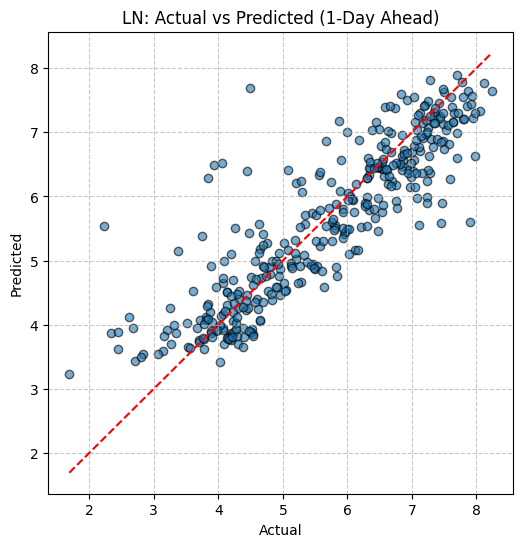

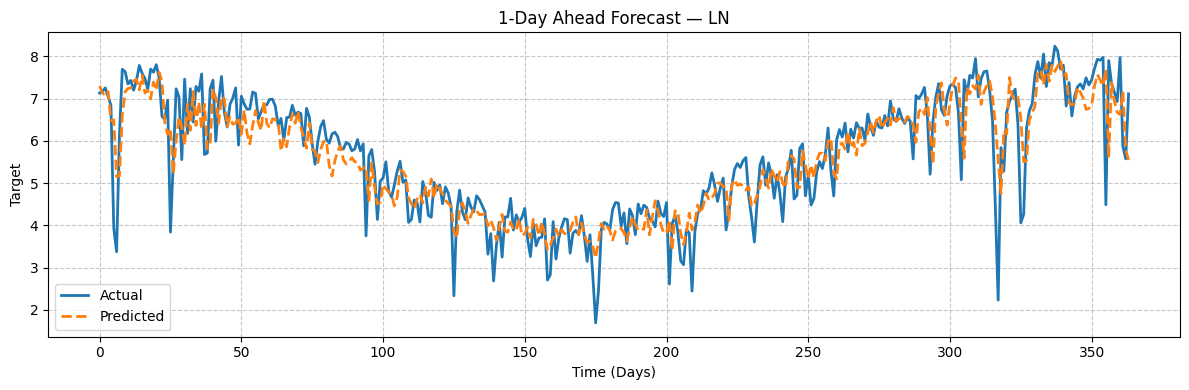

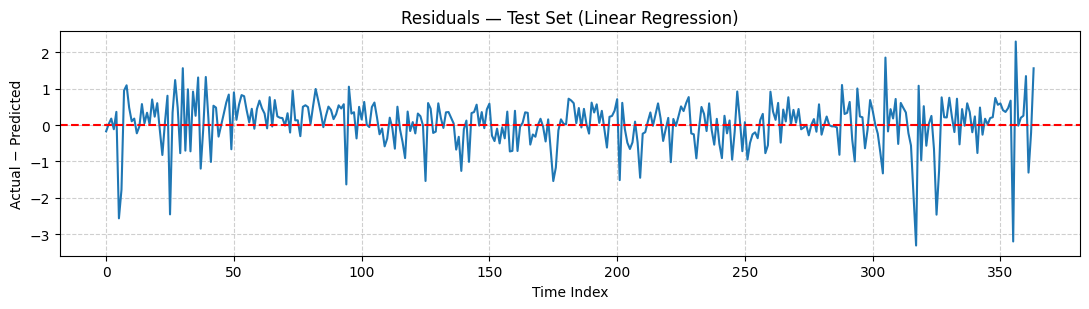

In [ ]:

# 1️.Select all LAGGED features (avoiding data leakage)

lagged_features = [c for c in df.columns
                   if ('lag1' in c) and (c not in ['date_lag1', 'target_next_day'])]

X = df[lagged_features].copy()
y = df['target_next_day'].copy()

print("Selected features:", len(lagged_features))
print("X shape:", X.shape, " | y shape:", y.shape)

# 2️.Chronological Train–Test split (80% train → 20% test)

train_size = int(len(df) * 0.8)
X_train = scaler.transform(train_df[feature_cols])
X_test  = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))

# Initialize and fit scaler only on the training set
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

# Apply same transformation to both train and test
X_train = scaler.transform(train_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

# Extract target variables
y_train = train_df[target_col].values
y_test  = test_df[target_col].values


# 3. Fit Linear Regression model

model_ln = LinearRegression()
model_ln.fit(X_train, y_train)

# Predict
y_pred_ln = model_ln.predict(X_test)

# 4️.Evaluation Metrics
# -----------------------------------------------------------------
mae = mean_absolute_error(y_test, y_pred_ln)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ln))
r2 = r2_score(y_test, y_pred_ln)
mape = np.mean(np.abs((y_test - y_pred_ln) / y_test)) * 100
nrmse = rmse / (y_test.max() - y_test.min()) * 100

print("\n LN Baseline Performance")
print(f"MAE:   {mae:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"R²:    {r2:.4f}")
print(f"MAPE:  {mape:.2f}%")
print(f"NRMSE: {nrmse:.2f}%")


# 7) Visualizations
# a) Actual vs Predicted scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ln, alpha=0.6, edgecolors='k')
min_v = min(y_test.min(), y_pred_ln.min())
max_v = max(y_test.max(), y_pred_ln.max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("LN: Actual vs Predicted (1-Day Ahead)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# b) Timeline plot
plt.figure(figsize=(12,4))
plt.plot(y_test, label="Actual", linewidth=2)
plt.plot(y_pred_ln, label="Predicted", linestyle='--', linewidth=2)
plt.title("1-Day Ahead Forecast — LN")
plt.xlabel("Time (Days)")
plt.ylabel("Target")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Residuals
resid = y_test - y_pred_ln

plt.figure(figsize=(11,3.2))
plt.plot(resid, label="Residuals")
plt.axhline(0, ls='--', color='red')
plt.title("Residuals — Test Set (Linear Regression)")
plt.xlabel("Time Index")
plt.ylabel("Actual − Predicted")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# **Deep Learning**

# **LSTM**

In [ ]:
# ============================================
# Split, scale, and autoencoder feature engineering for LSTM
# ============================================
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

# -----------------------------
# Config (edit these)
# -----------------------------
DATE   = "date"
TARGET = "target_next_day"
FEATURES_X = [  r
    'TEMP', 'CLOUD', 'PRES_KPA', 'PV_PROD',
    'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj',
    'TEMP_lag1', 'CLOUD_lag1', 'PRES_KPA_lag1', 'PV_PROD_lag1',
    'WIND_DIR__sin_lag1', 'WIND_DIR__cos_lag1', 'KT__logit_lag1', 'RAIN__yj_lag1',
    'DNI__yj_lag1', 'DIF__yj_lag1', 'GHI__yj_lag1', 'WIND__yj_lag1'
]
LOOKBACK = 14
LATENT_DIM = 16         # AE bottleneck size
BATCH = 64
EPOCHS = 200
SEED = 42

np.random.seed(SEED); tf.random.set_seed(SEED)


def make_chrono_split(df: pd.DataFrame, date_col=DATE, features=FEATURES_X, target=TARGET, frac=0.8):
    """Chronological 80/20 split (no leakage)."""
    dfc = df.sort_values(date_col).reset_index(drop=True).copy()
    X_all = dfc[features].apply(pd.to_numeric, errors="coerce")
    y_all = pd.to_numeric(dfc[target], errors="coerce")
    dates = dfc[date_col]
    mask = ~X_all.isna().all(axis=1) & ~y_all.isna()
    X_all, y_all, dates = X_all.loc[mask], y_all.loc[mask], dates.loc[mask]
    n = len(X_all)
    split = int(frac * n)
    return (X_all.iloc[:split], X_all.iloc[split:],
            y_all.iloc[:split], y_all.iloc[split:],
            dates.iloc[:split], dates.iloc[split:])

def build_imputer_scaler():
    """Fit on train only; use to transform both splits."""
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler()),
    ])

def build_autoencoder(input_dim, latent_dim=LATENT_DIM, l2=1e-6, dropout=0.05):
    """Simple symmetric AE for tabular features (row-wise)."""
    reg = regularizers.l2(l2) if l2 else None
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu", kernel_regularizer=reg)(inp)
    if dropout: x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=reg)(x)
    if dropout: x = layers.Dropout(dropout)(x)
    z  = layers.Dense(latent_dim, activation="linear", name="z")(x)      # latent
    x = layers.Dense(64, activation="relu")(z)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(input_dim, activation="linear")(x)
    ae  = keras.Model(inp, out)
    enc = keras.Model(inp, z)
    ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return ae, enc

def encode_with_ae(X_train_t, X_valid_t, latent_dim=LATENT_DIM):
    """Train AE on TRAIN ONLY, then transform both splits to latent space."""
    ae, enc = build_autoencoder(X_train_t.shape[1], latent_dim=latent_dim)
    es = callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5)
    ae.fit(X_train_t, X_train_t,
           validation_data=(X_valid_t, X_valid_t),
           epochs=EPOCHS, batch_size=BATCH,
           callbacks=[es, rlr], verbose=0)
    Z_train = enc.predict(X_train_t, verbose=0)
    Z_valid = enc.predict(X_valid_t, verbose=0)
    return Z_train, Z_valid, ae, enc

def make_sequences(X2d, y1d, lookback):
    """
    Turn 2D features (n_samples, n_feats) into LSTM sequences:
      X_seq[i] = X2d[i-lookback : i, :]
      y_seq[i] = y1d[i]
    """
    X2d = np.asarray(X2d); y1d = np.asarray(y1d).ravel()
    Xs, ys = [], []
    for i in range(lookback, len(X2d)):
        Xs.append(X2d[i-lookback:i, :])
        ys.append(y1d[i])
    return np.stack(Xs), np.asarray(ys)


# 1) Split

X_train, X_valid, y_train, y_valid, d_train, d_valid = make_chrono_split(df)


# 2) Scale (fit on train only)

preproc = build_imputer_scaler()
X_train_t = preproc.fit_transform(X_train)
X_valid_t = preproc.transform(X_valid)


# 3) Autoencode features (fit on train only)

Z_train, Z_valid, ae, enc = encode_with_ae(X_train_t, X_valid_t, latent_dim=LATENT_DIM)

# 4) Build LSTM sequences on the encoded features

Xtr_seq, ytr_seq = make_sequences(Z_train, y_train, LOOKBACK)
Xva_seq, yva_seq = make_sequences(Z_valid, y_valid, LOOKBACK)

# Aligned dates for validation (the first LOOKBACK targets are lost in sequencing)
d_valid_seq = d_valid.iloc[LOOKBACK:].reset_index(drop=True)

print("Shapes:")
print("  Encoded train:", Z_train.shape, "Encoded valid:", Z_valid.shape)
print("  LSTM train seq:", Xtr_seq.shape, ytr_seq.shape)
print("  LSTM valid seq:", Xva_seq.shape, yva_seq.shape)


# LSTM model to consume sequences

def build_lstm(n_features, lookback):
    i = keras.Input(shape=(lookback, n_features))
    x = layers.LSTM(128, return_sequences=True)(i)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.2)(x)
    o = layers.Dense(1, activation="linear")(x)
    m = keras.Model(i, o)
    m.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return m

lstm = build_lstm(n_features=Z_train.shape[1], lookback=LOOKBACK)
es = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-5)

hist = lstm.fit(Xtr_seq, ytr_seq,
                validation_data=(Xva_seq, yva_seq),
                epochs=EPOCHS, batch_size=BATCH,
                callbacks=[es, rlr], verbose=0)

pred_va = lstm.predict(Xva_seq, verbose=0).ravel()

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def RMSE(a,b): return np.sqrt(mean_squared_error(a,b))
print(f"LSTM on AE features — Valid: MAE={mean_absolute_error(yva_seq, pred_va):.3f}  "
      f"RMSE={RMSE(yva_seq, pred_va):.3f}  R2={r2_score(yva_seq, pred_va):.3f}")


Shapes:
  Encoded train: (1454, 16) Encoded valid: (364, 16)
  LSTM train seq: (1440, 14, 16) (1440,)
  LSTM valid seq: (350, 14, 16) (350,)
LSTM on AE features — Valid: MAE=0.518  RMSE=0.731  R2=0.732


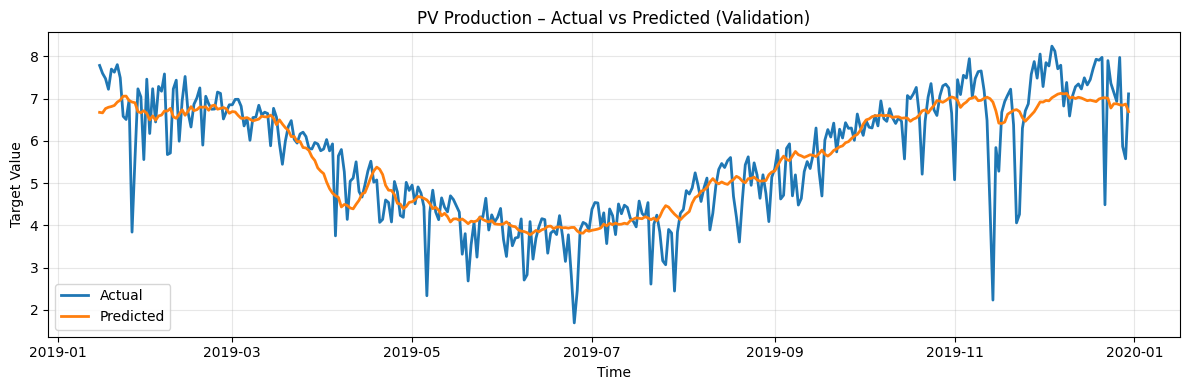

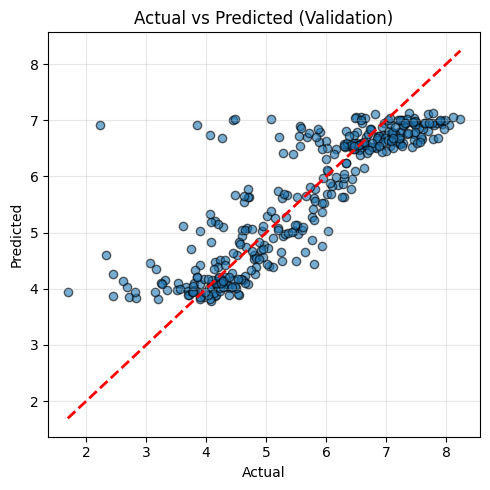

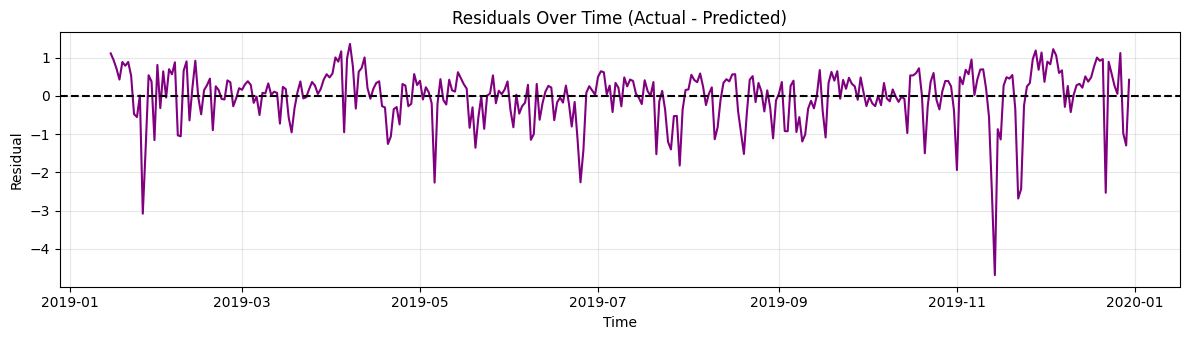

In [ ]:


# 1) Time-Series Comparison
plt.figure(figsize=(12,4))
plt.plot(d_valid_seq, yva_seq, label="Actual", lw=2)
plt.plot(d_valid_seq, pred_va, label="Predicted", lw=2)
plt.title("PV Production – Actual vs Predicted (Validation)")
plt.xlabel("Time")
plt.ylabel("Target Value")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Scatter: Actual vs Predicted
mn = float(np.nanmin([yva_seq.min(), pred_va.min()]))
mx = float(np.nanmax([yva_seq.max(), pred_va.max()]))

plt.figure(figsize=(5,5))
plt.scatter(yva_seq, pred_va, alpha=0.6, edgecolor="k")
plt.plot([mn, mx], [mn, mx], "r--", lw=2)
plt.title("Actual vs Predicted (Validation)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Residuals Over Time
resid = yva_seq - pred_va

plt.figure(figsize=(12,3.5))
plt.plot(d_valid_seq, resid, label="Residuals", color="purple")
plt.axhline(0, ls="--", color="black")
plt.title("Residuals Over Time (Actual - Predicted)")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**12. Transformer**

# Base Prediction Model — Transformer (Keras, pre-scaled data)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(a, b):
    a = np.asarray(a).ravel(); b = np.asarray(b).ravel()
    return np.sqrt(((a - b) ** 2).mean())

# Positional Encoding (sin/cos)

class SinePositionalEncoding(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model

    def call(self, x):

        seq_len = tf.shape(x)[1]
        pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
        i = tf.cast(tf.range(self.d_model)[tf.newaxis, :], tf.float32)
        angle_rates = 1.0 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))
        angles = pos * angle_rates
        # apply sin to even indices; cos to odd indices
        sines = tf.sin(angles[:, 0::2])
        coses = tf.cos(angles[:, 1::2])
        # interleave
        pe = tf.reshape(tf.stack([sines, coses], axis=-1), (seq_len, -1))
        pe = pe[:, :self.d_model]
        pe = tf.expand_dims(pe, 0)
        return x + pe

# Transformer Encoder Block

def transformer_encoder(num_heads, d_model, d_ff, dropout):
    inputs = keras.Input(shape=(None, d_model))
    x = SinePositionalEncoding(d_model)(inputs)
    # Self-attention
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=dropout)(x1, x1)
    x = layers.Add()([x, attn])
    # Feed-forward
    x2 = layers.LayerNormalization(epsilon=1e-6)(x)
    ff = keras.Sequential([
        layers.Dense(d_ff, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(d_model),
    ])
    x = layers.Add()([x, ff(x2)])
    return keras.Model(inputs, x, name="TransformerEncoder")

# Build full Transformer model

def build_transformer_regressor(lookback, n_features,
                                num_layers=2, num_heads=4,
                                d_model=None, d_ff=256, dropout=0.2):
    """
    Regress next value from a window (lookback, n_features)
    """
    if d_model is None:
        d_model = n_features

    inp = keras.Input(shape=(lookback, n_features))

    x = layers.Dense(d_model)(inp) if n_features != d_model else inp

    enc = transformer_encoder(num_heads=num_heads, d_model=d_model, d_ff=d_ff, dropout=dropout)
    for _ in range(num_layers):
        x = enc(x)

    # Pool sequence to a single vector
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Regressor head
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inp, out, name="TransformerRegressor")
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

# Train Transformer

tfm = build_transformer_regressor(
    lookback=Xtr_seq.shape[1],
    n_features=Xtr_seq.shape[2],
    num_layers=2,
    num_heads=4,
    d_model=Xtr_seq.shape[2],
    d_ff=256,
    dropout=0.2
)

es  = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-5)

hist = tfm.fit(
    Xtr_seq, ytr_seq,
    validation_data=(Xva_seq, yva_seq),
    epochs=200, batch_size=64,
    callbacks=[es, rlr],
    verbose=0
)

pred_va = tfm.predict(Xva_seq, verbose=0).ravel()

print("Transformer Performance:")
print(f"  Valid: MAE={mean_absolute_error(yva_seq, pred_va):.3f}  "
      f"RMSE={rmse(yva_seq, pred_va):.3f}  R2={r2_score(yva_seq, pred_va):.3f}")


Transformer Performance:
  Valid: MAE=0.584  RMSE=0.788  R2=0.688


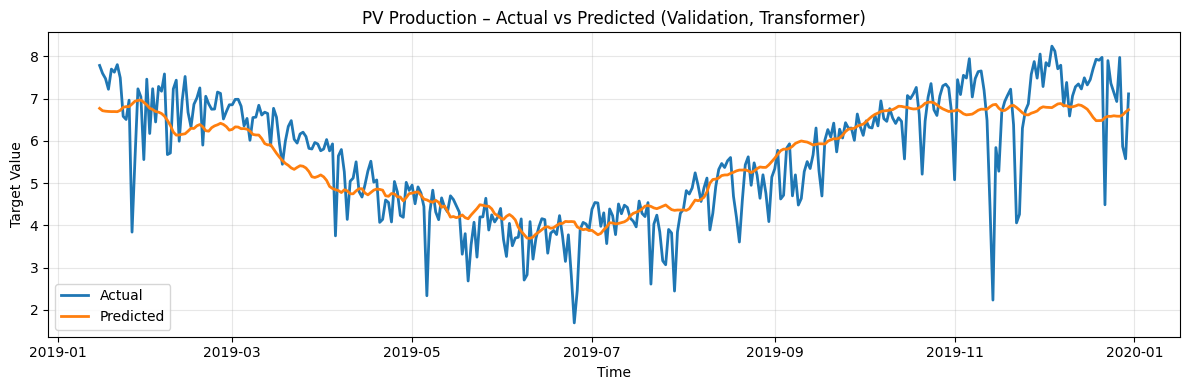

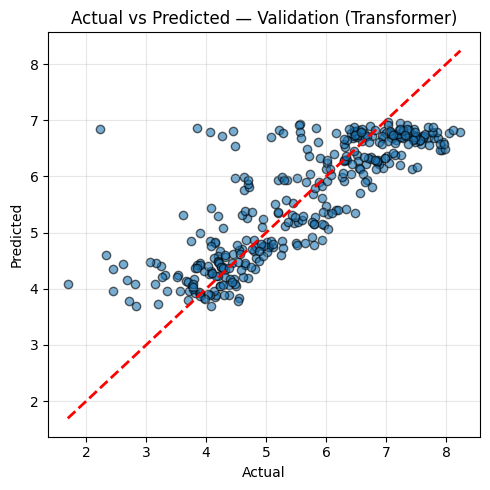

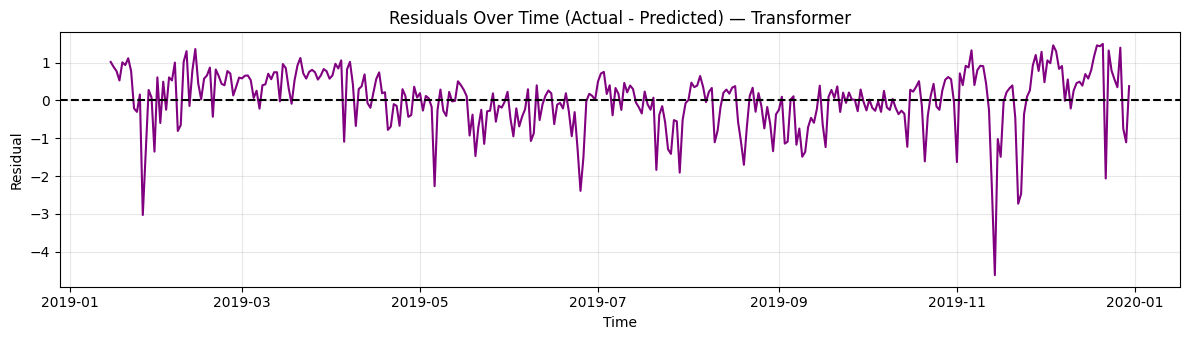

NameError: name 'sel_idx' is not defined

In [ ]:
# 1) Actual vs Predicted over time
plt.figure(figsize=(12,4))
plt.plot(d_valid_seq, yva_seq, label="Actual", lw=2)
plt.plot(d_valid_seq, pred_va, label="Predicted", lw=2)
plt.title("PV Production – Actual vs Predicted (Validation, Transformer)")
plt.xlabel("Time"); plt.ylabel("Target Value")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 2) Scatter
mn = float(np.nanmin([yva_seq.min(), pred_va.min()]))
mx = float(np.nanmax([yva_seq.max(), pred_va.max()]))
plt.figure(figsize=(5,5))
plt.scatter(yva_seq, pred_va, alpha=0.6, edgecolor="k")
plt.plot([mn, mx], [mn, mx], "r--", lw=2)
plt.title("Actual vs Predicted — Validation (Transformer)")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 3) Residuals over time
resid = yva_seq - pred_va
plt.figure(figsize=(12,3.5))
plt.plot(d_valid_seq, resid, color="purple")
plt.axhline(0, ls="--", color="black")
plt.title("Residuals Over Time (Actual - Predicted) — Transformer")
plt.xlabel("Time"); plt.ylabel("Residual")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
selected_names = [FEATURES_X[i] for i in sel_idx]
print(selected_names)


## 13.Ensemble

In [ ]:


# 1️. Select all LAGGED features

lagged_features = [c for c in df.columns
                   if ('lag1' in c) and (c not in ['date_lag1', 'target_next_day'])]

X = df[lagged_features].copy()
y = df['target_next_day'].copy()

print("Selected features:", len(lagged_features))
print("X shape:", X.shape, " | y shape:", y.shape)


# 2️.Chronological Train–Test split (80% train → 20% test)

train_size = int(len(df) * 0.8)
X_train = scaler.transform(train_df[feature_cols])
X_test  = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


# Initialize and fit scaler only on the training set
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

# Apply same transformation to both train and test
X_train = scaler.transform(train_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

Selected features: 12
X shape: (1818, 12)  | y shape: (1818,)
Train samples: 1454
Test samples: 364


In [ ]:

if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=feature_cols)

if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=feature_cols)


Selected 16 top features (indices): [ 0  1  2  4  6  8  9 10 12 13 14 16 18 20 21 22]
Latent dimensions: (1454, 6) (364, 6)
Hybrid features: (1454, 22) (364, 22)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: Use


Performance Summary:
               Model      RMSE       MAE        R2    MAPE(%)
0               LSTM  0.779543  0.575209  0.700022  11.903064
1        Transformer  0.770188  0.581607  0.707179  11.634959
2  Ensemble (α=0.03)  0.768475  0.579715  0.708480  11.610368


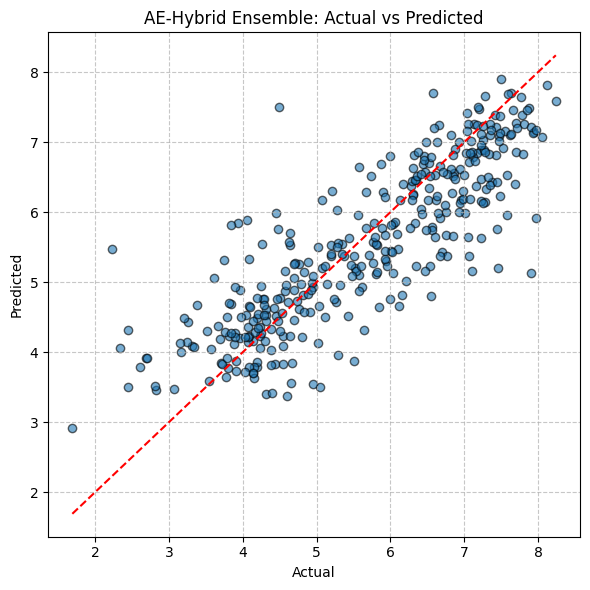

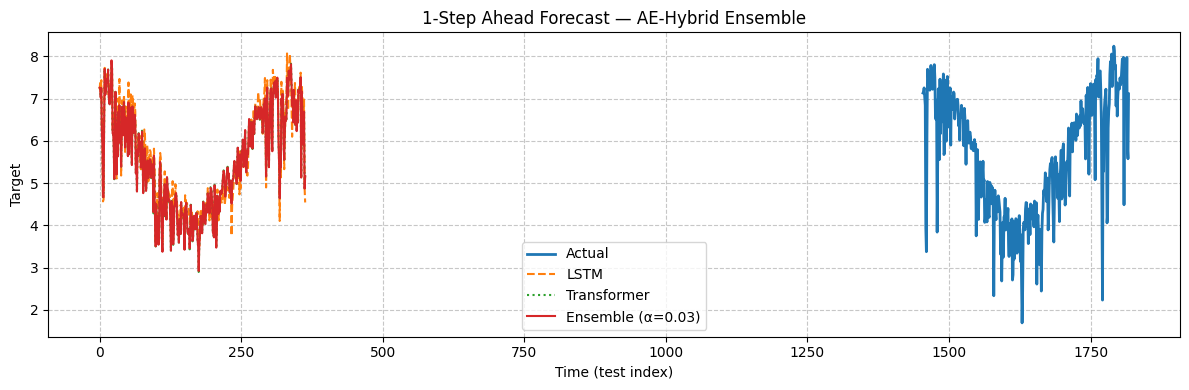

In [ ]:

# AE-based Feature Selection + LSTM/Transformer Ensemble


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Reproducibility

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.get_logger().setLevel("ERROR")

# 1) Utility functions

def to_3d(X):
    #Reshape 2D tabular data (N,F) to 3D (N,1,F) for sequence models
    X = np.asarray(X, dtype=np.float32)
    return X.reshape(-1, 1, X.shape[1])

def metrics(y_true, y_pred):
    #Compute evaluation metrics
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred))
    mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100.0)
    return {"RMSE": rmse, "MAE": mae, "R2": r2, "MAPE(%)": mape}

def find_optimal_alpha(y_true_val, y_pred_lstm_val, y_pred_tr_val, grid=np.linspace(0,1,101)):
    #Grid-search α in [0,1] to blend LSTM and Transformer predictions
    best = (0.5, np.inf)
    for a in grid:
        y_blend = a * y_pred_lstm_val + (1.0 - a) * y_pred_tr_val
        rmse = np.sqrt(mean_squared_error(y_true_val, y_blend))
        if rmse < best[1]:
            best = (a, rmse)
    return best[0], best[1]


# 2) Autoencoder (AE) block for feature selection


def train_autoencoder(X_train, val_frac=0.10, latent_dim=None, batch_size=64, max_epochs=200):
    #Train AE on TRAIN only with chronological validation tail-without shuffle
    X_train = np.asarray(X_train, dtype=np.float32)
    n, n_features = X_train.shape
    n_val = max(1, int(val_frac * n))
    X_tr, X_val = X_train[:-n_val], X_train[-n_val:]

    if latent_dim is None:
        latent_dim = max(4, n_features // 4)

    inp = Input(shape=(n_features,))
    x   = Dense(128, activation='relu')(inp)
    x   = Dropout(0.10)(x)
    z   = Dense(latent_dim, activation='linear', name='latent')(x)
    x   = Dense(128, activation='relu')(z)
    out = Dense(n_features, activation='linear')(x)

    ae = Model(inp, out, name="autoencoder")
    ae.compile(optimizer='adam', loss='mse')

    es  = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-5)

    ae.fit(
        X_tr, X_tr,
        validation_data=(X_val, X_val),
        epochs=max_epochs, batch_size=batch_size,
        callbacks=[es, rlr],
        shuffle=False, verbose=0
    )
    return ae, X_val

def ae_rank_features_by_recon_corr(ae, X_val, top_k=16):
    #Rank features by correlation(original vs reconstruction) in AE validation
    X_val = np.asarray(X_val, dtype=np.float32)
    X_hat = ae.predict(X_val, verbose=0)
    corrs = []
    for j in range(X_val.shape[1]):
        x, xr = X_val[:, j], X_hat[:, j]
        if np.std(x) < 1e-12 or np.std(xr) < 1e-12:
            c = -np.inf
        else:
            c = float(np.corrcoef(x, xr)[0, 1])
        corrs.append(c)
    order = np.argsort(-(np.nan_to_num(corrs, nan=-np.inf)))
    sel_idx = np.sort(order[:min(top_k, X_val.shape[1])]).astype(int)
    return sel_idx, [corrs[i] for i in sel_idx]

def ae_encode(ae, X):
    #Return latent compressed representation
    X = np.asarray(X, dtype=np.float32)
    encoder = Model(ae.input, ae.get_layer('latent').output)
    return encoder.predict(X, verbose=0)

def make_hybrid_features(X_train, X_test, sel_idx, Z_train, Z_test):
    #Combine AE latent codes with top-K original features
    X_train = np.asarray(X_train, dtype=np.float32)
    X_test  = np.asarray(X_test, dtype=np.float32)
    Xtr_sel = X_train[:, sel_idx]
    Xte_sel = X_test[:, sel_idx]
    Xtr_h   = np.hstack([Xtr_sel, Z_train])
    Xte_h   = np.hstack([Xte_sel, Z_test])
    return Xtr_h, Xte_h


# 3) Build Models — LSTM and Transformer


def build_lstm(input_shape, units=64, dropout=0.2, dense=32, lr=1e-3):
    #LSTM regression model
    model = Sequential([
        LSTM(units, input_shape=input_shape, return_sequences=False),
        Dropout(dropout),
        Dense(dense, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

def transformer_encoder_block(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    #Transformer encoder block with residual connections
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    x = x + inputs
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation='relu')(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1], activation=None)(y)
    return y + x

def build_transformer(input_shape, head_size=64, num_heads=4, ff_dim=128, dropout=0.1, lr=1e-3):
    #Transformer regression model
    inp = Input(shape=input_shape)
    x = transformer_encoder_block(inp, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1)(x)
    model = Model(inputs=inp, outputs=out, name="TransformerRegressor")
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model


# 4) Train both models + ensemble blend


def train_models(X_train, y_train, X_test, y_test, out_prefix="pv_hybrid"):
    #Train LSTM and Transformer and combine with optimal α ensemble
    X_train_3d = to_3d(X_train)
    X_test_3d  = to_3d(X_test)
    input_shape = (X_train_3d.shape[1], X_train_3d.shape[2])

    # Chronological split for validation
    val_frac = 0.1
    n_val = max(1, int(val_frac * len(X_train)))
    X_tr, X_val = X_train_3d[:-n_val], X_train_3d[-n_val:]
    y_tr, y_val = y_train[:-n_val], y_train[-n_val:]

    # LSTM
    lstm = build_lstm(input_shape)
    cb = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
          ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)]
    lstm.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=cb, verbose=0)

    # Transformer
    tr = build_transformer(input_shape)
    tr.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=cb, verbose=0)

    # Predictions
    y_pred_lstm_val = lstm.predict(X_val, verbose=0).ravel()
    y_pred_tr_val   = tr.predict(X_val, verbose=0).ravel()
    y_pred_lstm_te  = lstm.predict(X_test_3d, verbose=0).ravel()
    y_pred_tr_te    = tr.predict(X_test_3d, verbose=0).ravel()

    # Ensemble blending
    alpha, _ = find_optimal_alpha(y_val, y_pred_lstm_val, y_pred_tr_val)
    y_pred_ens_te = alpha * y_pred_lstm_te + (1 - alpha) * y_pred_tr_te

    results = pd.DataFrame([
        {"Model": "LSTM", **metrics(y_test, y_pred_lstm_te)},
        {"Model": "Transformer", **metrics(y_test, y_pred_tr_te)},
        {"Model": f"Ensemble (α={alpha:.2f})", **metrics(y_test, y_pred_ens_te)}
    ])
    return lstm, tr, results, (alpha, y_pred_lstm_te, y_pred_tr_te, y_pred_ens_te)


# 5) Main pipeline (assuming X_train, X_test, y_train, y_test ready)


# Only the final 24 features are used
FEATURES_FINAL = [
 'TEMP', 'CLOUD', 'PRES_KPA', 'PV_PROD', 'WIND_DIR__sin', 'WIND_DIR__cos',
 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj', 'GHI__yj', 'WIND__yj',
 'TEMP_lag1', 'CLOUD_lag1', 'PRES_KPA_lag1', 'PV_PROD_lag1',
 'WIND_DIR__sin_lag1', 'WIND_DIR__cos_lag1', 'KT__logit_lag1', 'RAIN__yj_lag1',
 'DNI__yj_lag1', 'DIF__yj_lag1', 'GHI__yj_lag1', 'WIND__yj_lag1'
]

X_train = X_train[FEATURES_FINAL].copy()
X_test  = X_test[FEATURES_FINAL].copy()

# AE training + feature selection + latent extraction
ae, X_val_AE = train_autoencoder(X_train, val_frac=0.10, latent_dim=None)
sel_idx, sel_corrs = ae_rank_features_by_recon_corr(ae, X_val_AE, top_k=16)
print(f"Selected {len(sel_idx)} top features (indices):", sel_idx)

Z_train = ae_encode(ae, X_train)
Z_test  = ae_encode(ae, X_test)
print("Latent dimensions:", Z_train.shape, Z_test.shape)

X_train_hybrid, X_test_hybrid = make_hybrid_features(X_train, X_test, sel_idx, Z_train, Z_test)
print("Hybrid features:", X_train_hybrid.shape, X_test_hybrid.shape)

# Train ensemble
lstm_model, tr_model, df_results, info = train_models(X_train_hybrid, y_train, X_test_hybrid, y_test)
alpha, yhat_lstm, yhat_tr, yhat_ens = info
print("\nPerformance Summary:")
print(df_results)


# 6) Visualization


plt.figure(figsize=(6,6))
plt.scatter(y_test, yhat_ens, alpha=0.6, edgecolors='k')
vmin, vmax = min(y_test.min(), yhat_ens.min()), max(y_test.max(), yhat_ens.max())
plt.plot([vmin, vmax], [vmin, vmax], 'r--')
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("AE-Hybrid Ensemble: Actual vs Predicted")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(yhat_lstm, label='LSTM', linestyle='--')
plt.plot(yhat_tr, label='Transformer', linestyle=':')
plt.plot(yhat_ens, label=f'Ensemble (α={alpha:.2f})', linestyle='-')
plt.xlabel("Time (test index)")
plt.ylabel("Target")
plt.title("1-Step Ahead Forecast — AE-Hybrid Ensemble")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **Optimization**

**15. Optimization**

In [ ]:

# Ensure datetime format and sort by time
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)




In [ ]:

#Split Chronologically (Train / Test / Validation)
#split before normalization so that test data remains unseen when computing scaling statistics (to avoid data leakage)
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df  = df.iloc[train_size:]


In [ ]:
#Fit Scaler on Training Set and Apply to All Sets
#Fitting on the train set only ensures realistic performance on unseen (future) data
non_numeric = train_df.select_dtypes(exclude=['float64', 'int64'])
#print("Non-numeric columns:")
#print(non_numeric.columns.tolist())

for col in non_numeric.columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    test_df[col]  = pd.to_numeric(test_df[col], errors='coerce')


# Identify target and non-feature columns
target_col = 'target_next_day'
non_feature_cols = ['date', target_col]

# Select all numeric feature columns - except date and target
feature_cols = [c for c in train_df.columns if c not in non_feature_cols]

print("Number of features selected:", len(feature_cols))
print(feature_cols[:10])  # preview first 10 names

# Initialize and fit scaler only on the training set
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

# Apply same transformation to both train and test
X_train = scaler.transform(train_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

# Extract target variables
y_train = train_df[target_col].values
y_test  = test_df[target_col].values

print("Data successfully scaled — ready for modeling!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



✅ Number of features selected: 25
['TEMP', 'CLOUD', 'PRES_KPA', 'PV_PROD', 'WIND_DIR__sin', 'WIND_DIR__cos', 'KT__logit', 'RAIN__yj', 'DNI__yj', 'DIF__yj']
✅ Data successfully scaled — ready for modeling!
X_train shape: (1454, 25)
X_test shape: (364, 25)


# **Adam (and AdamW)**


Selected 16 top features: [ 0  1  2  4  5  6  8  9 10 13 14 15 17 19 21 23]
Latent shapes: (1454, 6) (364, 6)
Hybrid shapes: (1454, 22) (364, 22)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



=== Results ===
LSTM (Adam)                    → MAE: 0.5793  RMSE: 0.7826  R²: 0.6977
Transformer (AdamW)            → MAE: 0.5268  RMSE: 0.7461  R²: 0.7252
Chosen ensemble α* = 0.73
Ensemble (α*·LSTM + (1-α*)·TF) → MAE: 0.5507  RMSE: 0.7557  R²: 0.7181


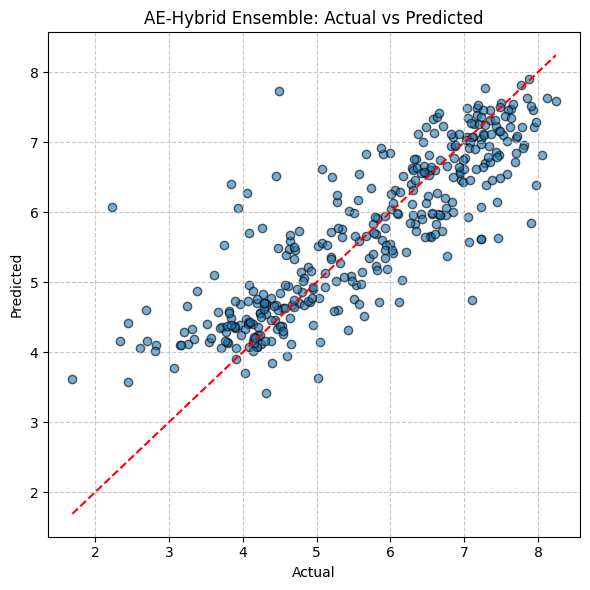

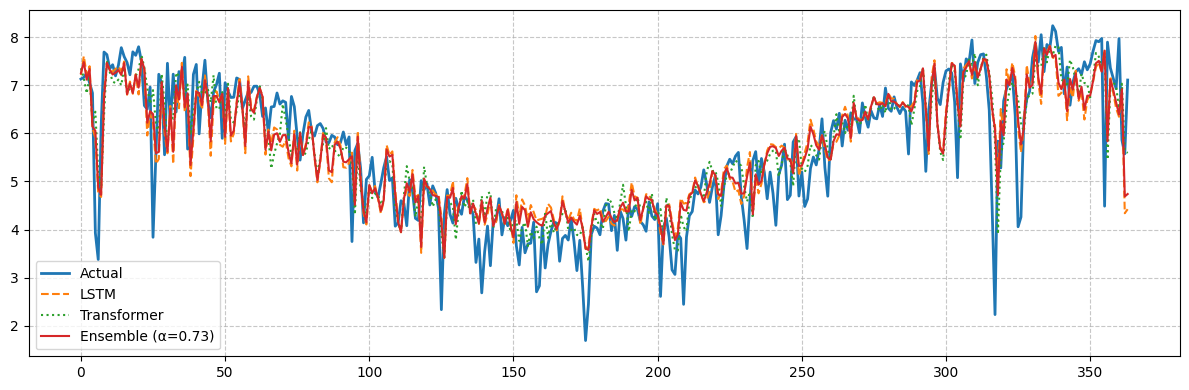

In [ ]:

# Autoencoder Feature Selection + LSTM (Adam) + Transformer (AdamW) + Ensemble


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Reproducibility

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.get_logger().setLevel("ERROR")


# 1. Autoencoder for feature extraction


def train_autoencoder(X_train, val_frac=0.1, latent_dim=None, batch_size=64, max_epochs=200):
    #Train AE on train only with chronological validation split
    X_train = np.asarray(X_train, dtype=np.float32)
    n, n_features = X_train.shape
    n_val = max(1, int(val_frac * n))
    X_tr, X_val = X_train[:-n_val], X_train[-n_val:]

    if latent_dim is None:
        latent_dim = max(4, n_features // 4)

    inp = Input(shape=(n_features,))
    x = Dense(128, activation='relu')(inp)
    x = Dropout(0.1)(x)
    z = Dense(latent_dim, activation='linear', name='latent')(x)
    x = Dense(128, activation='relu')(z)
    out = Dense(n_features, activation='linear')(x)

    ae = Model(inp, out)
    ae.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    ae.fit(
        X_tr, X_tr,
        validation_data=(X_val, X_val),
        epochs=max_epochs, batch_size=batch_size,
        callbacks=[es, rlr],
        shuffle=False, verbose=0
    )
    return ae, X_val

def ae_rank_features(ae, X_val, top_k=16):
    #Rank features by reconstruction correlation
    X_val = np.asarray(X_val, dtype=np.float32)
    X_hat = ae.predict(X_val, verbose=0)
    corrs = []
    for j in range(X_val.shape[1]):
        if np.std(X_val[:, j]) < 1e-8:
            c = -np.inf
        else:
            c = np.corrcoef(X_val[:, j], X_hat[:, j])[0, 1]
        corrs.append(c)
    order = np.argsort(-np.nan_to_num(corrs, nan=-np.inf))
    sel_idx = np.sort(order[:min(top_k, len(order))])
    return sel_idx

def ae_encode(ae, X):
    #Return latent representations
    encoder = Model(ae.input, ae.get_layer('latent').output)
    return encoder.predict(np.asarray(X, dtype=np.float32), verbose=0)

def make_hybrid_features(X_train, X_test, sel_idx, Z_train, Z_test):
    #Concatenate selected original features and latent codes
    Xtr_sel = np.asarray(X_train)[:, sel_idx]
    Xte_sel = np.asarray(X_test)[:, sel_idx]
    Xtr_h = np.hstack([Xtr_sel, Z_train])
    Xte_h = np.hstack([Xte_sel, Z_test])
    return Xtr_h, Xte_h

# 2) Define metrics and helper

def report(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{name:30s} → MAE: {mae:.4f}  RMSE: {rmse:.4f}  R²: {r2:.4f}")
    return mae, rmse, r2

# 3) Train LSTM and Transformer + Ensemble

def train_lstm_transformer_ensemble(X_train, X_test, y_train, y_test):
    # Chronological split
    val_frac = 0.1
    n = len(X_train)
    n_val = max(1, int(val_frac * n))
    X_tr, y_tr = X_train[:-n_val], y_train[:-n_val]
    X_val, y_val = X_train[-n_val:], y_train[-n_val:]

    # Sequence reshape
    X_tr_seq = X_tr.reshape(-1, 1, X_tr.shape[1])
    X_val_seq = X_val.reshape(-1, 1, X_val.shape[1])
    X_te_seq = X_test.reshape(-1, 1, X_test.shape[1])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]

    #  LSTM
    adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
    lstm = Sequential([
        LSTM(64, input_shape=(1, X_tr.shape[1])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    lstm.compile(optimizer=adam, loss='mse', metrics=['mae'])
    lstm.fit(X_tr_seq, y_tr, validation_data=(X_val_seq, y_val),
             epochs=100, batch_size=32, callbacks=callbacks, verbose=0)

    y_va_pred_lstm = lstm.predict(X_val_seq, verbose=0).ravel()
    y_te_pred_lstm = lstm.predict(X_te_seq, verbose=0).ravel()

    # Transformer
    adamw = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
    inp = Input(shape=(1, X_tr.shape[1]))
    x = LayerNormalization(epsilon=1e-6)(inp)
    x = MultiHeadAttention(num_heads=4, key_dim=64, dropout=0.1)(x, x)
    x = Dropout(0.1)(x)
    res = x + inp
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(X_tr.shape[1], activation=None)(x)
    x = x + res
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1)(x)
    transformer = Model(inp, out)
    transformer.compile(optimizer=adamw, loss='mse', metrics=['mae'])
    transformer.fit(X_tr_seq, y_tr, validation_data=(X_val_seq, y_val),
                    epochs=100, batch_size=32, callbacks=callbacks, verbose=0)

    y_va_pred_tf = transformer.predict(X_val_seq, verbose=0).ravel()
    y_te_pred_tf = transformer.predict(X_te_seq, verbose=0).ravel()

    #  Ensemble
    alphas = np.linspace(0, 1, 101)
    rmse_list = [
        np.sqrt(mean_squared_error(y_val, a * y_va_pred_lstm + (1 - a) * y_va_pred_tf))
        for a in alphas
    ]
    alpha_star = alphas[np.argmin(rmse_list)]
    y_te_pred_ens = alpha_star * y_te_pred_lstm + (1 - alpha_star) * y_te_pred_tf

    print("\n Results ")
    report("LSTM (Adam)", y_test, y_te_pred_lstm)
    report("Transformer (AdamW)", y_test, y_te_pred_tf)
    print(f"Chosen ensemble α* = {alpha_star:.2f}")
    report("Ensemble (α*·LSTM + (1-α*)·TF)", y_test, y_te_pred_ens)

    return lstm, transformer, alpha_star, y_te_pred_ens, y_te_pred_lstm, y_te_pred_tf


# 4) Full pipeline

# On pre-scaled X_train, X_test, y_train, y_test

# 1. Train AE and select features
ae, X_val_AE = train_autoencoder(X_train, val_frac=0.10)
sel_idx = ae_rank_features(ae, X_val_AE, top_k=16)
print(f"Selected {len(sel_idx)} top features: {sel_idx}")

# 2. Encode latent features
Z_train = ae_encode(ae, X_train)
Z_test = ae_encode(ae, X_test)
print("Latent shapes:", Z_train.shape, Z_test.shape)

# 3. Make hybrid features (selected originals + latent)
X_train_h, X_test_h = make_hybrid_features(X_train, X_test, sel_idx, Z_train, Z_test)
print("Hybrid shapes:", X_train_h.shape, X_test_h.shape)

# 4. Train ensemble
lstm, transformer, alpha_star, y_te_pred_ens, y_te_pred_lstm, y_te_pred_tf = train_lstm_transformer_ensemble(
    X_train_h, X_test_h, y_train, y_test
)

# 5. Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_te_pred_ens, alpha=0.6, edgecolors='k')
vmin, vmax = min(y_test.min(), y_te_pred_ens.min()), max(y_test.max(), y_te_pred_ens.max())
plt.plot([vmin, vmax], [vmin, vmax], 'r--')
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("AE-Hybrid Ensemble: Actual vs Predicted")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_te_pred_lstm, label='LSTM', linestyle='--')
plt.plot(y_te_pred_tf, label='Transformer', linestyle=':')
plt.plot(y_te_pred_ens, label=f'Ensemble (α={alpha_star:.2f})', linestyle='-')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 6. Save models
lstm.save("lstm_final_AE_hybrid.keras")
transformer.save("transformer_final_AE_hybrid.keras")
np.savez("ensemble_alpha_AE_hybrid.npz", alpha_star=alpha_star)


In [ ]:
#Result of ensembel method with Adam/AdamW optimization
def collect_metrics(y_test, y_pred_lstm, y_pred_tf, y_pred_ens, alpha_star):
    rows = []
    rows.append({"Model": "LSTM (Adam)", "MAE": mean_absolute_error(y_test, y_pred_lstm),
                 "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_lstm)),
                 "R2": r2_score(y_test, y_pred_lstm)})
    rows.append({"Model": "Transformer (AdamW)", "MAE": mean_absolute_error(y_test, y_pred_tf),
                 "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_tf)),
                 "R2": r2_score(y_test, y_pred_tf)})
    rows.append({"Model": f"Ensemble (α={alpha_star:.2f})",
                 "MAE": mean_absolute_error(y_test, y_pred_ens),
                 "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_ens)),
                 "R2": r2_score(y_test, y_pred_ens)})
    return pd.DataFrame(rows)

# After training:
metrics_df = collect_metrics(y_test, y_te_pred_lstm, y_te_pred_tf, y_te_pred_ens, alpha_star)
print(metrics_df)


                 Model       MAE      RMSE        R2
0          LSTM (Adam)  0.579341  0.782609  0.697658
1  Transformer (AdamW)  0.526790  0.746150  0.725172
2    Ensemble (α=0.73)  0.550677  0.755739  0.718062


# **NAdam Optimizer**

In [ ]:

# Autoencoder Feature Selection + Nadam LSTM + Nadam Transformer Ensemble


import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


# 1. Utility functions


def to_3d(X):
    #Reshape (N,F) -> (N,1,F) for sequence models
    return X.astype(np.float32).reshape(-1, 1, X.shape[1])

def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def mae(y, yhat):  return float(mean_absolute_error(y, yhat))
def r2(y, yhat):   return float(r2_score(y, yhat))

def find_alpha(yv, pv_lstm, pv_tr, step=0.01):
    #Search α ∈ [0,1] to minimize RMSE on validation
    best_a, best_rmse = 0.0, 1e9
    for a in np.arange(0, 1.01, step):
        rm = rmse(yv, a * pv_lstm + (1 - a) * pv_tr)
        if rm < best_rmse:
            best_rmse, best_a = rm, a
    return best_a, best_rmse


# 2. Autoencoder Feature Selection (leak-safe)


def train_autoencoder(X_train, val_frac=0.10, latent_dim=None, epochs=200, batch=64):
    X_train = np.asarray(X_train, dtype=np.float32)
    n, f = X_train.shape
    n_val = max(1, int(n * val_frac))
    X_tr, X_val = X_train[:-n_val], X_train[-n_val:]

    if latent_dim is None:
        latent_dim = max(4, f // 4)     # auto-rule: quarter of features

    inp = Input(shape=(f,))
    x = Dense(128, activation="relu")(inp)
    x = Dropout(0.1)(x)
    z = Dense(latent_dim, activation="linear", name="latent")(x)
    x = Dense(128, activation="relu")(z)
    out = Dense(f, activation="linear")(x)

    ae = Model(inp, out)
    ae.compile(optimizer="adam", loss="mse")

    es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6)

    ae.fit(X_tr, X_tr,
           validation_data=(X_val, X_val),
           epochs=epochs, batch_size=batch,
           shuffle=False, callbacks=[es, rl], verbose=0)

    return ae, X_val


def rank_features(ae, X_val, top_k=16):
    X_val = np.asarray(X_val, dtype=np.float32)
    X_hat = ae.predict(X_val, verbose=0)

    corrs = []
    for j in range(X_val.shape[1]):
        x, xr = X_val[:, j], X_hat[:, j]
        if np.std(x) < 1e-9 or np.std(xr) < 1e-9:
            corrs.append(-np.inf)
        else:
            corrs.append(np.corrcoef(x, xr)[0, 1])

    order = np.argsort(-np.nan_to_num(corrs))
    sel = np.sort(order[:top_k])
    return sel, [corrs[k] for k in sel]


def ae_encode(ae, X):
    enc = Model(ae.input, ae.get_layer("latent").output)
    return enc.predict(X, verbose=0)


def build_hybrid(X_train, X_test, sel_idx, Z_train, Z_test):
    return np.hstack([X_train[:, sel_idx], Z_train]), np.hstack([X_test[:, sel_idx], Z_test])


# 3) Nadam LSTM + Nadam Transformer + Ensemble


def build_lstm(input_shape, units=64, dense=32, dropout=0.3, lr=1e-3):
    model = Sequential([
        LSTM(units, input_shape=input_shape, return_sequences=False),
        Dropout(dropout),
        Dense(dense, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Nadam(lr), loss="mse", metrics=["mae"])
    return model

def transformer_block(x, head=64, heads=4, ff=128, dropout=0.1):
    h = LayerNormalization(epsilon=1e-6)(x)
    h = MultiHeadAttention(num_heads=heads, key_dim=head, dropout=dropout)(h, h)
    h = Dropout(dropout)(h)
    x = x + h
    h = LayerNormalization(epsilon=1e-6)(x)
    h = Dense(ff, activation="relu")(h)
    h = Dropout(dropout)(h)
    h = Dense(x.shape[-1], activation=None)(h)
    return x + h

def build_transformer(input_shape, lr=1e-3):
    inp = Input(shape=input_shape)
    x = transformer_block(inp)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Nadam(lr), loss="mse", metrics=["mae"])
    return model

def train_models(X_train, y_train, X_test, y_test, epochs=80):
    # Chronological val split
    n = len(X_train)
    nv = max(1, int(0.1 * n))
    X_tr, y_tr = X_train[:-nv], y_train[:-nv]
    X_va, y_va = X_train[-nv:], y_train[-nv:]

    X_tr3, X_va3, X_te3 = to_3d(X_tr), to_3d(X_va), to_3d(X_test)
    shape = (1, X_train.shape[1])

    lstm = build_lstm(shape)
    tr   = build_transformer(shape)

    cb = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]

    lstm.fit(X_tr3, y_tr, validation_data=(X_va3, y_va), epochs=epochs, batch_size=32, verbose=0, callbacks=cb)
    tr.fit(  X_tr3, y_tr, validation_data=(X_va3, y_va), epochs=epochs, batch_size=32, verbose=0, callbacks=cb)

    # Predictions
    p_lstm_v = lstm.predict(X_va3, verbose=0).ravel()
    p_tr_v   = tr.predict(  X_va3, verbose=0).ravel()
    p_lstm_t = lstm.predict(X_te3, verbose=0).ravel()
    p_tr_t   = tr.predict(  X_te3, verbose=0).ravel()

    alpha, _ = find_alpha(y_va, p_lstm_v, p_tr_v)
    p_ens_t = alpha * p_lstm_t + (1 - alpha) * p_tr_t

    results = {
        "alpha": alpha,
        "LSTM_RMSE": rmse(y_test, p_lstm_t), "TR_RMSE": rmse(y_test, p_tr_t), "ENS_RMSE": rmse(y_test, p_ens_t),
        "LSTM_MAE":  mae(y_test, p_lstm_t),   "TR_MAE":  mae(y_test, p_tr_t),   "ENS_MAE":  mae(y_test, p_ens_t),
        "LSTM_R2":   r2(y_test, p_lstm_t),    "TR_R2":   r2(y_test, p_tr_t),    "ENS_R2":   r2(y_test, p_ens_t)
    }
    return lstm, tr, results, (p_lstm_t, p_tr_t, p_ens_t)


# 4. RUN PIPELINE

# Autoencoder Feature Selection
ae, X_val_AE = train_autoencoder(X_train, val_frac=0.1)

TOP_K = 16
sel_idx, corr_vals = rank_features(ae, X_val_AE, top_k=TOP_K)
print("Selected feature idx:", sel_idx)

Z_train = ae_encode(ae, X_train)
Z_test  = ae_encode(ae, X_test)

X_train_h, X_test_h = build_hybrid(X_train, X_test, sel_idx, Z_train, Z_test)
print("Hybrid shapes:", X_train_h.shape, X_test_h.shape)

# Train Models
lstm_model, tr_model, results, preds = train_models(X_train_h, y_train, X_test_h, y_test)
p_lstm, p_tr, p_ens = preds

print("\n=== Results with Nadam + AE Hybrid ===")
print(f"Optimal α: {results['alpha']:.2f}")
print(f"{'Model':<15}{'RMSE':>10}{'MAE':>10}{'R²':>10}")
print("-"*45)
for m in ['LSTM','TR','ENS']:
    print(f"{m:<15}{results[f'{m}_RMSE']:>10.4f}{results[f'{m}_MAE']:>10.4f}{results[f'{m}_R2']:>10.4f}")


Selected feature idx: [ 0  1  2  4  5  6  8  9 10 13 14 15 17 19 21 23]
Hybrid shapes: (1454, 22) (364, 22)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



=== Results with Nadam + AE Hybrid ===
Optimal α: 0.54
Model                RMSE       MAE        R²
---------------------------------------------
LSTM               0.7747    0.5691    0.7038
TR                 0.7718    0.5683    0.7060
ENS                0.7603    0.5565    0.7146


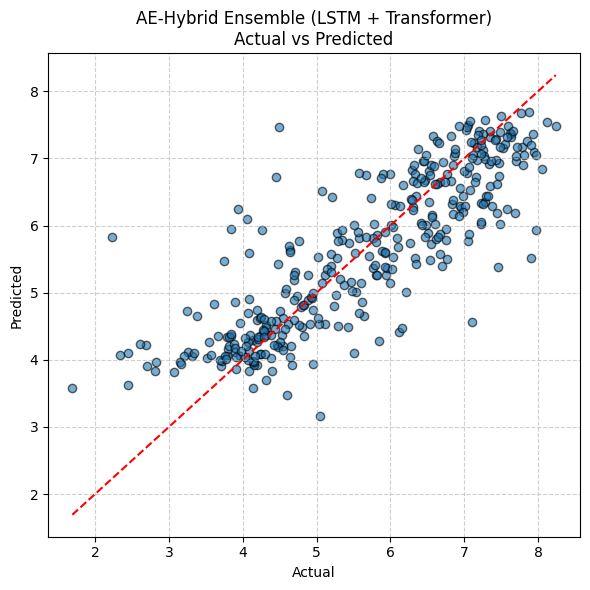

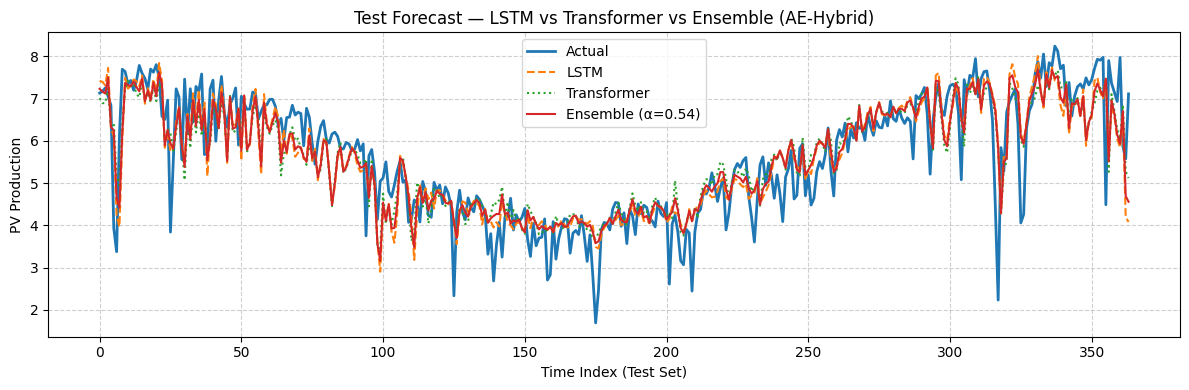

In [ ]:

# 5. VISUALIZATION — TEST SET


# 1️. Scatter: Actual vs Ensemble Prediction
plt.figure(figsize=(6,6))
plt.scatter(y_test, p_ens, alpha=0.6, edgecolor='k')
vmin, vmax = min(y_test.min(), p_ens.min()), max(y_test.max(), p_ens.max())
plt.plot([vmin, vmax], [vmin, vmax], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("AE-Hybrid Ensemble (LSTM + Transformer)\nActual vs Predicted")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 2️. Time-Series Comparison (Test set)
plt.figure(figsize=(12,4))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(p_lstm, label='LSTM', linestyle='--')
plt.plot(p_tr, label='Transformer', linestyle=':')
plt.plot(p_ens, label=f'Ensemble (α={results["alpha"]:.2f})', linestyle='-')
plt.xlabel("Time Index (Test Set)")
plt.ylabel("PV Production")
plt.title("Test Forecast — LSTM vs Transformer vs Ensemble (AE-Hybrid)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# **PSO Optimization**

In [ ]:

# PART 1 — Autoencoder Feature Selection (Leak-Safe)


# Settings
TOP_K = 16            # number of best-reconstructed original features to keep
LATENT_AUTO = True    # auto latent dimension
np.random.seed(42)
tf.random.set_seed(42)

# 1. Prepare train/test matrices (already scaled & ordered)

X_train = pd.DataFrame(X_train, columns=feature_cols)
X_test  = pd.DataFrame(X_test,  columns=feature_cols)
n_features = X_train.shape[1]
latent_dim = max(4, n_features // 4) if LATENT_AUTO else 8


# 2. Leak-safe AE training (fit only on training set)

def train_autoencoder(X_train, val_frac=0.1, latent_dim=6, epochs=200, batch_size=64):
    X_train = np.asarray(X_train, dtype=np.float32)
    n = len(X_train)
    n_val = max(1, int(n * val_frac))
    X_tr, X_val = X_train[:-n_val], X_train[-n_val:]

    inp = Input(shape=(X_train.shape[1],))
    x = Dense(128, activation='relu')(inp)
    x = Dropout(0.1)(x)
    z = Dense(latent_dim, activation='linear', name='latent')(x)
    x = Dense(128, activation='relu')(z)
    out = Dense(X_train.shape[1], activation='linear')(x)

    ae = Model(inp, out, name='Autoencoder')
    ae.compile(optimizer='adam', loss='mse')

    es  = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-5)
    ae.fit(X_tr, X_tr,
           validation_data=(X_val, X_val),
           epochs=epochs, batch_size=batch_size,
           shuffle=False, verbose=0, callbacks=[es, rlr])
    return ae, X_val

# 3. Rank features by reconstruction correlation

def rank_features_by_corr(ae, X_val, top_k=TOP_K):
    X_val = np.asarray(X_val, dtype=np.float32)
    X_hat = ae.predict(X_val, verbose=0)
    corrs = []
    for j in range(X_val.shape[1]):
        x, xr = X_val[:, j], X_hat[:, j]
        if np.std(x) < 1e-12 or np.std(xr) < 1e-12:
            c = -np.inf
        else:
            c = float(np.corrcoef(x, xr)[0, 1])
        corrs.append(c)
    order = np.argsort(-(np.nan_to_num(corrs, nan=-np.inf)))
    sel_idx = np.sort(order[:min(top_k, X_val.shape[1])]).astype(int)
    return sel_idx, [corrs[i] for i in sel_idx]

# 4. Encode latent representations

def encode_latent(ae, X):
    encoder = Model(ae.input, ae.get_layer('latent').output)
    return encoder.predict(np.asarray(X, dtype=np.float32), verbose=0)

# 5. Combine selected original + latent - hybrid feature set

def make_hybrid(X_train, X_test, sel_idx, Z_train, Z_test):
    Xtr_sel = np.asarray(X_train)[:, sel_idx]
    Xte_sel = np.asarray(X_test)[:, sel_idx]
    Xtr_h   = np.hstack([Xtr_sel, Z_train])
    Xte_h   = np.hstack([Xte_sel, Z_test])
    return Xtr_h, Xte_h


# 6. Run AE pipeline

ae, X_val_AE = train_autoencoder(X_train, latent_dim=latent_dim)
sel_idx, sel_corrs = rank_features_by_corr(ae, X_val_AE, top_k=TOP_K)

Z_train = encode_latent(ae, X_train)
Z_test  = encode_latent(ae, X_test)
X_train_hybrid, X_test_hybrid = make_hybrid(X_train, X_test, sel_idx, Z_train, Z_test)


# 7. Print summary

selected_features = [FEATURES_FINAL[i] for i in sel_idx]
print("\n AE Feature Selection Summary")
print("──────────────────────────────────────────")
print(f"Original feature count : {n_features}")
print(f"Latent dimension       : {latent_dim}")
print(f"Selected TOP_K={TOP_K} indices : {sel_idx.tolist()}")
print(f"Selected feature names : {selected_features}")
print(f"Hybrid feature count   : {len(sel_idx) + latent_dim}")
print(f"X_train_hybrid shape   : {X_train_hybrid.shape}")
print(f"X_test_hybrid  shape   : {X_test_hybrid.shape}")



🔎 AE Feature Selection Summary
──────────────────────────────────────────
Original feature count : 25
Latent dimension       : 6
Selected TOP_K=16 indices : [0, 1, 2, 4, 6, 8, 10, 11, 13, 14, 15, 17, 18, 19, 21, 23]
Selected feature names : ['TEMP', 'CLOUD', 'PRES_KPA', 'WIND_DIR__sin', 'KT__logit', 'DNI__yj', 'GHI__yj', 'WIND__yj', 'CLOUD_lag1', 'PRES_KPA_lag1', 'PV_PROD_lag1', 'WIND_DIR__cos_lag1', 'KT__logit_lag1', 'RAIN__yj_lag1', 'DIF__yj_lag1', 'WIND__yj_lag1']
Hybrid feature count   : 22
X_train_hybrid shape   : (1454, 22)
X_test_hybrid  shape   : (364, 22)


# **PSO Hyperparameter Optimization (Nadam)**

In [ ]:

# LSTM + Transformer Ensemble for PV Forecasting
# PSO Hyperparameter Optimization (Nadam)

# Reproducibility

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


# Utilities

def to_3d(X):
    X = np.asarray(X, dtype=np.float32)
    return X.reshape(-1, 1, X.shape[1])

def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def mae(y, yhat):  return float(np.mean(np.abs(y - yhat)))
def r2(y, yhat):
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return float(1 - ss_res / (ss_tot + 1e-12))

def ensure_time_aware_split(X, y, val_frac=0.1):
    n = len(X)
    n_val = max(1, int(n * val_frac))
    return X[:-n_val], y[:-n_val], X[-n_val:], y[-n_val:]

def find_alpha(yv, p_lstm_v, p_tr_v, step=0.01):
    best_a, best_rmse = 0.5, 1e9
    for a in np.arange(0, 1.01, step):
        r = rmse(yv, a*p_lstm_v + (1-a)*p_tr_v)
        if r < best_rmse:
            best_rmse, best_a = r, a
    return best_a, best_rmse

def make_warmup_cosine_scheduler(base_lr, total_epochs, warmup_epochs=5, min_lr_ratio=0.1, verbose=0):
    # cosine decay learning-rate schedule
    min_lr = base_lr * min_lr_ratio
    def schedule(epoch, lr_current):
        if epoch < warmup_epochs:
            return base_lr * (epoch + 1) / max(1, warmup_epochs)
        t = (epoch - warmup_epochs) / max(1, total_epochs - warmup_epochs)
        return min_lr + 0.5*(base_lr - min_lr)*(1 + math.cos(math.pi*t))
    return LearningRateScheduler(schedule, verbose=verbose)


# Model builders (Nadam)

def build_lstm(input_shape, units=64, dense=32, dropout=0.3, lr=1e-3):
    opt = tf.keras.optimizers.Nadam(learning_rate=lr)
    model = Sequential([
        LSTM(units, input_shape=input_shape, return_sequences=False),
        Dropout(dropout),
        Dense(dense, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

def transformer_block(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2):
    h = LayerNormalization(epsilon=1e-6)(x)
    h = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(h, h)
    h = Dropout(dropout)(h)
    x = x + h
    h = LayerNormalization(epsilon=1e-6)(x)
    h = Dense(ff_dim, activation='relu')(h)
    h = Dropout(dropout)(h)
    h = Dense(x.shape[-1], activation=None)(h)
    return x + h

def build_transformer(input_shape, head_size=64, num_heads=4, ff_dim=128, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    x = transformer_block(inp, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1)(x)
    model = Model(inputs=inp, outputs=out)
    opt = tf.keras.optimizers.Nadam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

# Training wrapper- single run with given hyperparams
# returns- val_rmse, alpha_used, and trained models
#
def train_once(X_train, y_train, X_val, y_val, params, epochs=40, batch=32, verbose_fit=0):
    # params dict keys:
    # 'lstm_units','lstm_dropout','tr_head','tr_heads','tr_ff','tr_dropout','base_lr','alpha'
    X_tr3, X_val3 = to_3d(X_train), to_3d(X_val)
    input_shape = (X_tr3.shape[1], X_tr3.shape[2])

    # Build
    lstm = build_lstm(
        input_shape,
        units=params['lstm_units'],
        dense=32,
        dropout=params['lstm_dropout'],
        lr=params['base_lr']
    )
    tr = build_transformer(
        input_shape,
        head_size=params['tr_head'],
        num_heads=params['tr_heads'],
        ff_dim=params['tr_ff'],
        dropout=params['tr_dropout'],
        lr=params['base_lr']
    )

    # Callbacks
    cb_common = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        make_warmup_cosine_scheduler(params['base_lr'], total_epochs=epochs, warmup_epochs=5),
    ]

    # Fit
    lstm.fit(X_tr3, y_train, validation_data=(X_val3, y_val),
             epochs=epochs, batch_size=batch, verbose=verbose_fit, callbacks=cb_common)
    tr.fit(X_tr3, y_train, validation_data=(X_val3, y_val),
           epochs=epochs, batch_size=batch, verbose=verbose_fit, callbacks=cb_common)

    # Val predictions
    p_lstm_v = lstm.predict(X_val3, verbose=0).ravel()
    p_tr_v   = tr.predict(X_val3,   verbose=0).ravel()

    alpha = params['alpha']
    # Refine alpha on the fly
    # alpha, _ = find_alpha(y_val, p_lstm_v, p_tr_v)

    p_ens_v = alpha * p_lstm_v + (1 - alpha) * p_tr_v
    val_rmse = rmse(y_val, p_ens_v)
    return val_rmse, alpha, lstm, tr


# PSO Implementation

class PSO:
    def __init__(self, n_particles, dim, bounds_low, bounds_high, w=0.6, c1=1.6, c2=1.6, seed=SEED):
        self.n = n_particles
        self.dim = dim
        self.low = np.array(bounds_low, dtype=np.float32)
        self.high = np.array(bounds_high, dtype=np.float32)
        self.w, self.c1, self.c2 = w, c1, c2
        rng = np.random.default_rng(seed)
        self.pos = rng.uniform(self.low, self.high, size=(n_particles, dim))
        self.vel = np.zeros_like(self.pos)
        self.pbest_pos = self.pos.copy()
        self.pbest_val = np.full(n_particles, np.inf, dtype=np.float32)
        self.gbest_pos = None
        self.gbest_val = np.inf

    def step(self, fitness_func):
        for i in range(self.n):
            val = fitness_func(self.pos[i])
            if val < self.pbest_val[i]:
                self.pbest_val[i] = val
                self.pbest_pos[i] = self.pos[i].copy()
            if val < self.gbest_val:
                self.gbest_val = val
                self.gbest_pos = self.pos[i].copy()

        # Update positions
        r1 = np.random.rand(self.n, self.dim)
        r2 = np.random.rand(self.n, self.dim)
        cognitive = self.c1 * r1 * (self.pbest_pos - self.pos)
        social    = self.c2 * r2 * (self.gbest_pos - self.pos)
        self.vel  = self.w * self.vel + cognitive + social
        self.pos  = self.pos + self.vel
        # Clamp to bounds
        self.pos = np.minimum(np.maximum(self.pos, self.low), self.high)


# Hyperparameter search space & mapping
# Decision vector x has 8 dims:
# 0: lstm_units        [32, 128] -> int multiple of 16
# 1: lstm_dropout      [0.0, 0.5]
# 2: tr_head_size      [32, 128] -> int multiple of 16
# 3: tr_num_heads      [2, 8]    -> int
# 4: tr_ff_dim         [64, 256] -> int multiple of 32
# 5: tr_dropout        [0.0, 0.5]
# 6: log10_lr          [-4.0, -2.3]  -> 1e-4 to ~5e-3
# 7: alpha             [0.0, 1.0]

BOUNDS_LOW  = [32, 0.0, 32, 2,  64, 0.0, -4.0, 0.0]
BOUNDS_HIGH = [128,0.5,128, 8, 256, 0.5, -2.3, 1.0]

def map_params(x):
    x = np.asarray(x, dtype=np.float32)
    lstm_units = int(np.round(x[0] / 16.0) * 16)
    lstm_units = int(np.clip(lstm_units, 32, 128))
    lstm_dropout = float(np.clip(x[1], 0.0, 0.5))

    tr_head = int(np.round(x[2] / 16.0) * 16)
    tr_head = int(np.clip(tr_head, 32, 128))
    tr_heads = int(np.round(x[3]))
    tr_heads = int(np.clip(tr_heads, 2, 8))

    tr_ff = int(np.round(x[4] / 32.0) * 32)
    tr_ff = int(np.clip(tr_ff, 64, 256))
    tr_dropout = float(np.clip(x[5], 0.0, 0.5))

    base_lr = float(10 ** np.clip(x[6], -10, 0))  # just to be safe
    alpha = float(np.clip(x[7], 0.0, 1.0))

    return {
        'lstm_units': lstm_units,
        'lstm_dropout': lstm_dropout,
        'tr_head': tr_head,
        'tr_heads': tr_heads,
        'tr_ff': tr_ff,
        'tr_dropout': tr_dropout,
        'base_lr': base_lr,
        'alpha': alpha
    }


# PSO-driven training function

def pso_optimize_and_train(
    X_train, y_train, X_test, y_test,
    val_frac=0.1,
    n_particles=10, n_iters=12,
    epochs_search=40, batch=32,
    epochs_final=80,
    verbose_fit=0
):
    # Time-aware split
    X_tr, y_tr, X_val, y_val = ensure_time_aware_split(X_train, y_train, val_frac)

    # Cache shapes
    X_tr3, X_val3, X_te3 = to_3d(X_tr), to_3d(X_val), to_3d(X_test)
    input_shape = (X_tr3.shape[1], X_tr3.shape[2])

    # Fitness function - returns validation RMSE of ensemble
    def fitness(x_vec):
        params = map_params(x_vec)
        # Build models
        lstm = build_lstm(
            input_shape,
            units=params['lstm_units'],
            dense=32,
            dropout=params['lstm_dropout'],
            lr=params['base_lr']
        )
        tr = build_transformer(
            input_shape,
            head_size=params['tr_head'],
            num_heads=params['tr_heads'],
            ff_dim=params['tr_ff'],
            dropout=params['tr_dropout'],
            lr=params['base_lr']
        )
        cb = [
            EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
            make_warmup_cosine_scheduler(params['base_lr'], epochs_search, warmup_epochs=5)
        ]
        # Train
        lstm.fit(X_tr3, y_tr, validation_data=(X_val3, y_val),
                 epochs=epochs_search, batch_size=batch, verbose=verbose_fit, callbacks=cb)
        tr.fit(X_tr3, y_tr, validation_data=(X_val3, y_val),
               epochs=epochs_search, batch_size=batch, verbose=verbose_fit, callbacks=cb)
        # Predict on val
        p_lstm_v = lstm.predict(X_val3, verbose=0).ravel()
        p_tr_v   = tr.predict(X_val3,   verbose=0).ravel()
        p_ens_v  = params['alpha'] * p_lstm_v + (1 - params['alpha']) * p_tr_v
        val_rmse = rmse(y_val, p_ens_v)
        # Cleanup to control memory
        tf.keras.backend.clear_session()
        return val_rmse

    # Run PSO
    pso = PSO(
        n_particles=n_particles,
        dim=len(BOUNDS_LOW),
        bounds_low=BOUNDS_LOW,
        bounds_high=BOUNDS_HIGH,
        w=0.6, c1=1.7, c2=1.7
    )

    for it in range(n_iters):
        pso.step(fitness)
        print(f"[PSO] Iter {it+1}/{n_iters}  best_val_rmse={pso.gbest_val:.6f}")

    best_params = map_params(pso.gbest_pos)
    print("\nBest hyperparameters from PSO:")
    for k, v in best_params.items():
        if k == 'base_lr':
            print(f"  {k}: {v:.6g}")
        else:
            print(f"  {k}: {v}")


    # Final training with best params on train/val combined

    X_full_tr = np.concatenate([X_tr, X_val], axis=0)
    y_full_tr = np.concatenate([y_tr, y_val], axis=0)
    X_full3, X_te3 = to_3d(X_full_tr), to_3d(X_test)
    input_shape = (X_full3.shape[1], X_full3.shape[2])

    lstm_final = build_lstm(
        input_shape,
        units=best_params['lstm_units'],
        dense=32,
        dropout=best_params['lstm_dropout'],
        lr=best_params['base_lr']
    )
    tr_final = build_transformer(
        input_shape,
        head_size=best_params['tr_head'],
        num_heads=best_params['tr_heads'],
        ff_dim=best_params['tr_ff'],
        dropout=best_params['tr_dropout'],
        lr=best_params['base_lr']
    )

    cb_final = [
        EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
        make_warmup_cosine_scheduler(best_params['base_lr'], epochs_final, warmup_epochs=5)
    ]

    lstm_final.fit(X_full3, y_full_tr,
                   epochs=epochs_final, batch_size=batch, verbose=verbose_fit, callbacks=cb_final)
    tr_final.fit(X_full3, y_full_tr,
                 epochs=epochs_final, batch_size=batch, verbose=verbose_fit, callbacks=cb_final)

    # Test predictions
    p_lstm_t = lstm_final.predict(X_te3, verbose=0).ravel()
    p_tr_t   = tr_final.predict(X_te3,   verbose=0).ravel()
    alpha    = best_params['alpha']
    p_ens_t  = alpha * p_lstm_t + (1 - alpha) * p_tr_t

    # Metrics
    results = {
        'alpha': alpha,
        'LSTM_RMSE': rmse(y_test, p_lstm_t),
        'LSTM_MAE': mae(y_test, p_lstm_t),
        'LSTM_R2':  r2(y_test, p_lstm_t),
        'TR_RMSE':  rmse(y_test, p_tr_t),
        'TR_MAE':   mae(y_test, p_tr_t),
        'TR_R2':    r2(y_test, p_tr_t),
        'ENS_RMSE': rmse(y_test, p_ens_t),
        'ENS_MAE':  mae(y_test, p_ens_t),
        'ENS_R2':   r2(y_test, p_ens_t),
        'best_params': best_params
    }

    return lstm_final, tr_final, results, (p_lstm_t, p_tr_t, p_ens_t)


lstm_model, tr_model, results, preds = pso_optimize_and_train(
     X_train, y_train, X_test, y_test,
     val_frac=0.1,
     n_particles=10, n_iters=12,
     epochs_search=40, batch=32,
     epochs_final=80,
     verbose_fit=0  # set to 1 for per-epoch logs
 )
print("\n=== Final Results (PSO+Nadam) ===")
print(f"Optimal α (ensemble weight): {results['alpha']:.3f}")
print(f"{'Model':<15}{'RMSE':>12}{'MAE':>12}{'R²':>12}")
print("-"*55)
for m in ['LSTM','TR','ENS']:
  print(f"{m:<15}{results[f'{m}_RMSE']:>12.5f}{results[f'{m}_MAE']:>12.5f}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 6, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 6, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 1/12  best_val_rmse=0.822757


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 6, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 6, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 2/12  best_val_rmse=0.822757


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 3/12  best_val_rmse=0.808944


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 4/12  best_val_rmse=0.801238


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 5/12  best_val_rmse=0.799990


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 6/12  best_val_rmse=0.790597


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 7/12  best_val_rmse=0.790597


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 8/12  best_val_rmse=0.790597


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 9/12  best_val_rmse=0.790597


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 3, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 3, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 10/12  best_val_rmse=0.790597


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 11/12  best_val_rmse=0.790597


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:19

[PSO] Iter 12/12  best_val_rmse=0.790597

Best hyperparameters from PSO:
  lstm_units: 64
  lstm_dropout: 0.46950429677963257
  tr_head: 64
  tr_heads: 5
  tr_ff: 224
  tr_dropout: 0.2362472116947174
  base_lr: 0.00158186
  alpha: 0.08210250735282898


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



=== Final Results (PSO+Nadam) ===
Optimal α (ensemble weight): 0.082
Model                  RMSE         MAE          R²
-------------------------------------------------------


In [ ]:
print("\n Final Results (PSO+Nadam) ")
print(f"Optimal α (ensemble weight): {results['alpha']:.3f}")
print(f"{'Model':<15}{'RMSE':>12}{'MAE':>12}{'R²':>12}")
print("-"*55)
for m in ['LSTM', 'TR', 'ENS']:
    print(f"{m:<15}{results[f'{m}_RMSE']:>12.5f}{results[f'{m}_MAE']:>12.5f}{results[f'{m}_R2']:>12.5f}")



=== Final Results (PSO+Nadam) ===
Optimal α (ensemble weight): 0.082
Model                  RMSE         MAE          R²
-------------------------------------------------------
LSTM                0.72377     0.52706     0.74141
TR                  0.70490     0.49800     0.75472
ENS                 0.70260     0.49748     0.75631
